In [1]:
# Adapted from: https://github.com/lazyprogrammer/machine_learning_examples/blob/master/unsupervised_class3/
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle

In [2]:
def get_mnist(limit=None):
  print("Reading in and transforming data...")
  df = pd.read_csv('large_files/train.csv')
  data = df.values
  # np.random.shuffle(data)
  X = data[:, 1:] / 255.0 # data is from 0..255
  Y = data[:, 0]
  X, Y = shuffle(X, Y)
  if limit is not None:
    X, Y = X[:limit], Y[:limit]
  return X, Y

In [3]:
st = None
try:
  st = tf.contrib.bayesflow.stochastic_tensor
except:
  # doesn't exist in later versions of TF
  # we will use the reparameterization trick instead
  # watch the later lecture on the reparameterization trick
  # to learn about it.
  pass
Normal = tf.contrib.distributions.Normal
Bernoulli = tf.contrib.distributions.Bernoulli

In [4]:
class DenseLayer(object):
  def __init__(self, M1, M2, f=tf.nn.relu):
    # self.M1 = M1
    # self.M2 = M2

    self.W = tf.Variable(tf.random_normal(shape=(M1, M2)) * 2 / np.sqrt(M1))
    self.b = tf.Variable(np.zeros(M2).astype(np.float32))
    self.f = f

  def forward(self, X):
    return self.f(tf.matmul(X, self.W) + self.b)

In [5]:
class VariationalAutoencoder:
  def __init__(self, D, hidden_layer_sizes):
    # hidden_layer_sizes specifies the size of every layer
    # in the encoder
    # up to the final hidden layer Z
    # the decoder will have the reverse shape

    
    # represents a batch of training data
    self.X = tf.placeholder(tf.float32, shape=(None, D))

    # encoder
    self.encoder_layers = []
    M_in = D
    for M_out in hidden_layer_sizes[:-1]:
      h = DenseLayer(M_in, M_out)
      self.encoder_layers.append(h)
      M_in = M_out


    # for convenience, we'll refer to the final encoder size as M
    # also the input to the decoder size
    M = hidden_layer_sizes[-1]

    # the encoder's final layer output is unbounded
    # so there is no activation function
    # we also need 2 times as many units as specified by M_out
    # since there needs to be M_out means + M_out variances
    h = DenseLayer(M_in, 2 * M, f=lambda x: x)
    self.encoder_layers.append(h)

    # get the mean and variance / std dev of Z.
    # note that the variance must be > 0
    # we can get a sigma (standard dev) > 0 from an unbounded variable by
    # passing it through the softplus function.
    # add a small amount for smoothing.
    current_layer_value = self.X
    for layer in self.encoder_layers:
      current_layer_value = layer.forward(current_layer_value)
    self.means = current_layer_value[:, :M]
    self.stddev = tf.nn.softplus(current_layer_value[:, M:]) + 1e-6

    # get a sample of Z
    # we need to use a stochastic tensor
    # in order for the errors to be backpropagated past this point
    if st is None:
      # doesn't exist in later versions of Tensorflow
      # we'll use the same trick we use in Theano
      standard_normal = Normal(
        loc=np.zeros(M, dtype=np.float32),
        scale=np.ones(M, dtype=np.float32)
      )
      e = standard_normal.sample(tf.shape(self.means)[0])
      self.Z = e * self.stddev + self.means

      # note: this also works because Tensorflow
      # now does the "magic" for you
      # n = Normal(
      #   loc=self.means,
      #   scale=self.stddev,
      # )
      # self.Z = n.sample()
    else:
      with st.value_type(st.SampleValue()):
        self.Z = st.StochasticTensor(Normal(loc=self.means, scale=self.stddev))
        # to get back Q(Z), the distribution of Z
        # we will later use self.Z.distribution


    # decoder
    self.decoder_layers = []
    M_in = M
    for M_out in reversed(hidden_layer_sizes[:-1]):
      h = DenseLayer(M_in, M_out)
      self.decoder_layers.append(h)
      M_in = M_out

    # the decoder's final layer should technically go through a sigmoid
    # so that the final output is a binary probability (e.g. Bernoulli)
    # but Bernoulli accepts logits (pre-sigmoid) so we will take those
    # so no activation function is needed at the final layer
    h = DenseLayer(M_in, D, f=lambda x: x)
    self.decoder_layers.append(h)

    # get the logits
    current_layer_value = self.Z
    for layer in self.decoder_layers:
      current_layer_value = layer.forward(current_layer_value)
    logits = current_layer_value
    posterior_predictive_logits = logits # save for later

    # get the output
    self.X_hat_distribution = Bernoulli(logits=logits)

    # take samples from X_hat
    # we will call this the posterior predictive sample
    self.posterior_predictive = self.X_hat_distribution.sample()
    self.posterior_predictive_probs = tf.nn.sigmoid(logits)

    # take sample from a Z ~ N(0, 1)
    # and put it through the decoder
    # we will call this the prior predictive sample
    standard_normal = Normal(
      loc=np.zeros(M, dtype=np.float32),
      scale=np.ones(M, dtype=np.float32)
    )

    Z_std = standard_normal.sample(1)
    current_layer_value = Z_std
    for layer in self.decoder_layers:
      current_layer_value = layer.forward(current_layer_value)
    logits = current_layer_value

    prior_predictive_dist = Bernoulli(logits=logits)
    self.prior_predictive = prior_predictive_dist.sample()
    self.prior_predictive_probs = tf.nn.sigmoid(logits)


    # prior predictive from input
    # only used for generating visualization
    self.Z_input = tf.placeholder(tf.float32, shape=(None, M))
    current_layer_value = self.Z_input
    for layer in self.decoder_layers:
      current_layer_value = layer.forward(current_layer_value)
    logits = current_layer_value
    self.prior_predictive_from_input_probs = tf.nn.sigmoid(logits)


    # now build the cost
    if st is None:
      kl = -tf.log(self.stddev) + 0.5*(self.stddev**2 + self.means**2) - 0.5
      kl = tf.reduce_sum(kl, axis=1)
    else:
      kl = tf.reduce_sum(
        tf.contrib.distributions.kl_divergence(
          self.Z.distribution, standard_normal
        ),
        1
      )
    expected_log_likelihood = tf.reduce_sum(
      self.X_hat_distribution.log_prob(self.X),
      1
    )

    # equivalent
    # expected_log_likelihood = -tf.nn.sigmoid_cross_entropy_with_logits(
    #   labels=self.X,
    #   logits=posterior_predictive_logits
    # )
    # expected_log_likelihood = tf.reduce_sum(expected_log_likelihood, 1)



    self.elbo = tf.reduce_sum(expected_log_likelihood - kl)
    self.train_op = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(-self.elbo)

    # set up session and variables for later
    self.init_op = tf.global_variables_initializer()
    self.sess = tf.InteractiveSession()
    self.sess.run(self.init_op)


  def fit(self, X, epochs=30, batch_sz=64):
    costs = []
    n_batches = len(X) // batch_sz
    print("n_batches:", n_batches)
    for i in range(epochs):
      print("epoch:", i)
      np.random.shuffle(X)
      for j in range(n_batches):
        batch = X[j*batch_sz:(j+1)*batch_sz]
        _, c, = self.sess.run((self.train_op, self.elbo), feed_dict={self.X: batch})
        c /= batch_sz # just debugging
        costs.append(c)
        if j % 100 == 0:
          print("iter: %d, cost: %.3f" % (j, c))
    plt.plot(costs)
    plt.show()

  def transform(self, X):
    return self.sess.run(
      self.means,
      feed_dict={self.X: X}
    )

  def prior_predictive_with_input(self, Z):
    return self.sess.run(
      self.prior_predictive_from_input_probs,
      feed_dict={self.Z_input: Z}
    )

  def posterior_predictive_sample(self, X):
    # returns a sample from p(x_new | X)
    return self.sess.run(self.posterior_predictive, feed_dict={self.X: X})

  def prior_predictive_sample_with_probs(self):
    # returns a sample from p(x_new | z), z ~ N(0, 1)
    return self.sess.run((self.prior_predictive, self.prior_predictive_probs))

Reading in and transforming data...


n_batches: 656
epoch: 0
iter: 0, cost: -1420.562


iter: 100, cost: -249.671


iter: 200, cost: -192.145


iter: 300, cost: -197.355


iter: 400, cost: -166.214


iter: 500, cost: -154.174


iter: 600, cost: -164.648


epoch: 1
iter: 0, cost: -150.648


iter: 100, cost: -148.497


iter: 200, cost: -144.067


iter: 300, cost: -140.576


iter: 400, cost: -148.065


iter: 500, cost: -138.622


iter: 600, cost: -133.981


epoch: 2
iter: 0, cost: -131.002


iter: 100, cost: -129.733


iter: 200, cost: -126.340


iter: 300, cost: -127.848


iter: 400, cost: -125.230


iter: 500, cost: -127.389


iter: 600, cost: -119.332


epoch: 3
iter: 0, cost: -126.427


iter: 100, cost: -129.474


iter: 200, cost: -127.210


iter: 300, cost: -113.635


iter: 400, cost: -119.243


iter: 500, cost: -109.169


iter: 600, cost: -116.208


epoch: 4
iter: 0, cost: -109.086


iter: 100, cost: -117.617


iter: 200, cost: -116.884


iter: 300, cost: -113.571


iter: 400, cost: -113.889


iter: 500, cost: -108.721


iter: 600, cost: -109.607


epoch: 5
iter: 0, cost: -111.331


iter: 100, cost: -107.313


iter: 200, cost: -106.667


iter: 300, cost: -109.924


iter: 400, cost: -104.608


iter: 500, cost: -108.557


iter: 600, cost: -98.913


epoch: 6
iter: 0, cost: -100.455


iter: 100, cost: -109.408


iter: 200, cost: -105.196


iter: 300, cost: -107.465


iter: 400, cost: -100.184


iter: 500, cost: -106.922


iter: 600, cost: -105.422


epoch: 7
iter: 0, cost: -102.846


iter: 100, cost: -99.453


iter: 200, cost: -113.364


iter: 300, cost: -106.157


iter: 400, cost: -103.080


iter: 500, cost: -108.044


iter: 600, cost: -89.696


epoch: 8
iter: 0, cost: -98.025


iter: 100, cost: -94.150


iter: 200, cost: -99.671


iter: 300, cost: -97.754


iter: 400, cost: -102.768


iter: 500, cost: -101.123


iter: 600, cost: -101.821


epoch: 9
iter: 0, cost: -94.614


iter: 100, cost: -103.403


iter: 200, cost: -97.938


iter: 300, cost: -98.517


iter: 400, cost: -98.099


iter: 500, cost: -90.472


iter: 600, cost: -100.298


epoch: 10
iter: 0, cost: -97.379


iter: 100, cost: -95.311


iter: 200, cost: -100.131


iter: 300, cost: -89.723


iter: 400, cost: -94.358


iter: 500, cost: -94.181


iter: 600, cost: -94.156


epoch: 11
iter: 0, cost: -97.731


iter: 100, cost: -94.003


iter: 200, cost: -87.685


iter: 300, cost: -96.772


iter: 400, cost: -97.100


iter: 500, cost: -94.726


iter: 600, cost: -98.015


epoch: 12
iter: 0, cost: -101.170


iter: 100, cost: -98.055


iter: 200, cost: -91.056


iter: 300, cost: -94.359


iter: 400, cost: -99.869


iter: 500, cost: -94.874


iter: 600, cost: -92.983


epoch: 13
iter: 0, cost: -92.267


iter: 100, cost: -94.020


iter: 200, cost: -98.898


iter: 300, cost: -95.387


iter: 400, cost: -96.643


iter: 500, cost: -95.289


iter: 600, cost: -99.086


epoch: 14
iter: 0, cost: -93.083


iter: 100, cost: -94.044


iter: 200, cost: -96.300


iter: 300, cost: -96.468


iter: 400, cost: -99.472


iter: 500, cost: -95.155


iter: 600, cost: -89.524


epoch: 15
iter: 0, cost: -94.841


iter: 100, cost: -89.194


iter: 200, cost: -96.013


iter: 300, cost: -90.414


iter: 400, cost: -96.801


iter: 500, cost: -93.903


iter: 600, cost: -96.296


epoch: 16
iter: 0, cost: -92.810


iter: 100, cost: -94.468


iter: 200, cost: -96.975


iter: 300, cost: -92.135


iter: 400, cost: -93.474


iter: 500, cost: -97.177


iter: 600, cost: -97.174


epoch: 17
iter: 0, cost: -88.936


iter: 100, cost: -99.156


iter: 200, cost: -90.193


iter: 300, cost: -93.148


iter: 400, cost: -87.550


iter: 500, cost: -85.541


iter: 600, cost: -89.899


epoch: 18
iter: 0, cost: -84.282


iter: 100, cost: -92.875


iter: 200, cost: -92.493


iter: 300, cost: -94.599


iter: 400, cost: -86.316


iter: 500, cost: -93.004


iter: 600, cost: -88.783


epoch: 19
iter: 0, cost: -90.853


iter: 100, cost: -92.504


iter: 200, cost: -100.175


iter: 300, cost: -89.020


iter: 400, cost: -93.071


iter: 500, cost: -97.713


iter: 600, cost: -92.743


epoch: 20
iter: 0, cost: -96.878


iter: 100, cost: -90.880


iter: 200, cost: -94.052


iter: 300, cost: -87.139


iter: 400, cost: -93.631


iter: 500, cost: -99.451


iter: 600, cost: -92.294


epoch: 21
iter: 0, cost: -92.053


iter: 100, cost: -87.364


iter: 200, cost: -90.335


iter: 300, cost: -93.015


iter: 400, cost: -93.940


iter: 500, cost: -90.035


iter: 600, cost: -90.288


epoch: 22
iter: 0, cost: -86.001


iter: 100, cost: -89.852


iter: 200, cost: -91.289


iter: 300, cost: -93.611


iter: 400, cost: -90.451


iter: 500, cost: -90.232


iter: 600, cost: -93.583


epoch: 23
iter: 0, cost: -92.322


iter: 100, cost: -89.509


iter: 200, cost: -92.280


iter: 300, cost: -89.908


iter: 400, cost: -86.490


iter: 500, cost: -88.659


iter: 600, cost: -82.724


epoch: 24
iter: 0, cost: -87.343


iter: 100, cost: -92.434


iter: 200, cost: -96.383


iter: 300, cost: -90.460


iter: 400, cost: -89.249


iter: 500, cost: -88.361


iter: 600, cost: -91.806


epoch: 25
iter: 0, cost: -93.679


iter: 100, cost: -94.717


iter: 200, cost: -91.240


iter: 300, cost: -90.150


iter: 400, cost: -87.059


iter: 500, cost: -93.338


iter: 600, cost: -92.034


epoch: 26
iter: 0, cost: -90.202


iter: 100, cost: -91.799


iter: 200, cost: -87.238


iter: 300, cost: -84.737


iter: 400, cost: -88.403


iter: 500, cost: -94.937


iter: 600, cost: -96.651


epoch: 27
iter: 0, cost: -88.836


iter: 100, cost: -97.409


iter: 200, cost: -94.515


iter: 300, cost: -93.314


iter: 400, cost: -93.269


iter: 500, cost: -88.780


iter: 600, cost: -91.574


epoch: 28
iter: 0, cost: -91.140


iter: 100, cost: -91.828


iter: 200, cost: -97.744


iter: 300, cost: -85.937


iter: 400, cost: -89.449


iter: 500, cost: -88.929


iter: 600, cost: -89.707


epoch: 29
iter: 0, cost: -91.809


iter: 100, cost: -84.504


iter: 200, cost: -94.006


iter: 300, cost: -89.922


iter: 400, cost: -94.019


iter: 500, cost: -91.889


iter: 600, cost: -90.445


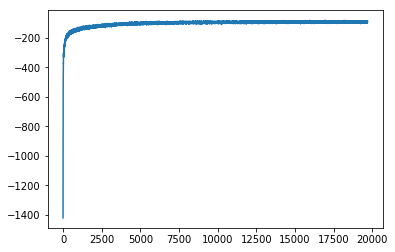

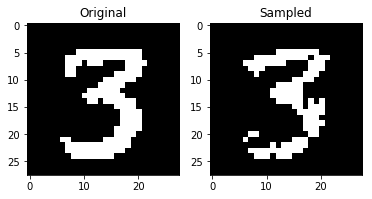

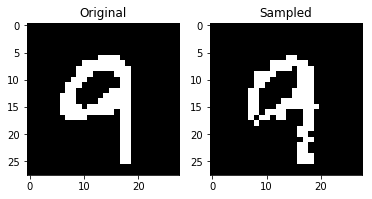

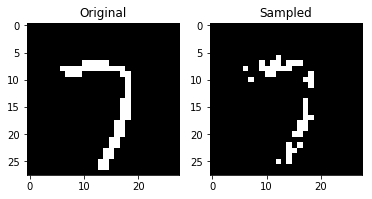

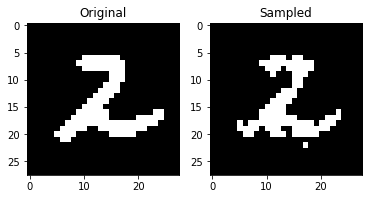

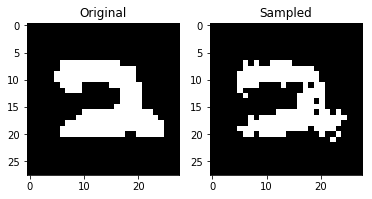

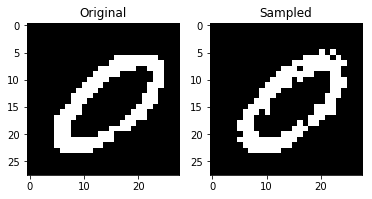

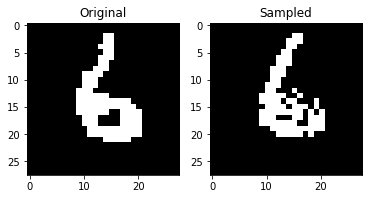

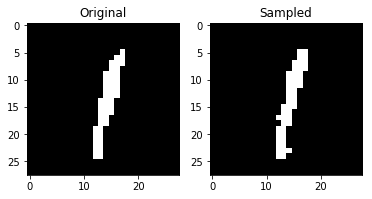

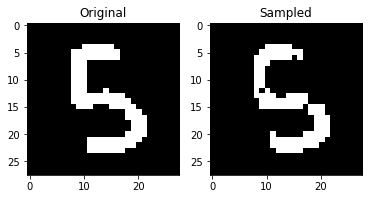

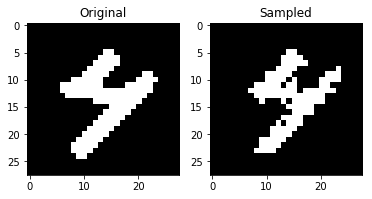

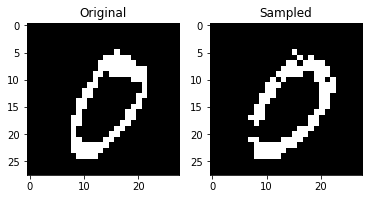

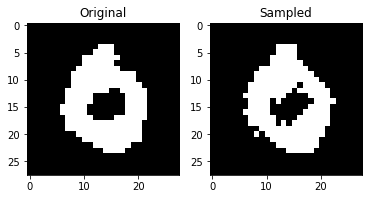

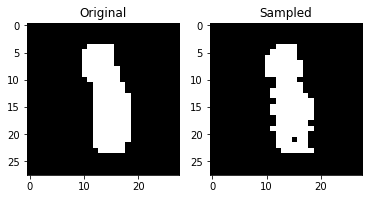

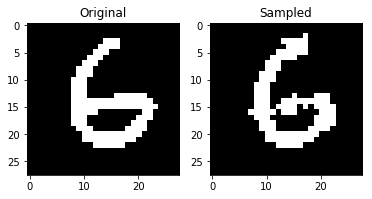

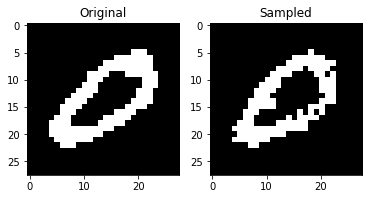

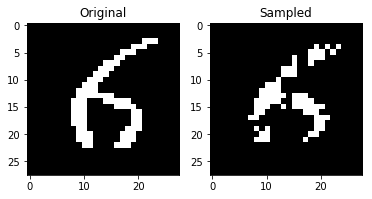

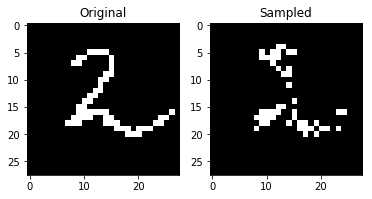

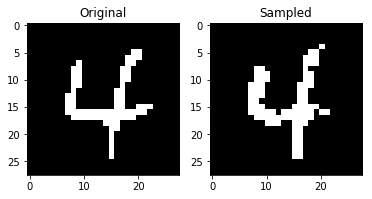

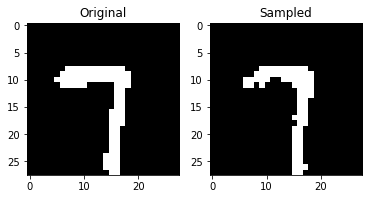

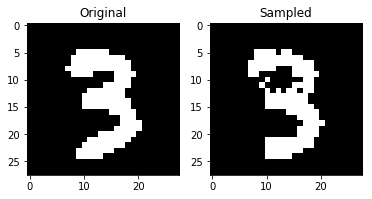

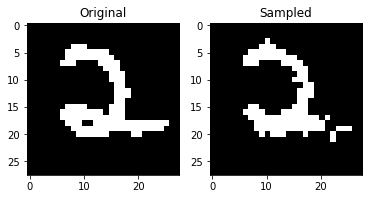

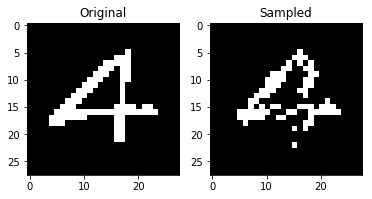

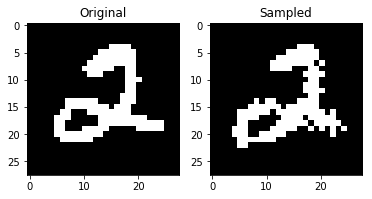

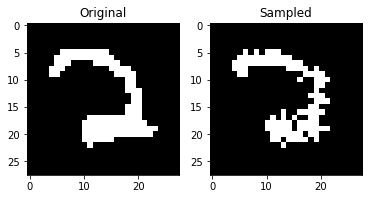

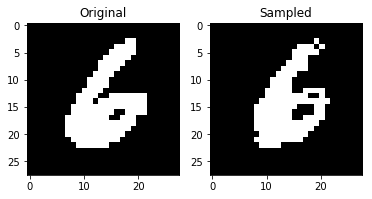

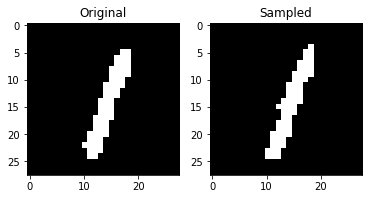

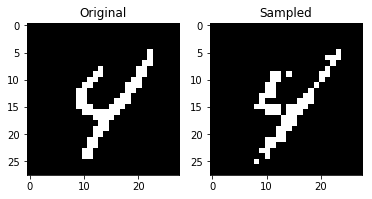

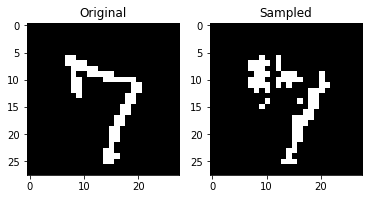

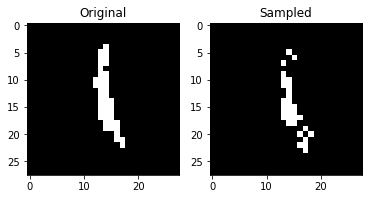

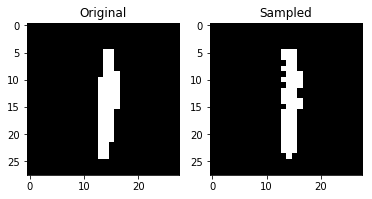

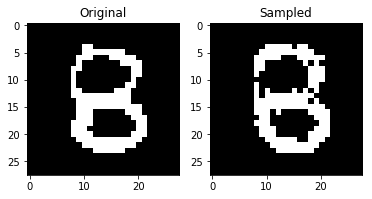

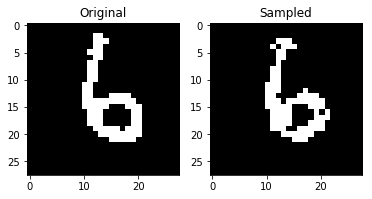

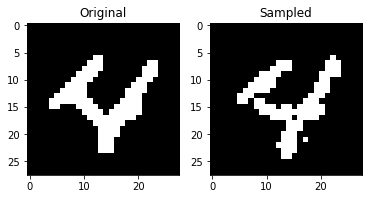

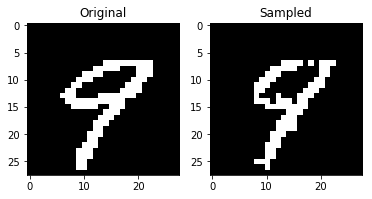

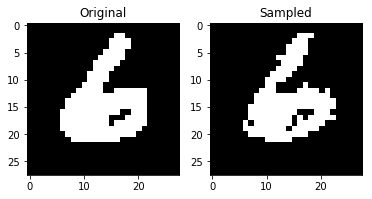

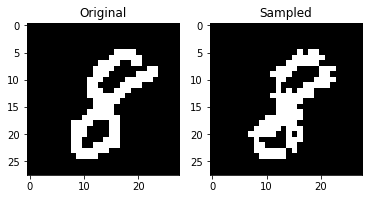

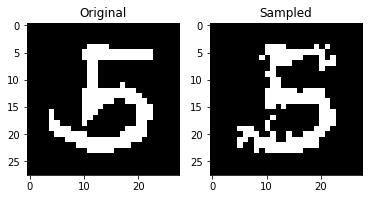

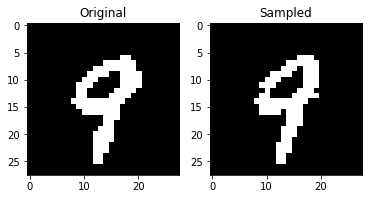

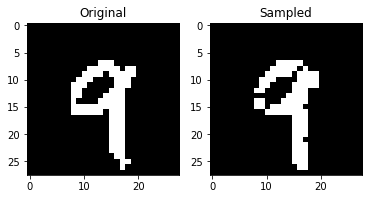

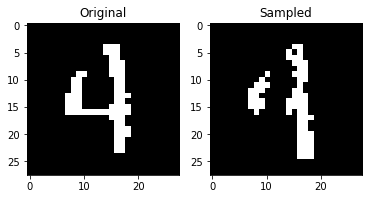

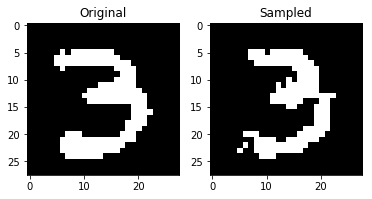

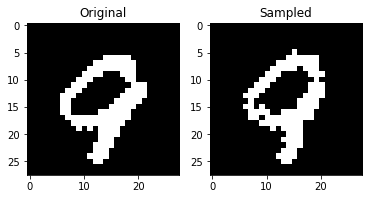

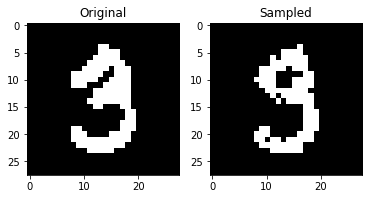

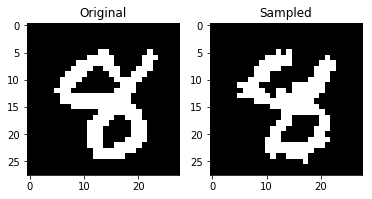

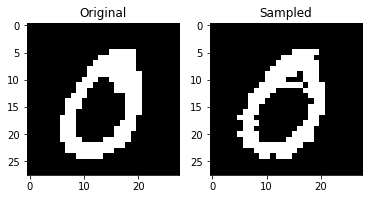

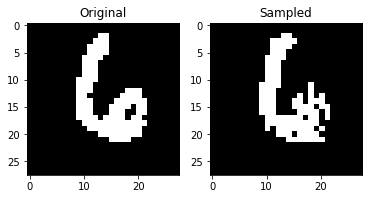

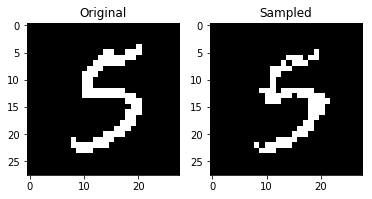

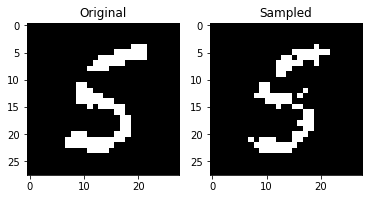

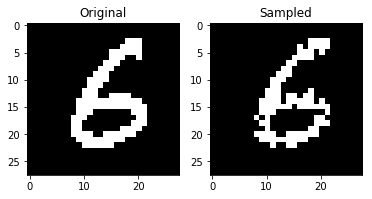

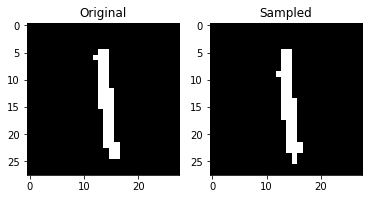

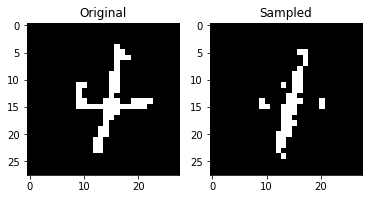

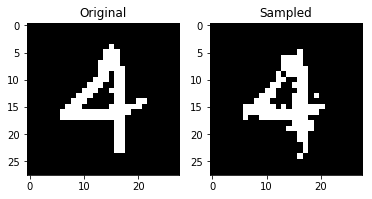

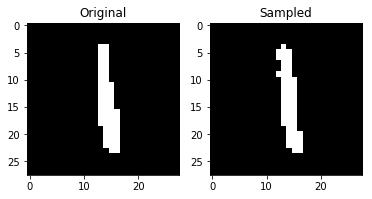

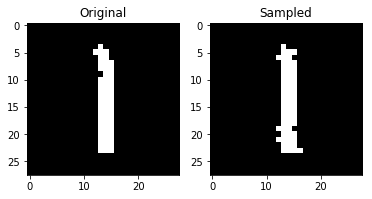

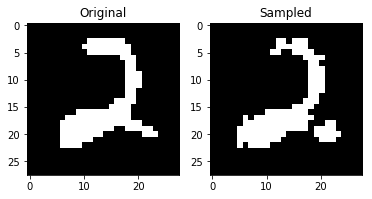

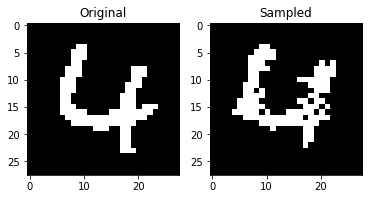

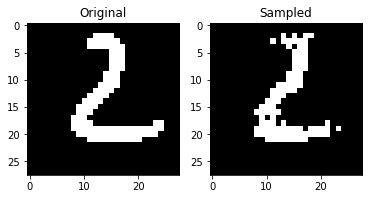

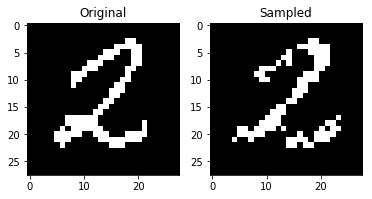

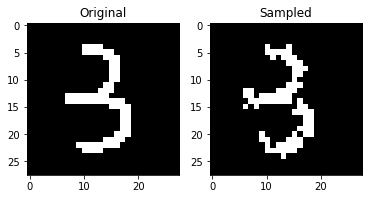

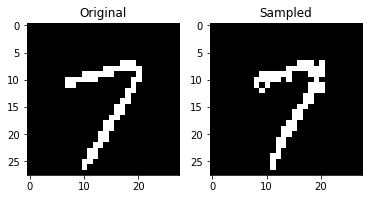

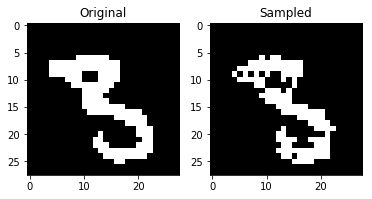

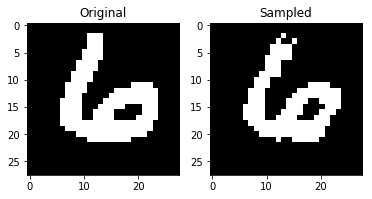

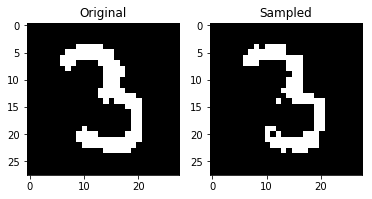

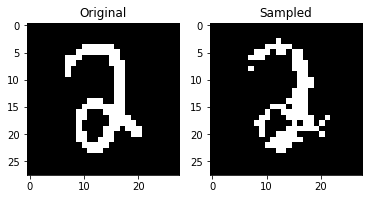

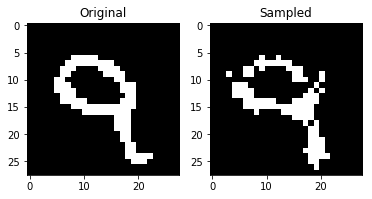

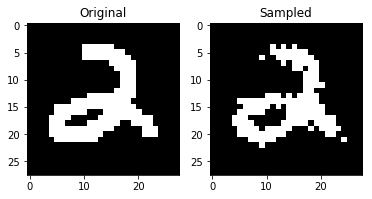

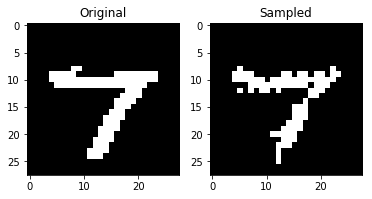

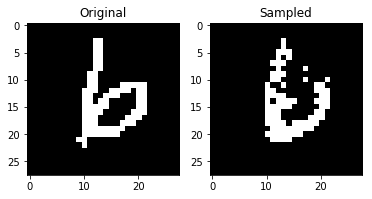

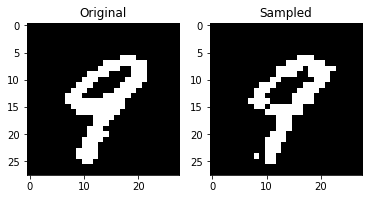

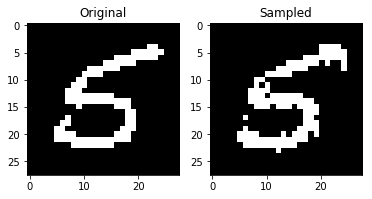

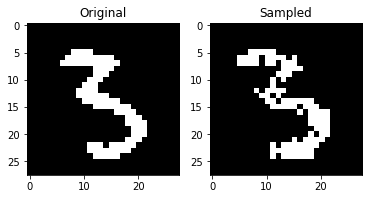

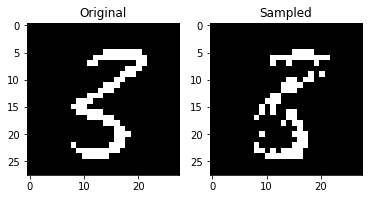

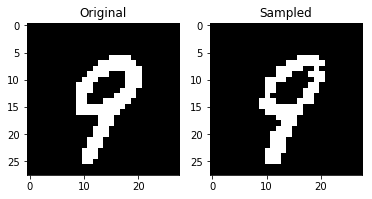

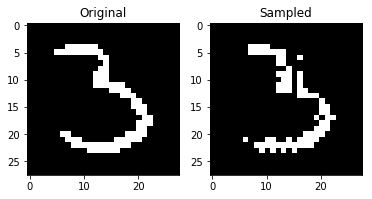

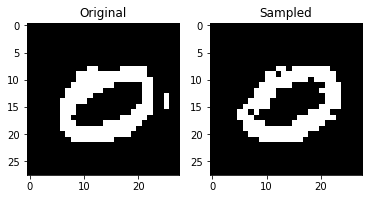

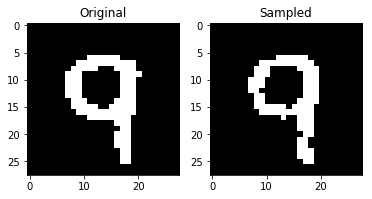

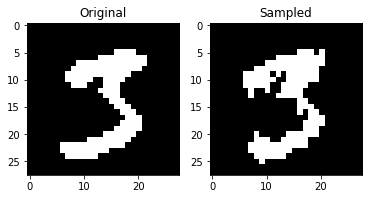

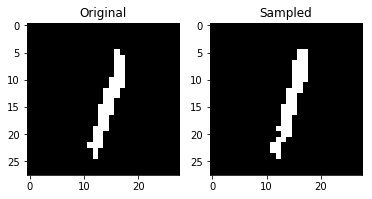

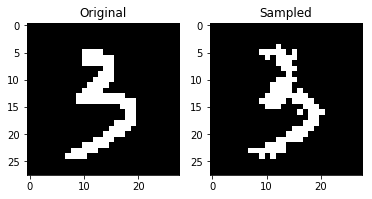

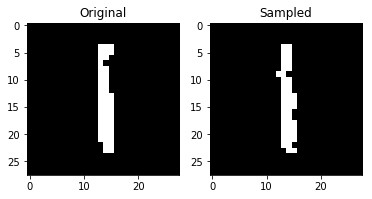

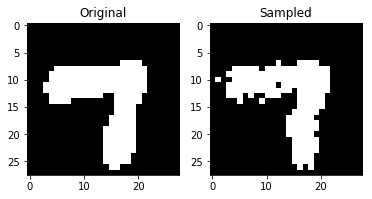

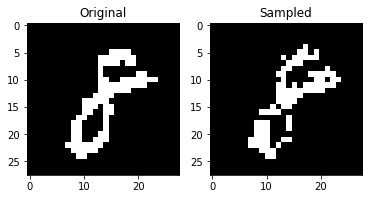

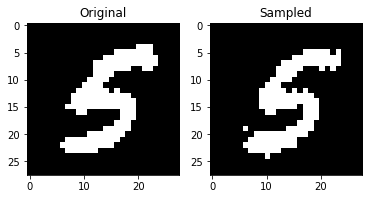

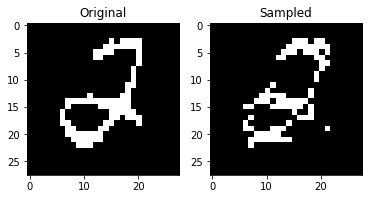

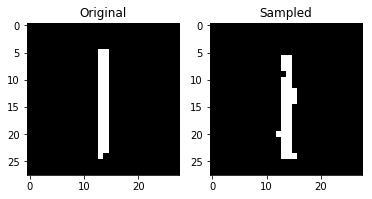

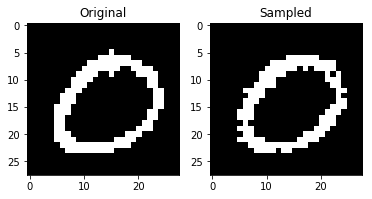

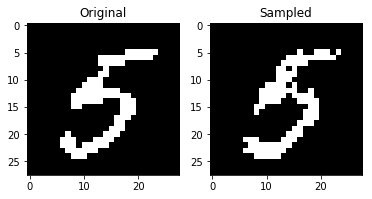

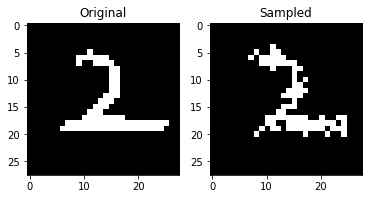

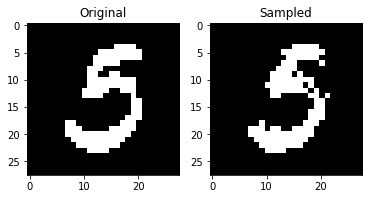

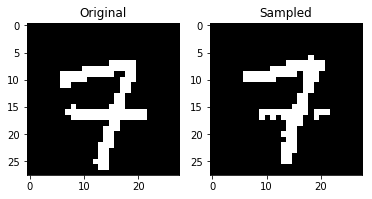

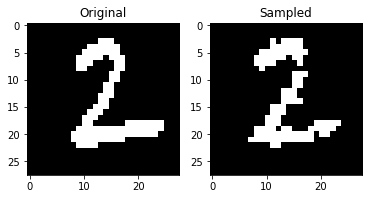

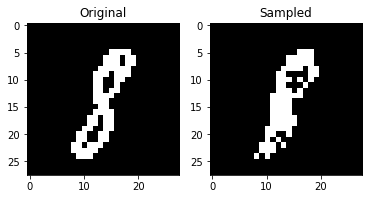

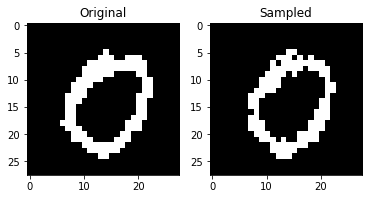

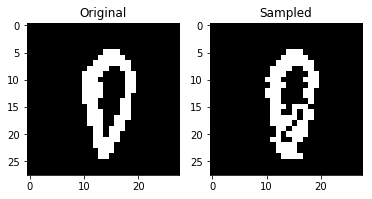

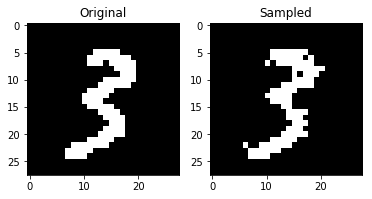

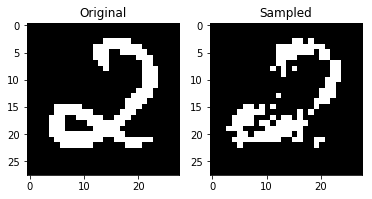

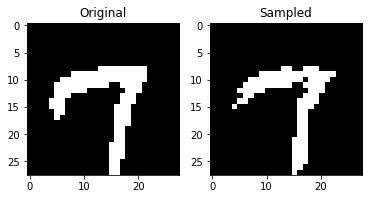

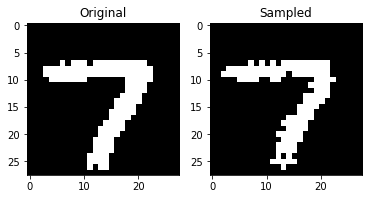

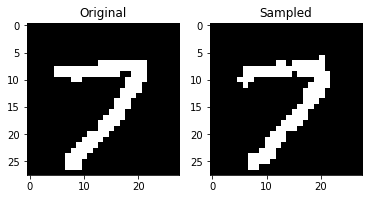

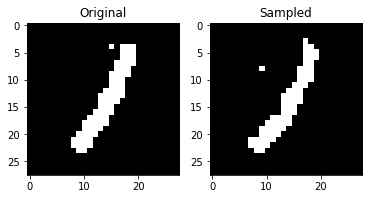

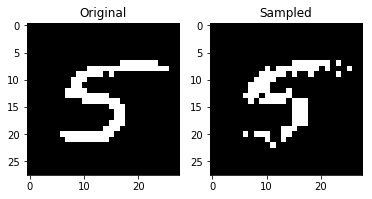

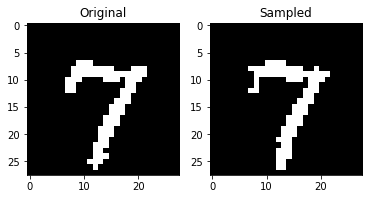

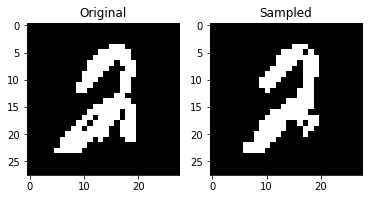

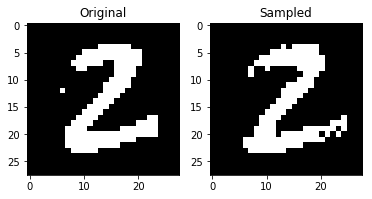

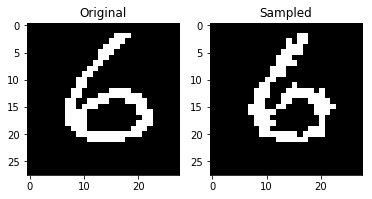

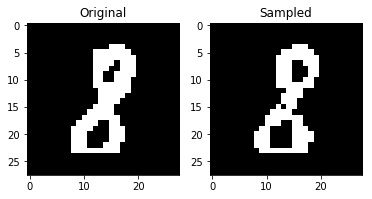

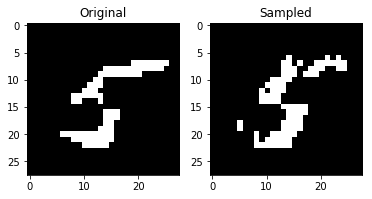

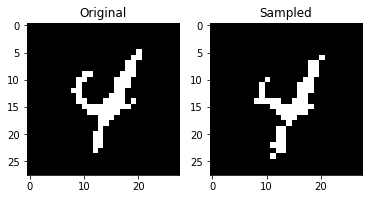

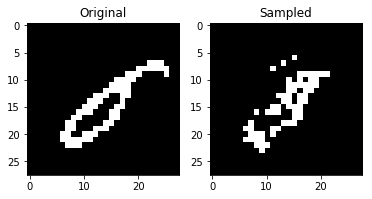

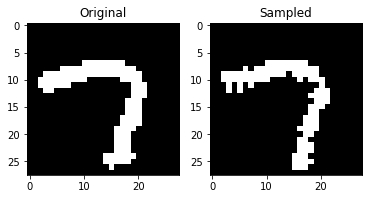

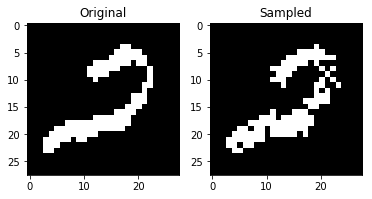

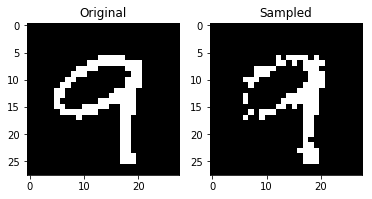

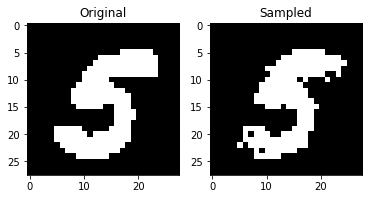

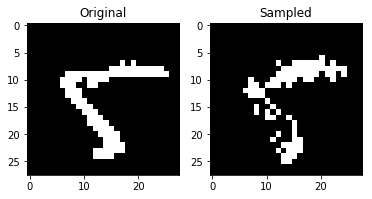

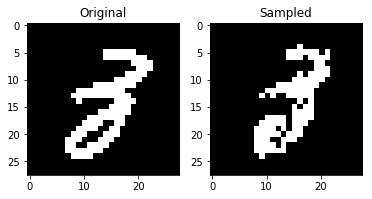

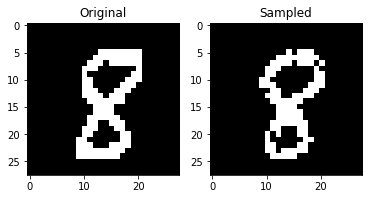

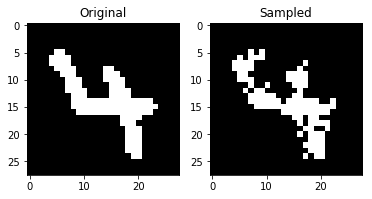

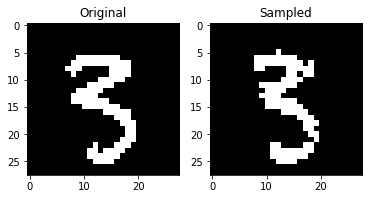

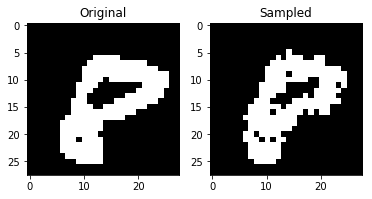

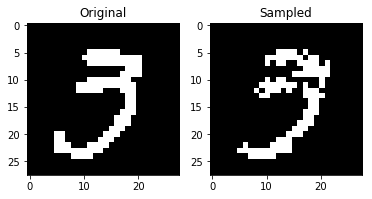

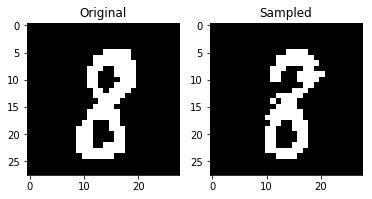

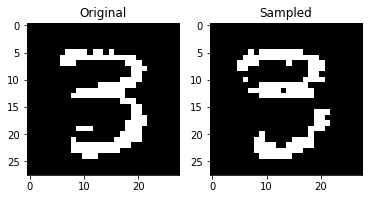

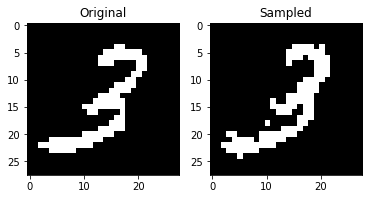

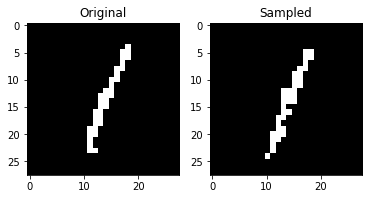

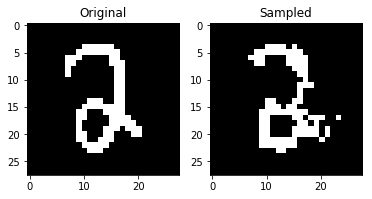

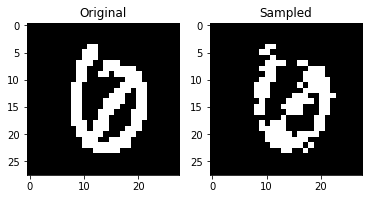

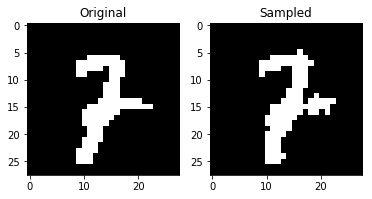

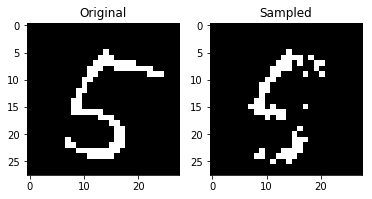

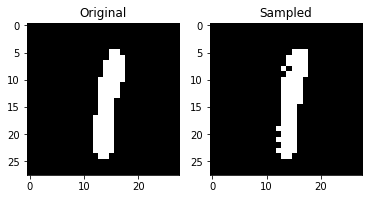

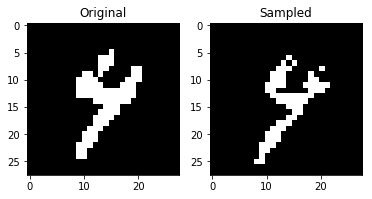

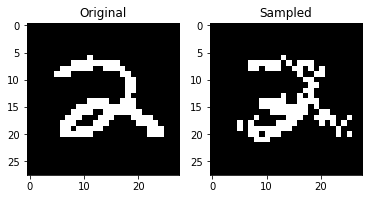

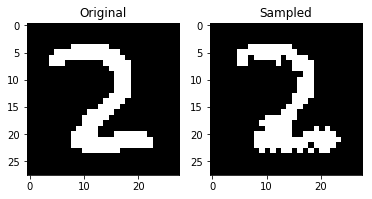

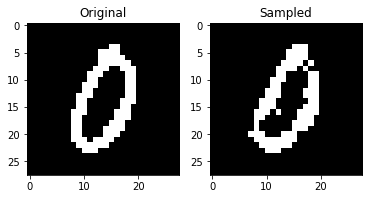

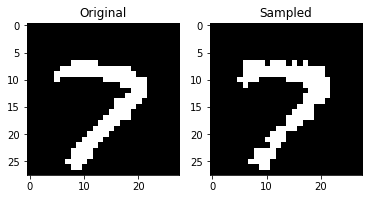

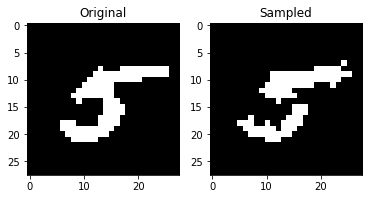

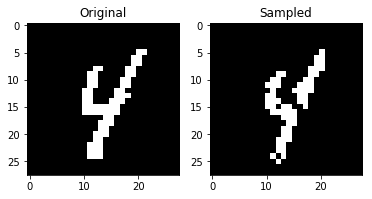

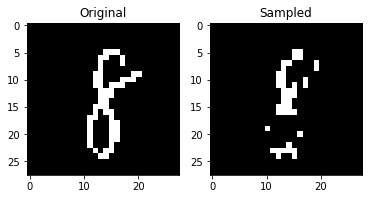

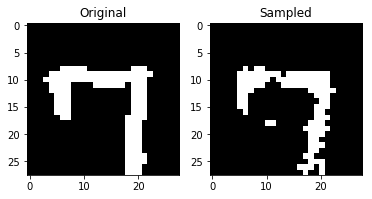

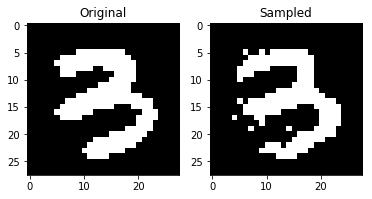

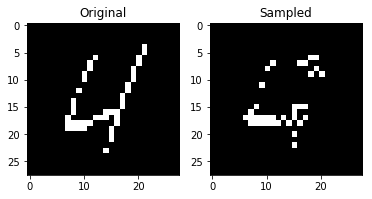

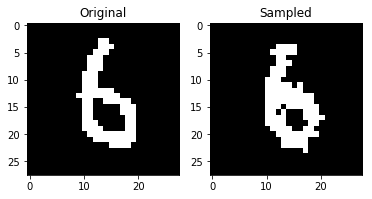

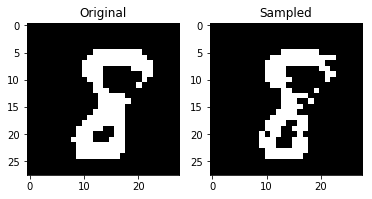

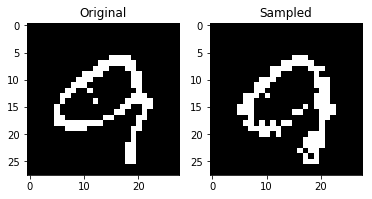

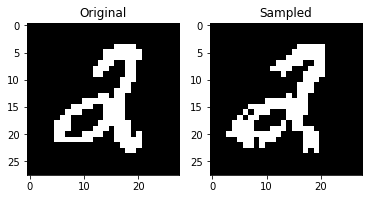

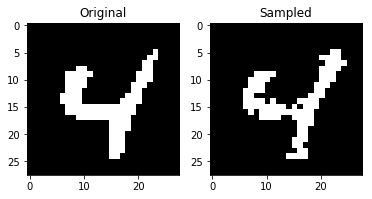

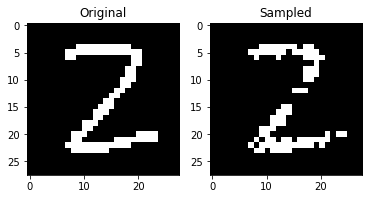

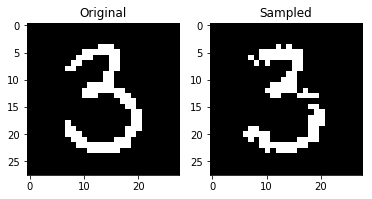

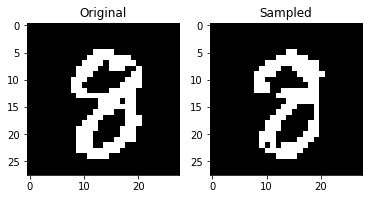

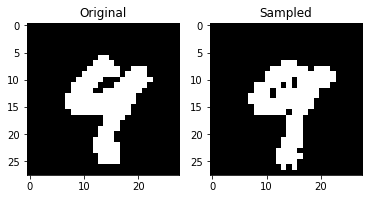

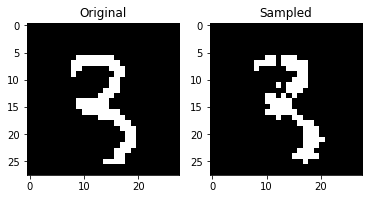

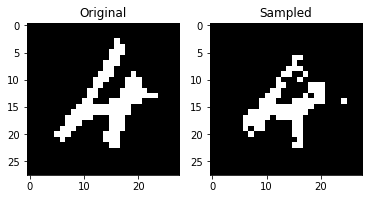

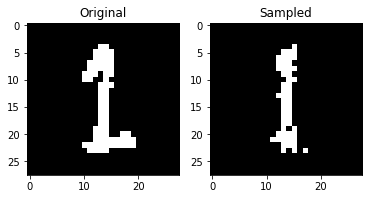

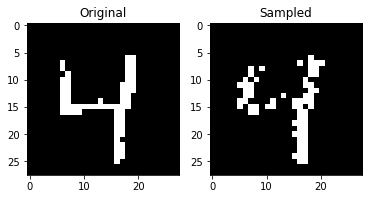

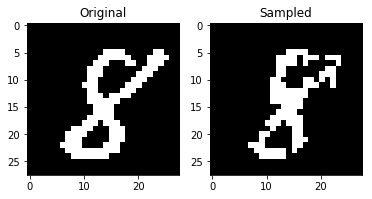

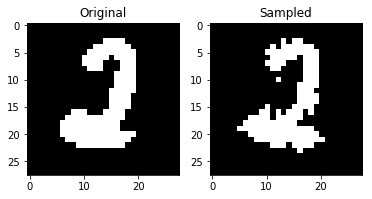

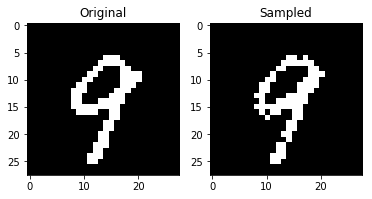

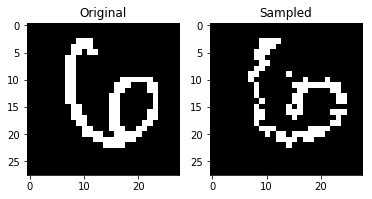

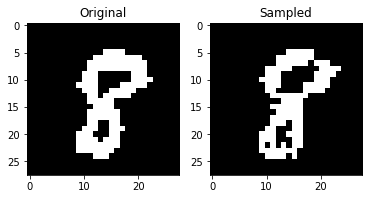

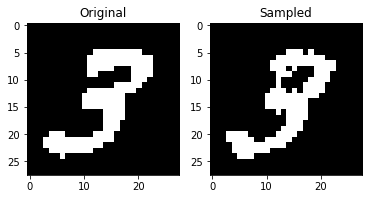

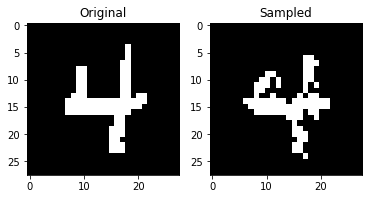

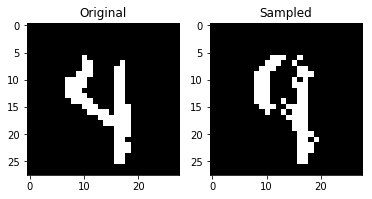

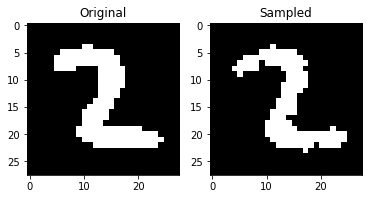

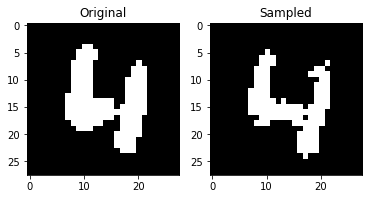

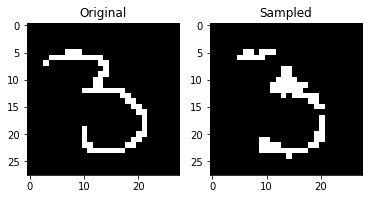

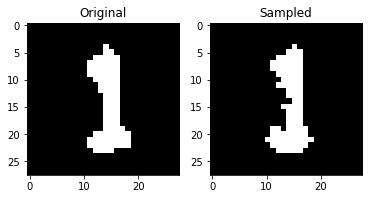

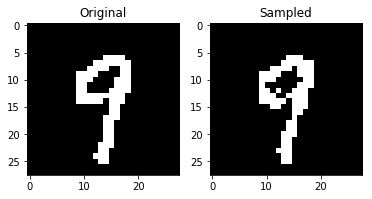

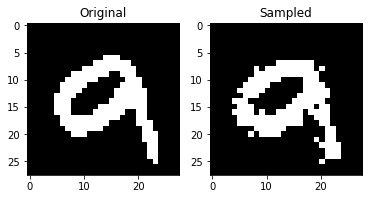

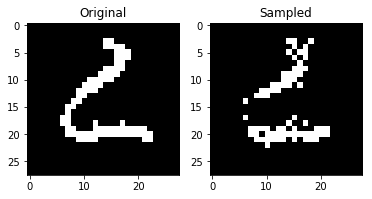

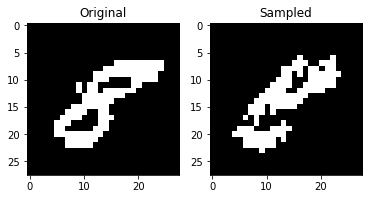

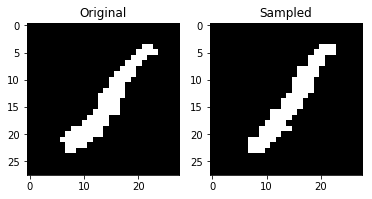

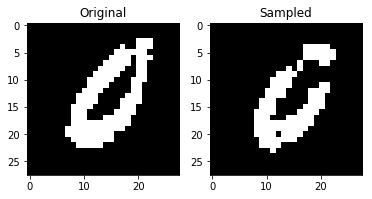

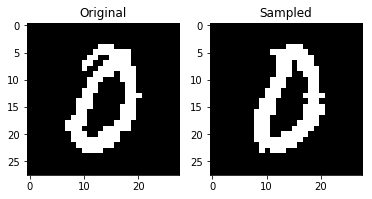

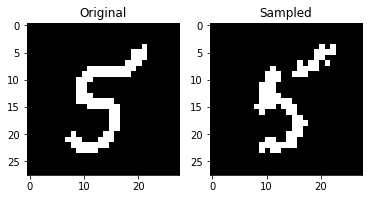

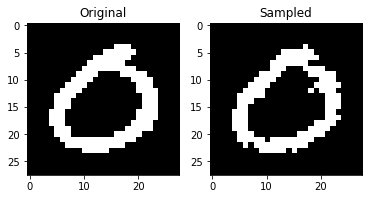

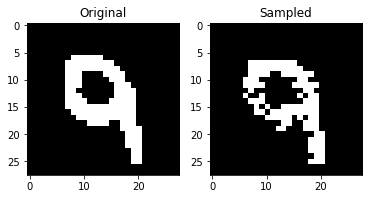

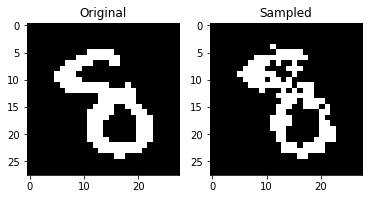

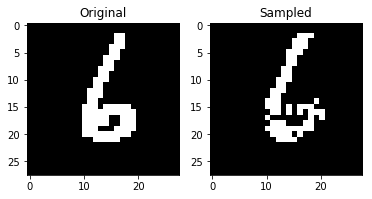

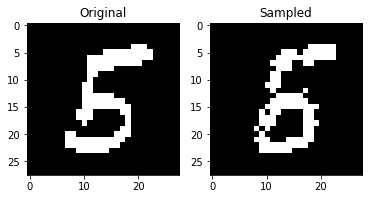

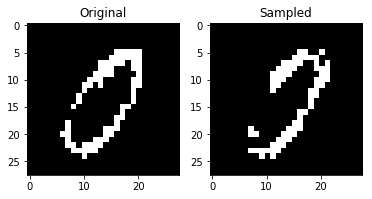

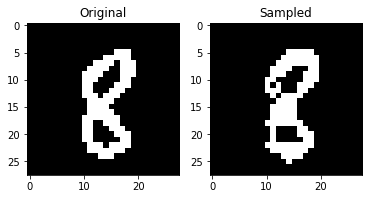

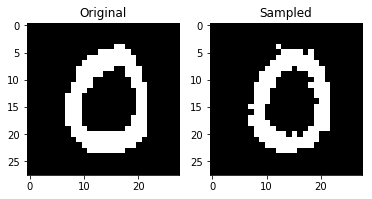

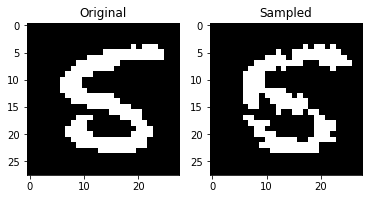

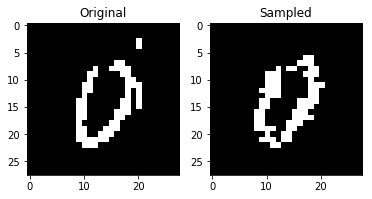

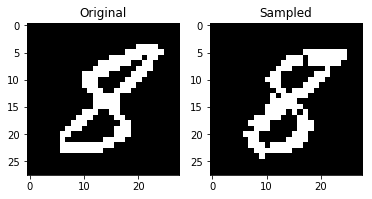

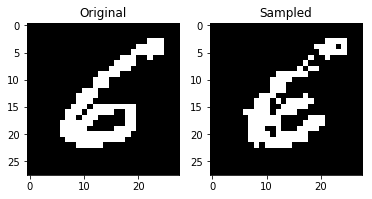

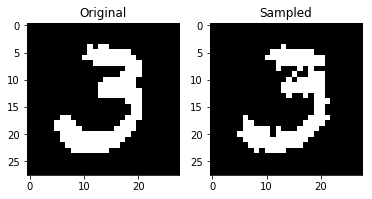

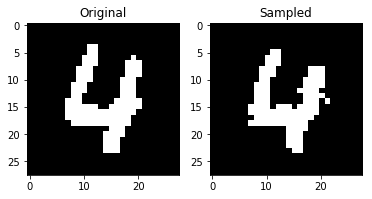

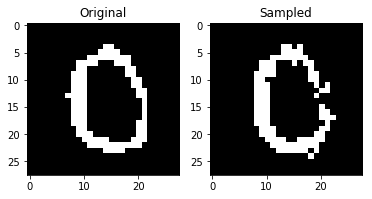

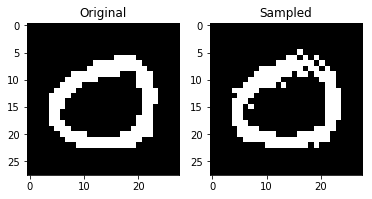

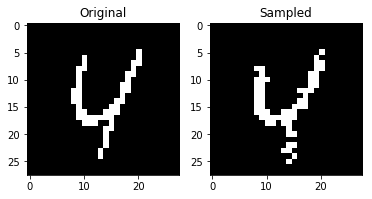

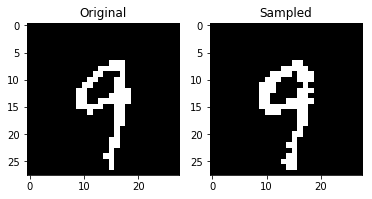

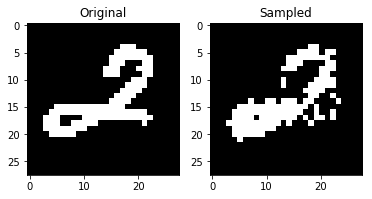

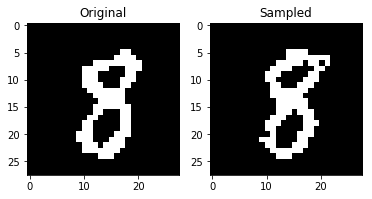

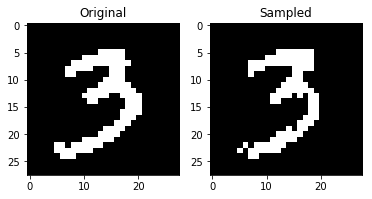

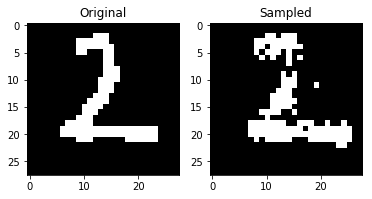

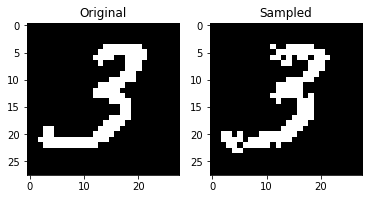

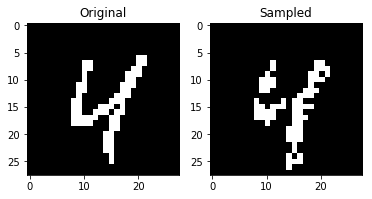

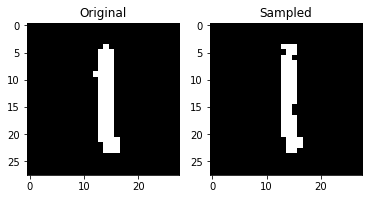

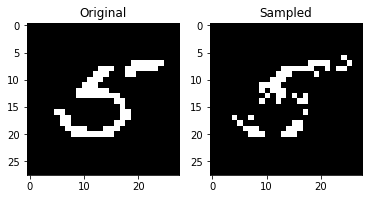

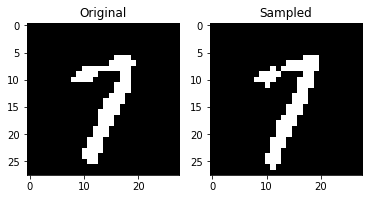

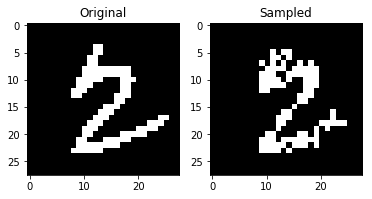

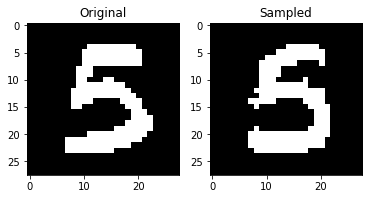

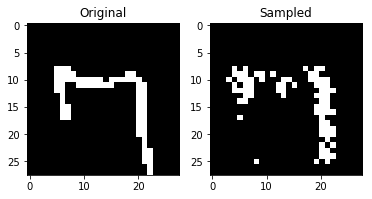

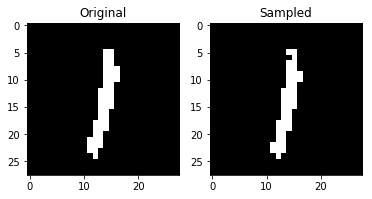

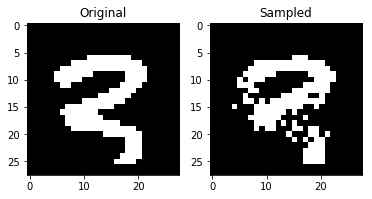

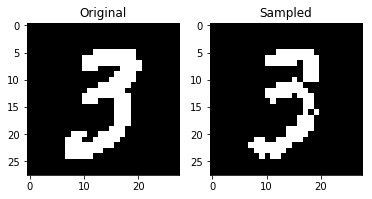

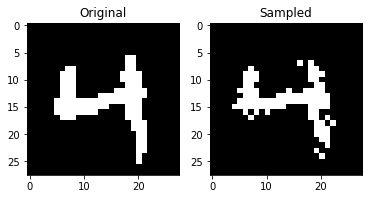

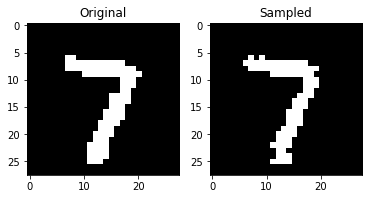

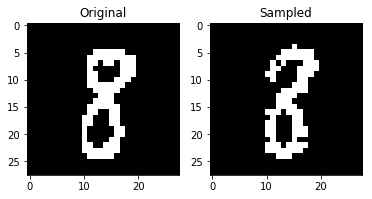

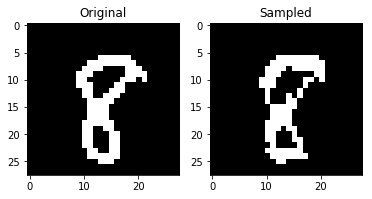

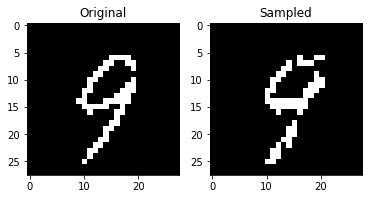

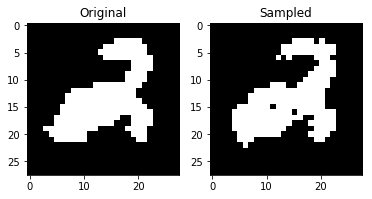

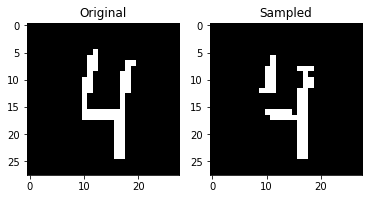

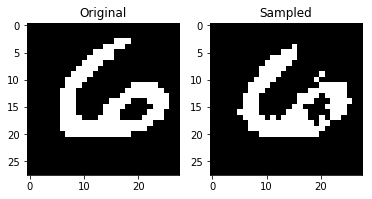

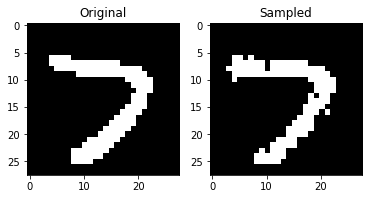

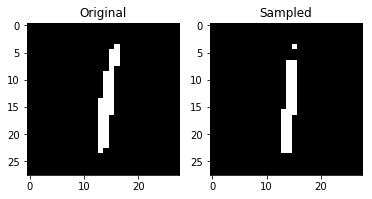

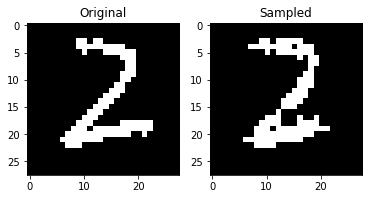

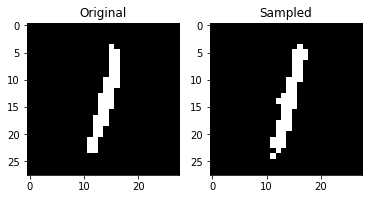

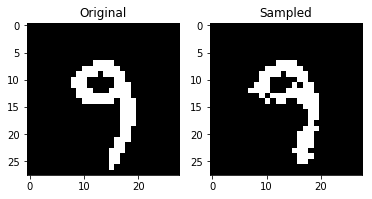

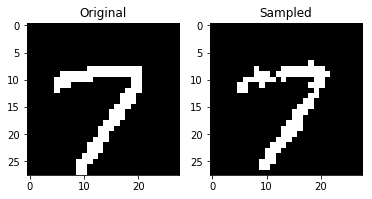

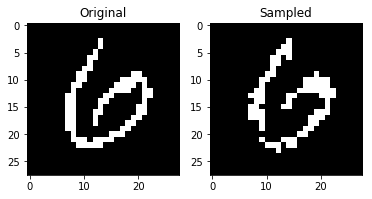

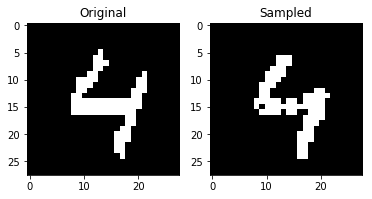

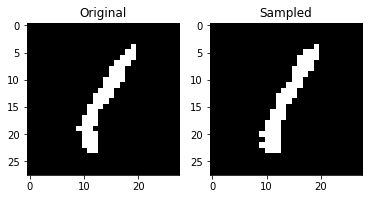

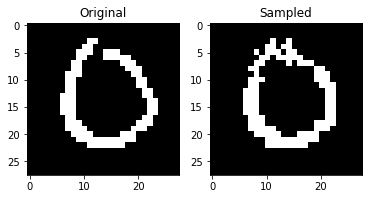

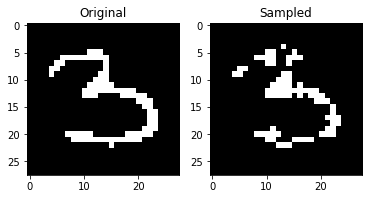

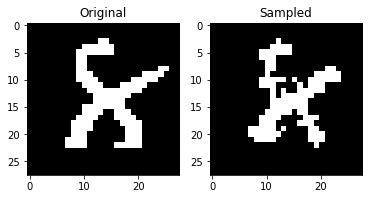

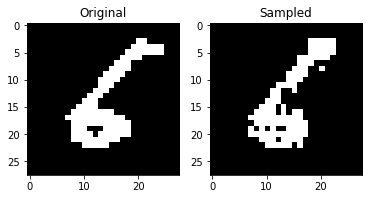

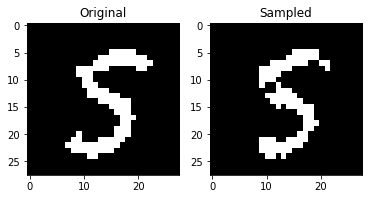

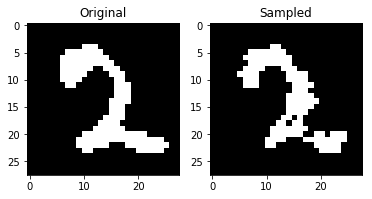

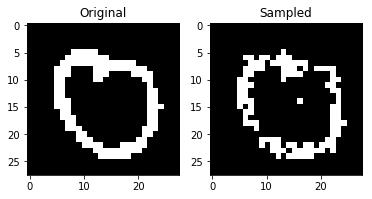

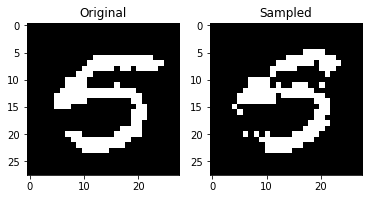

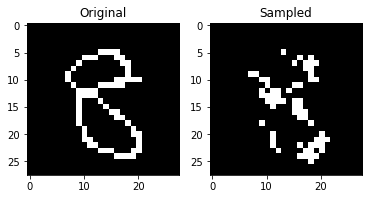

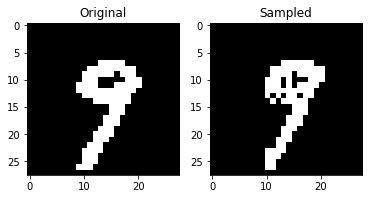

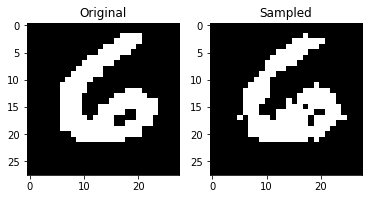

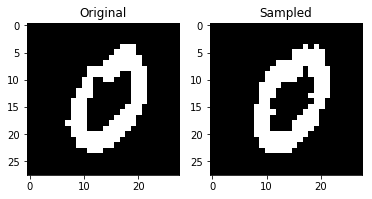

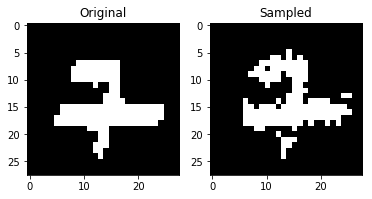

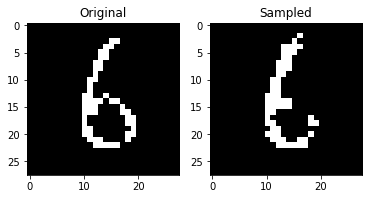

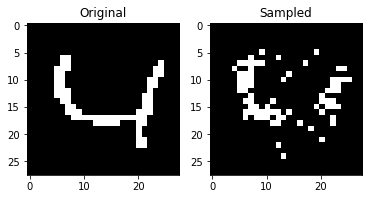

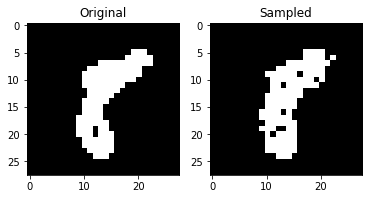

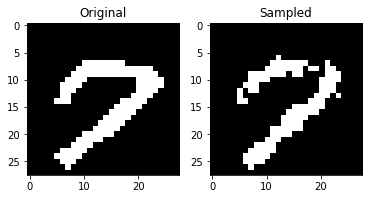

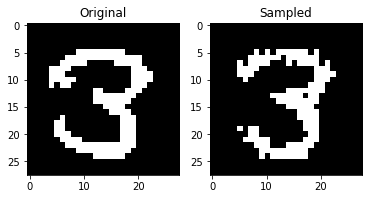

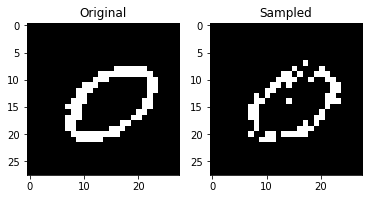

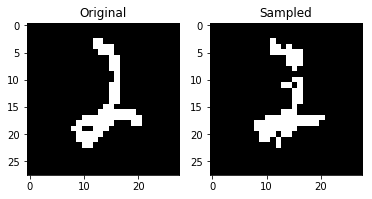

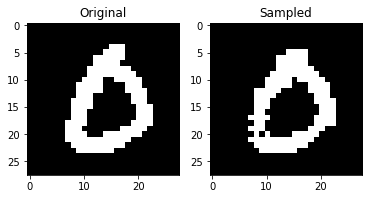

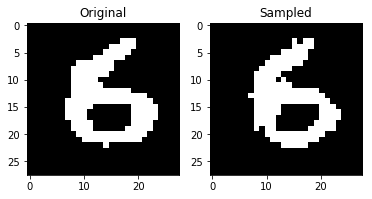

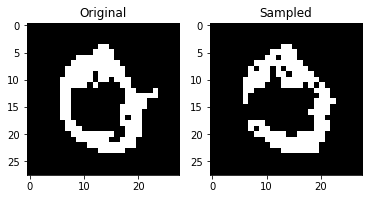

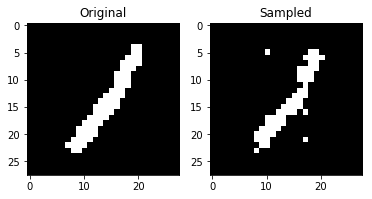

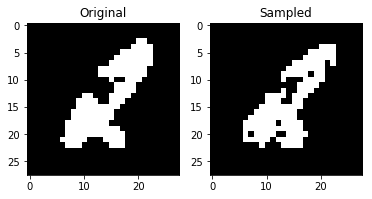

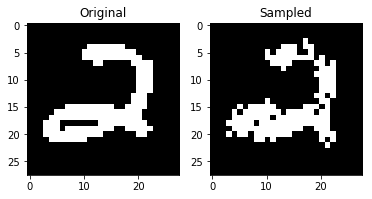

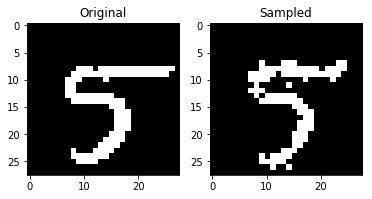

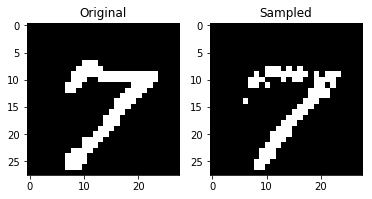

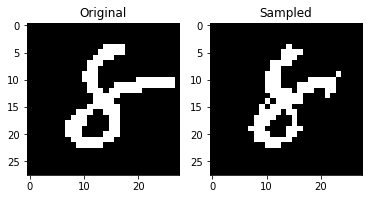

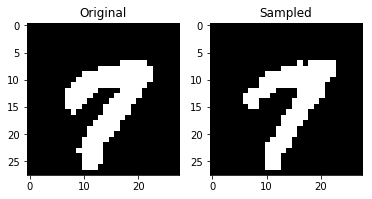

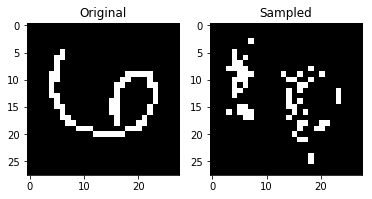

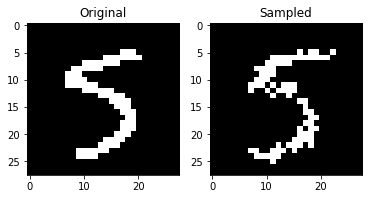

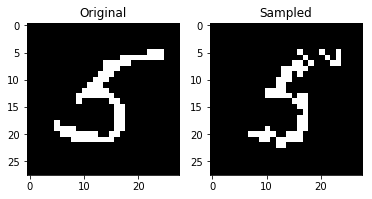

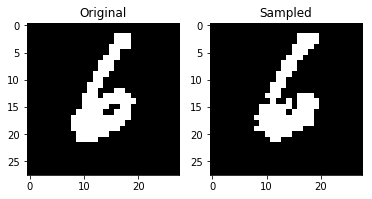

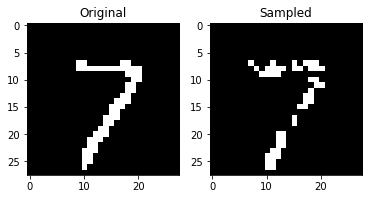

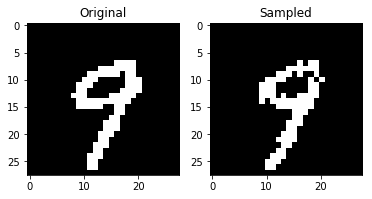

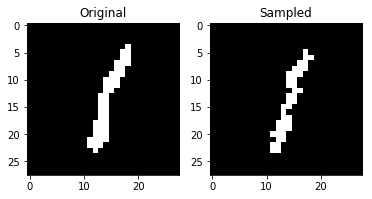

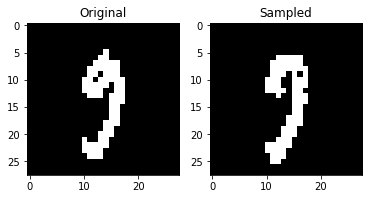

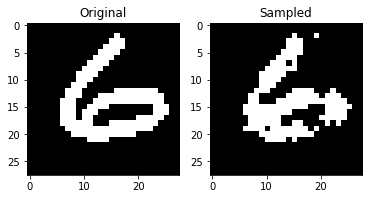

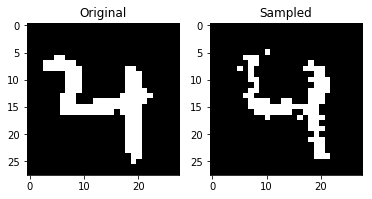

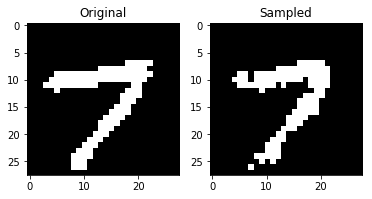

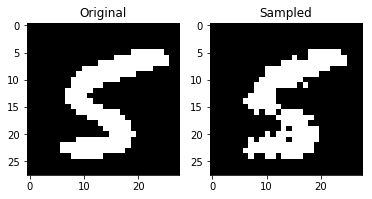

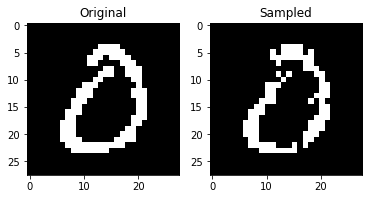

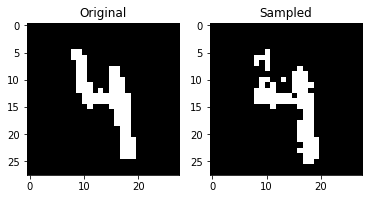

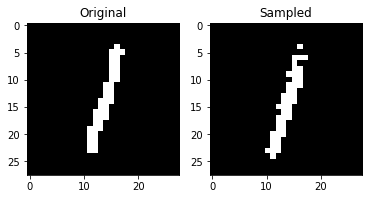

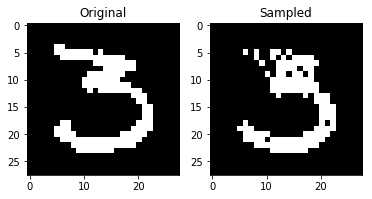

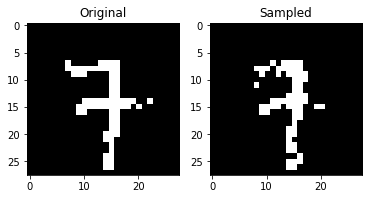

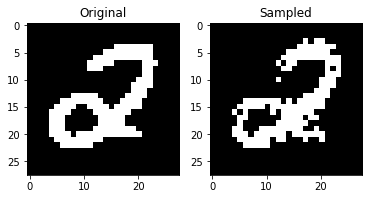

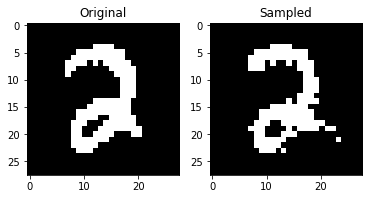

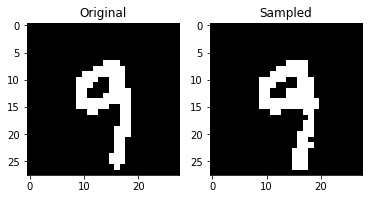

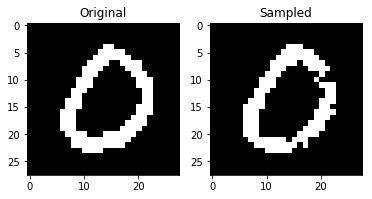

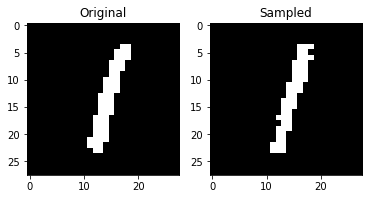

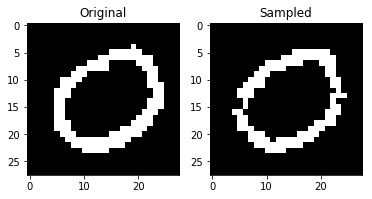

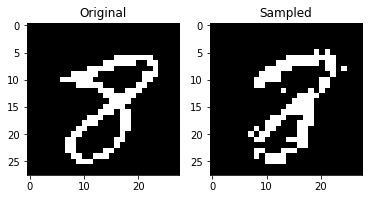

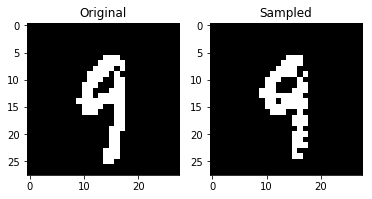

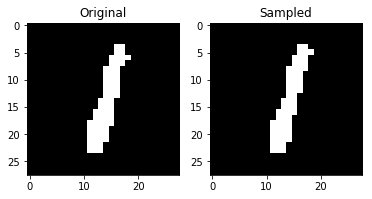

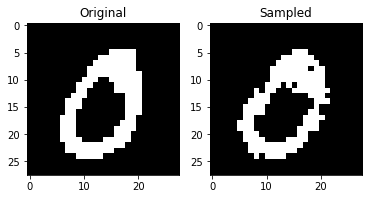

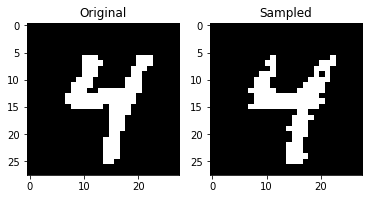

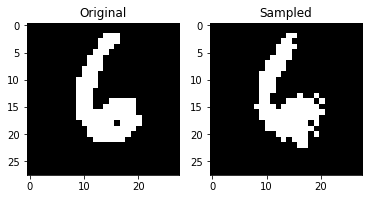

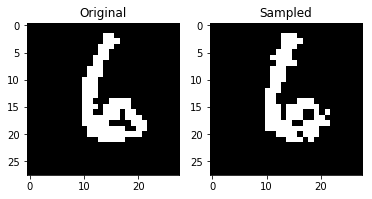

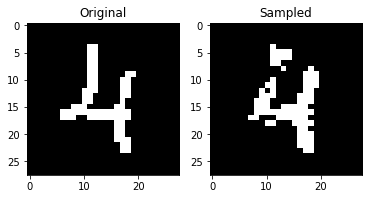

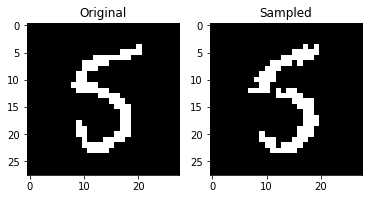

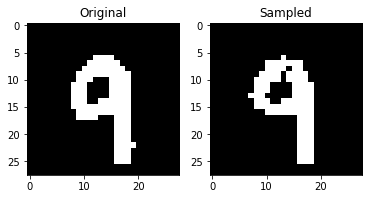

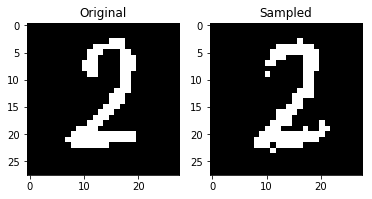

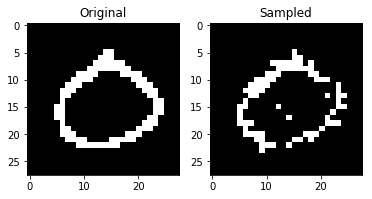

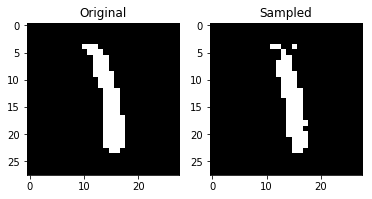

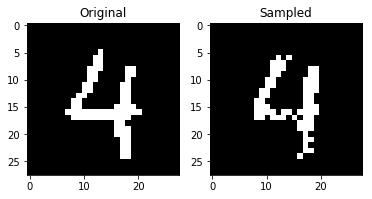

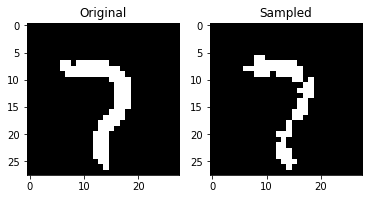

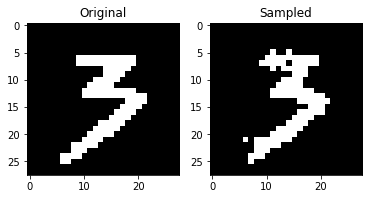

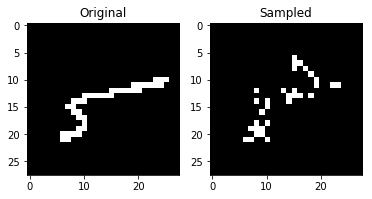

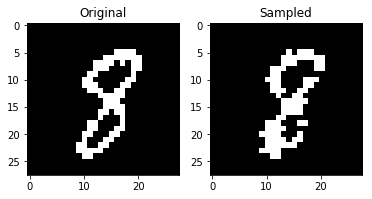

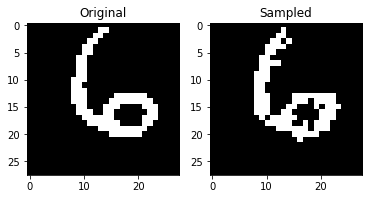

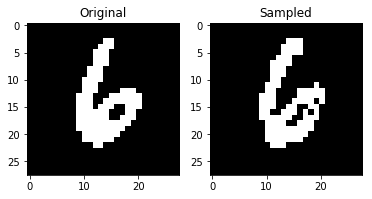

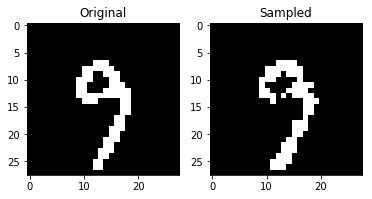

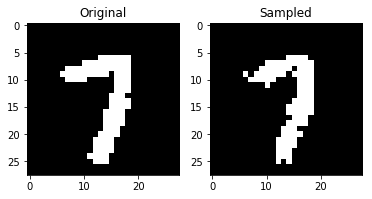

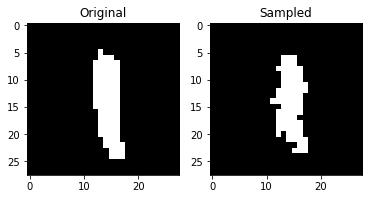

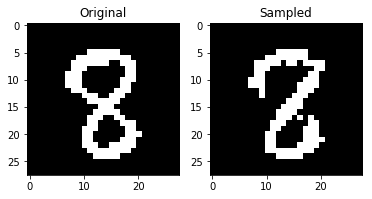

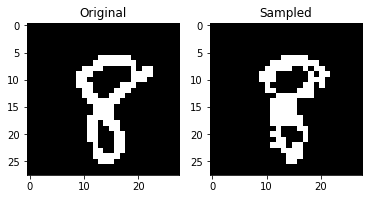

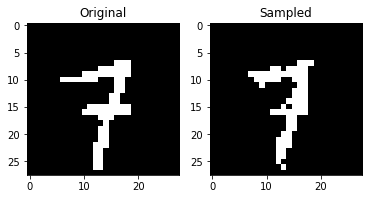

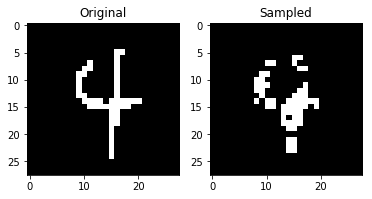

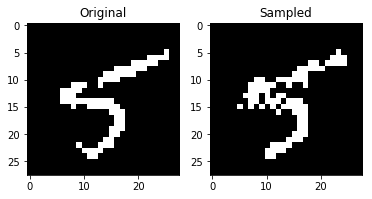

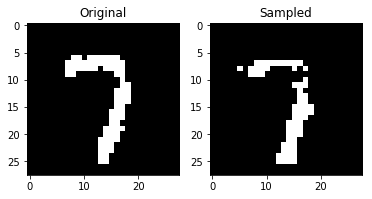

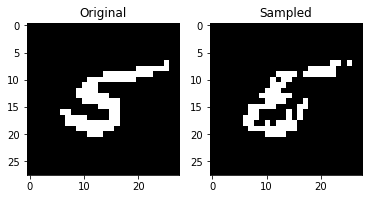

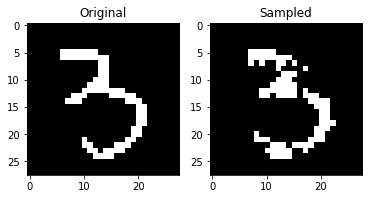

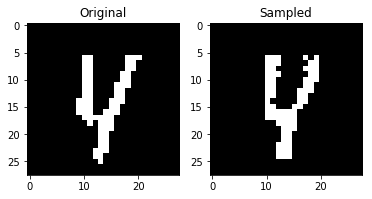

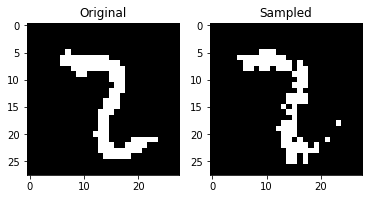

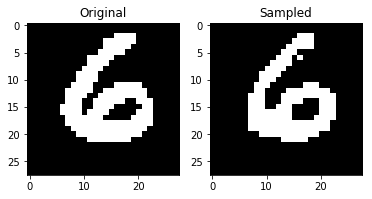

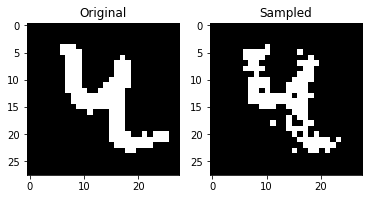

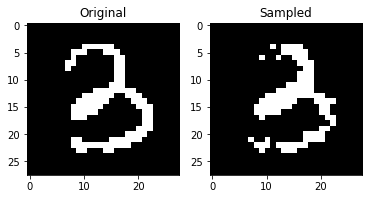

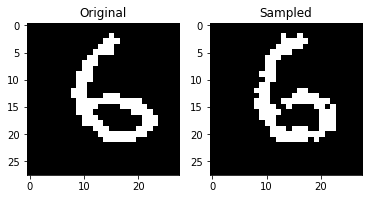

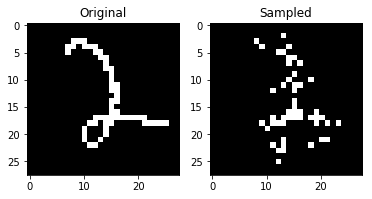

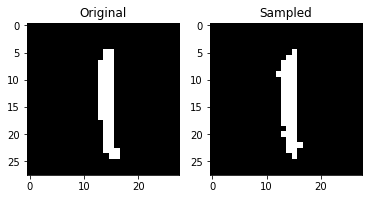

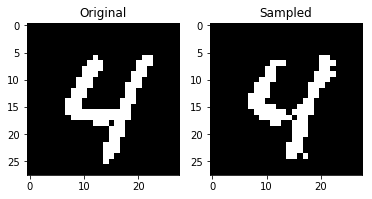

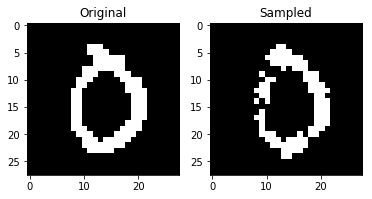

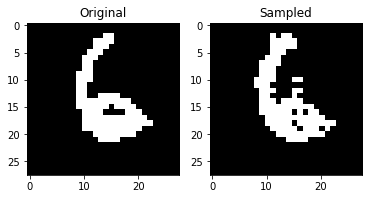

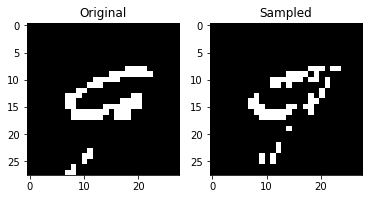

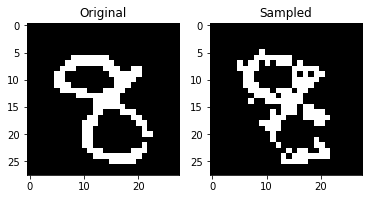

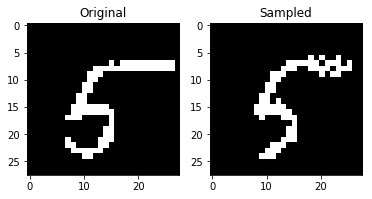

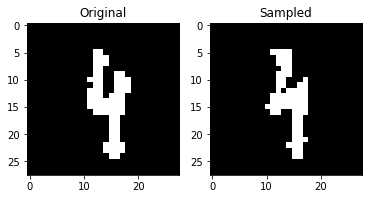

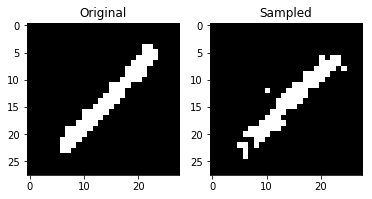

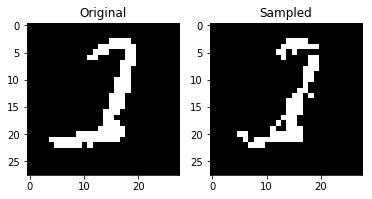

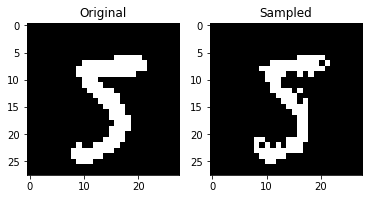

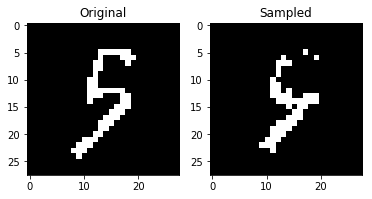

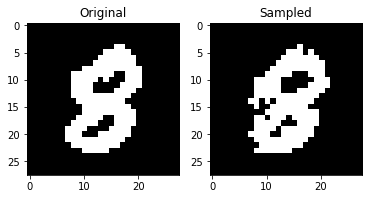

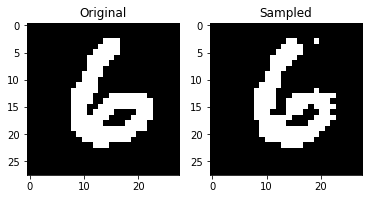

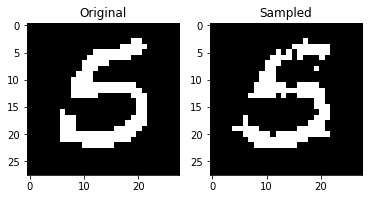

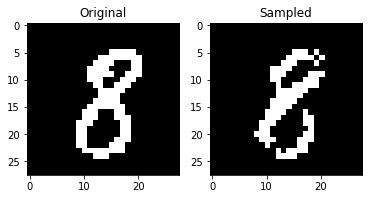

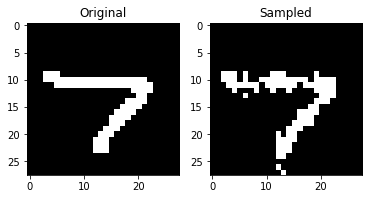

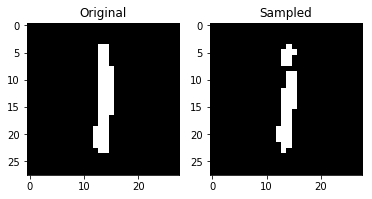

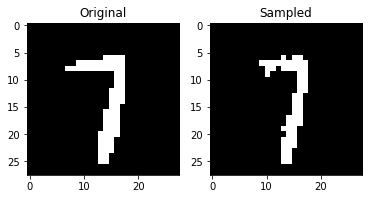

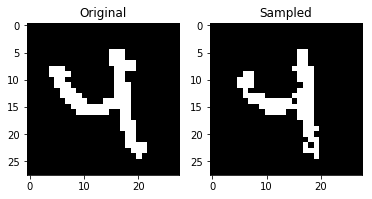

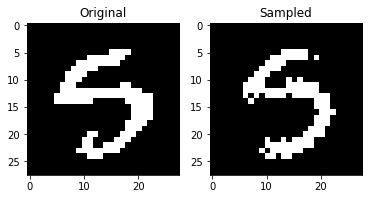

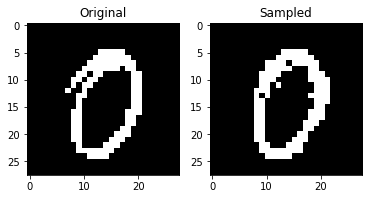

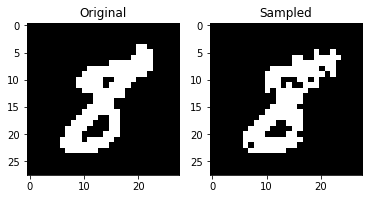

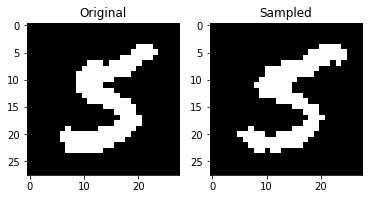

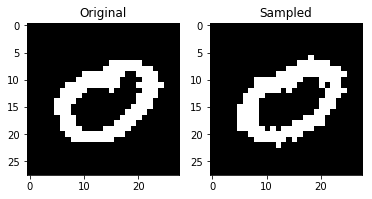

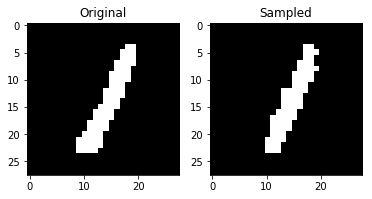

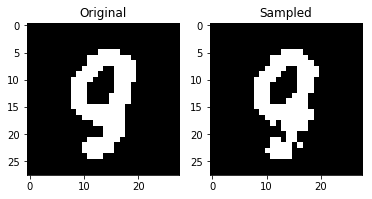

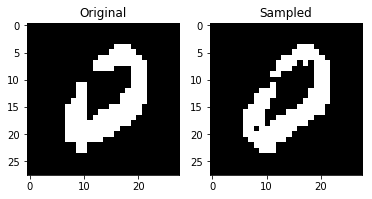

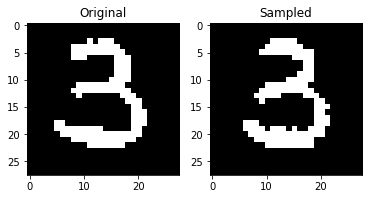

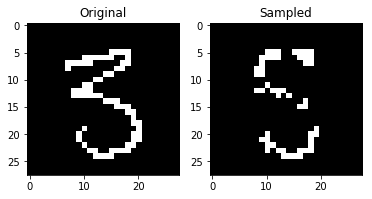

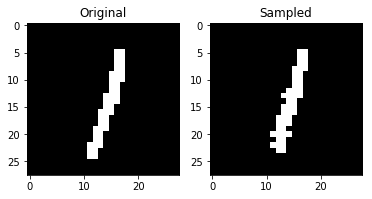

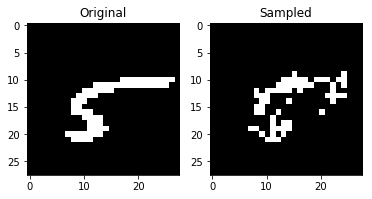

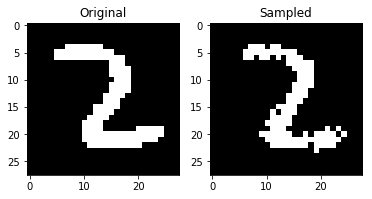

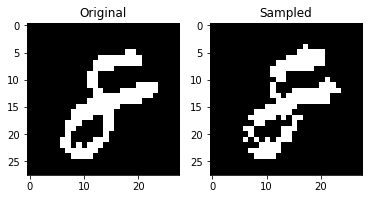

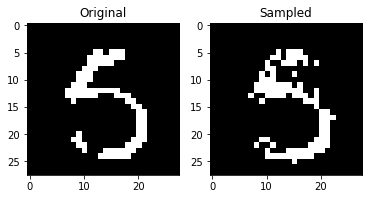

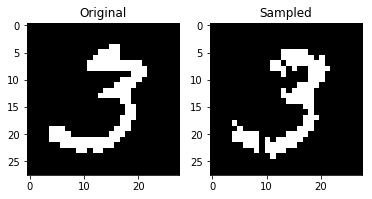

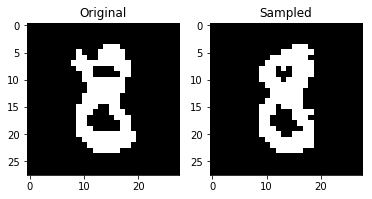

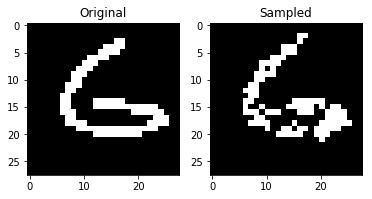

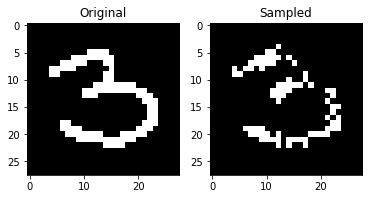

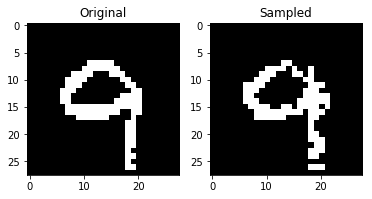

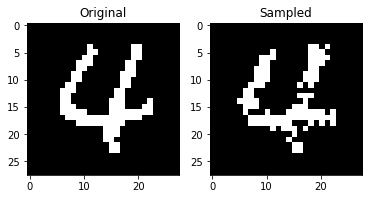

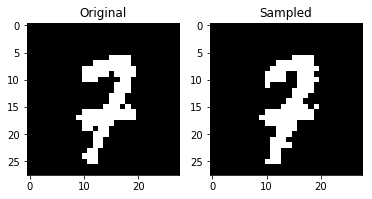

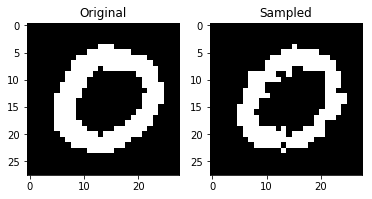

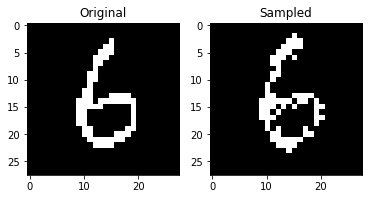

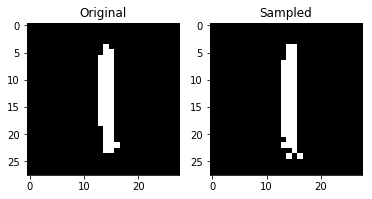

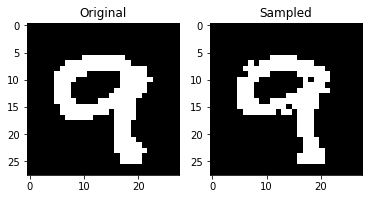

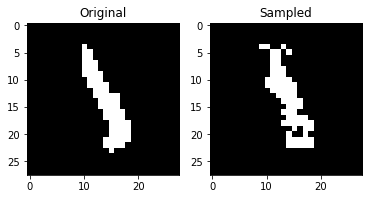

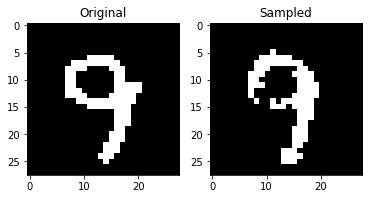

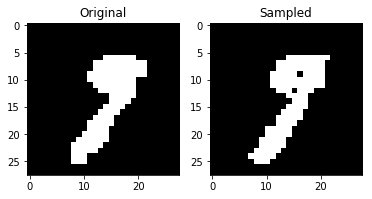

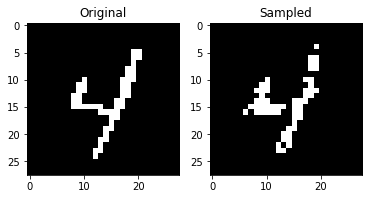

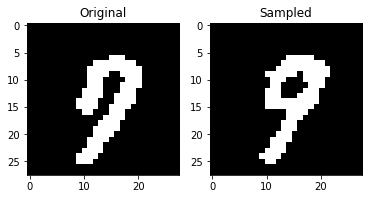

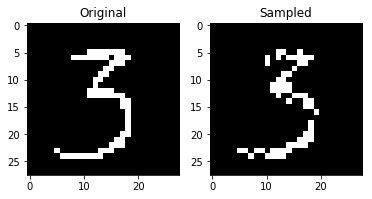

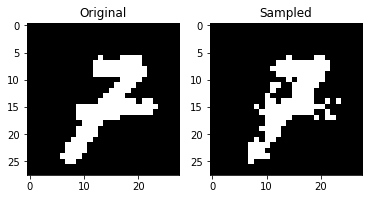

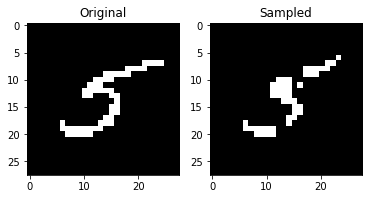

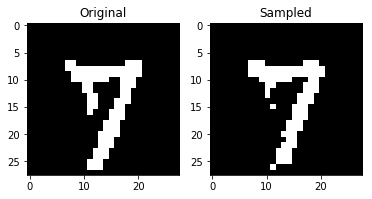

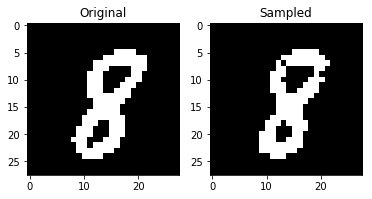

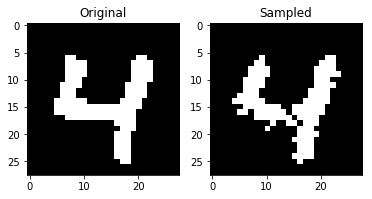

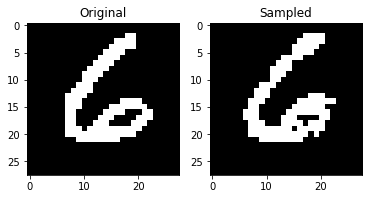

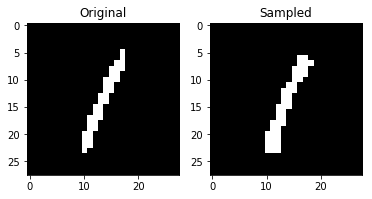

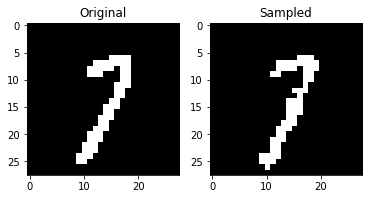

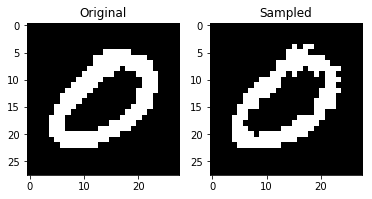

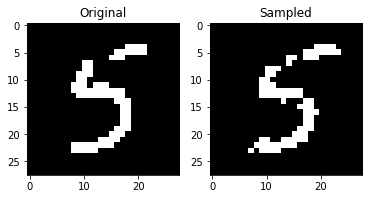

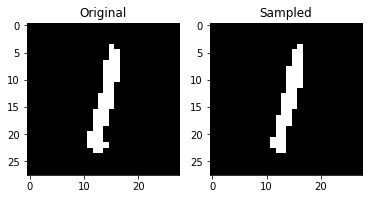

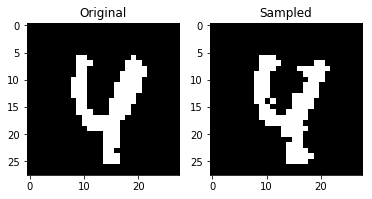

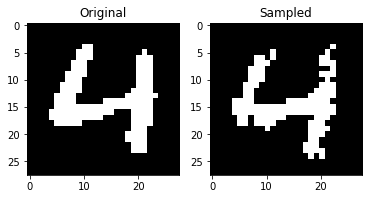

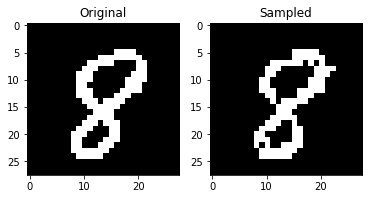

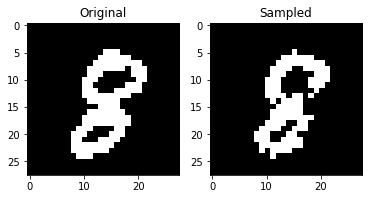

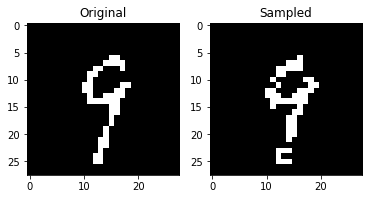

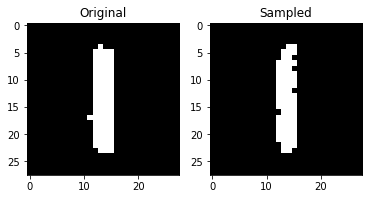

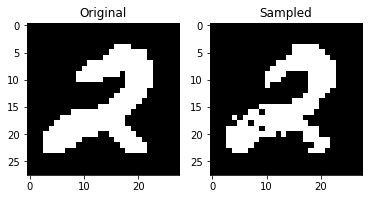

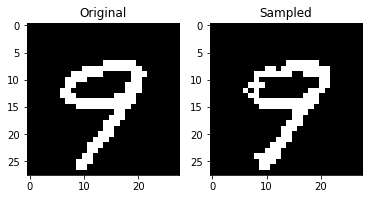

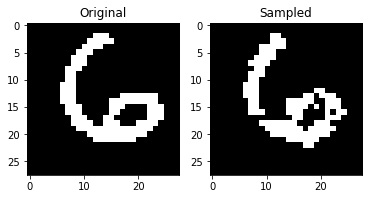

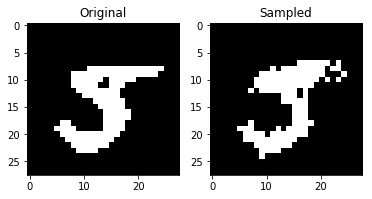

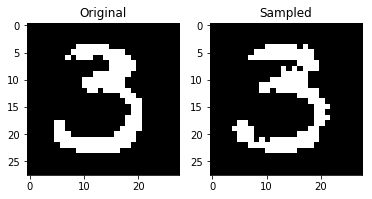

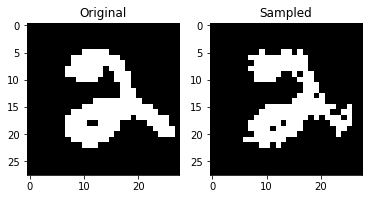

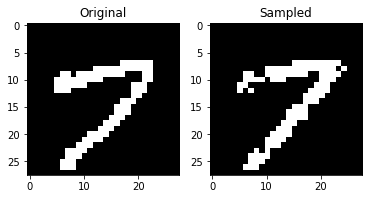

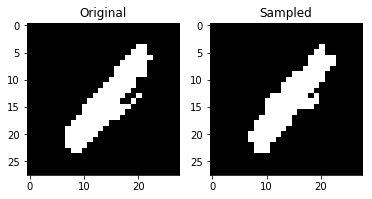

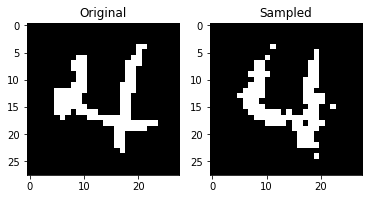

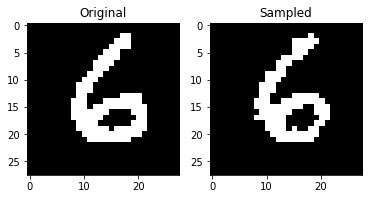

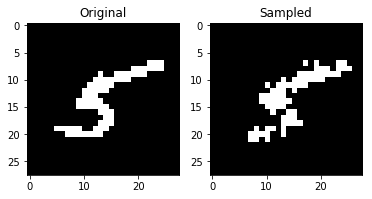

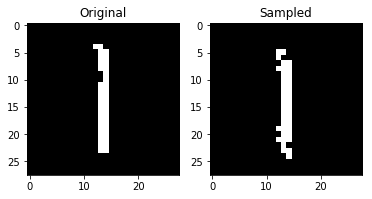

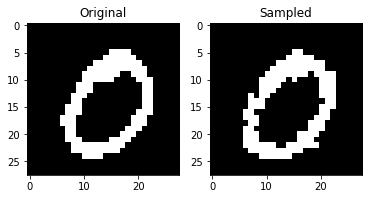

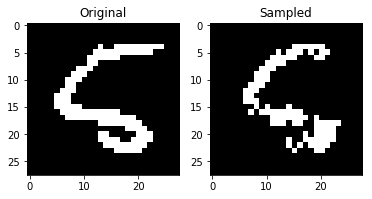

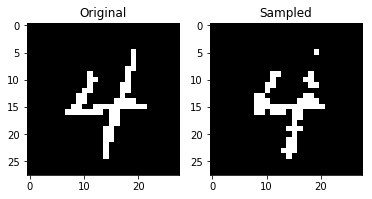

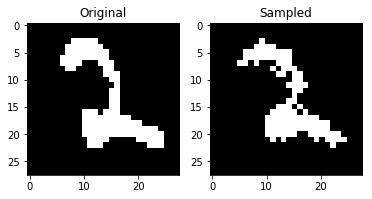

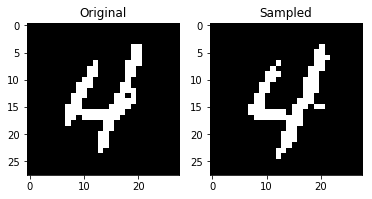

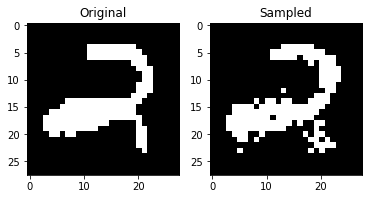

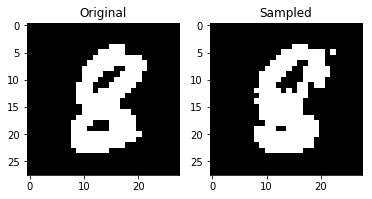

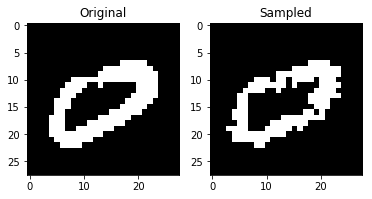

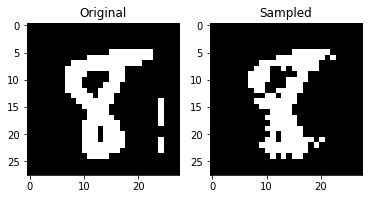

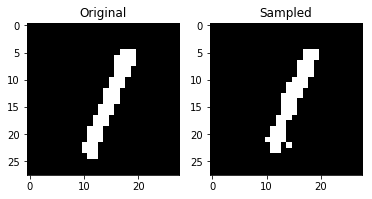

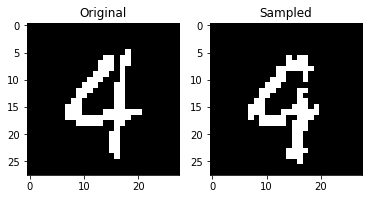

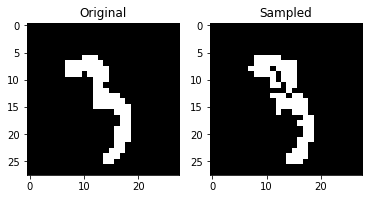

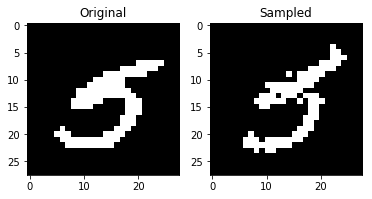

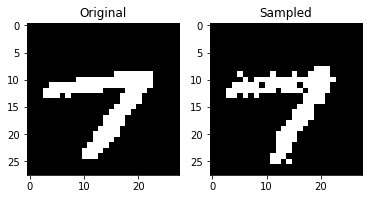

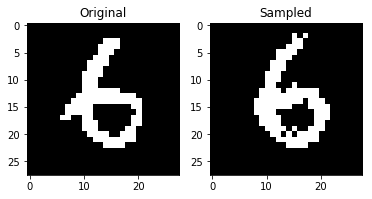

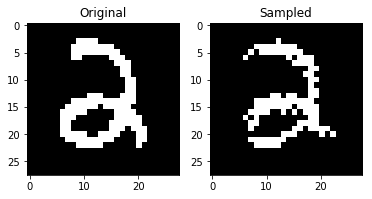

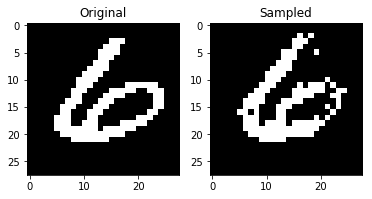

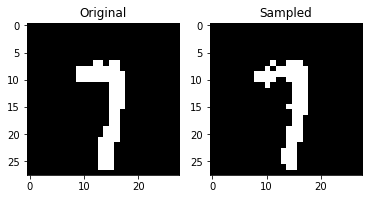

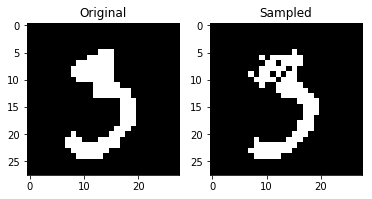

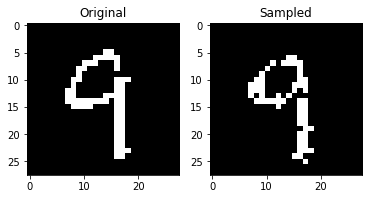

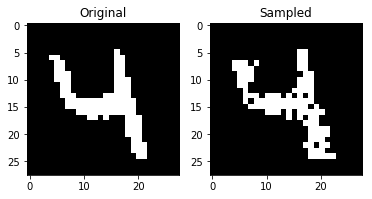

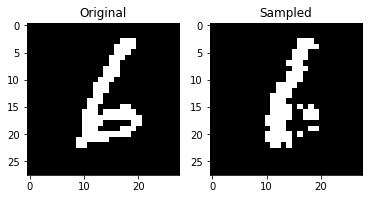

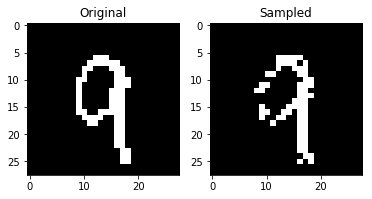

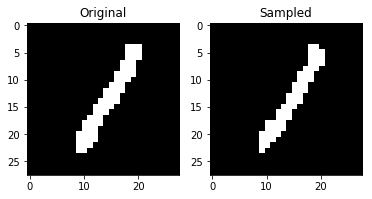

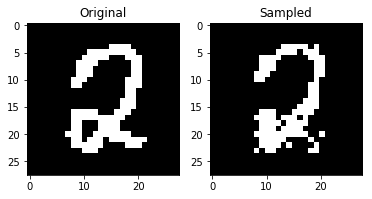

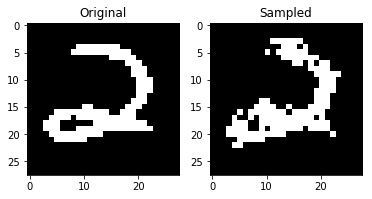

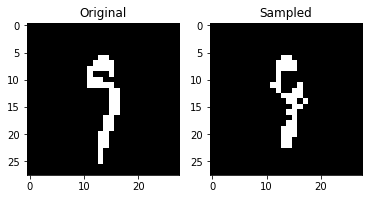

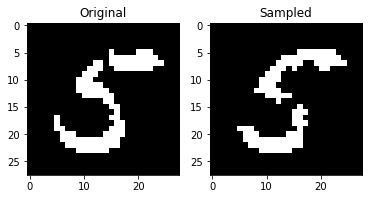

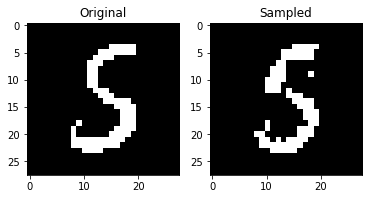

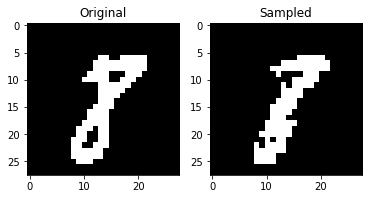

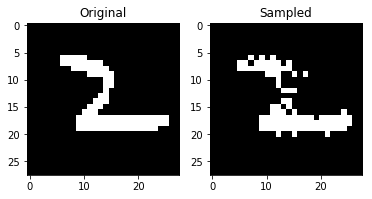

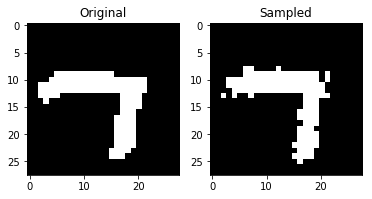

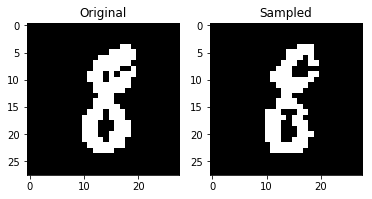

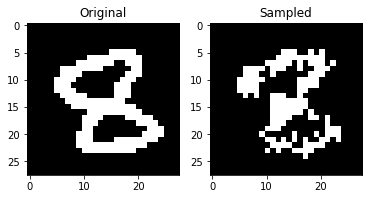

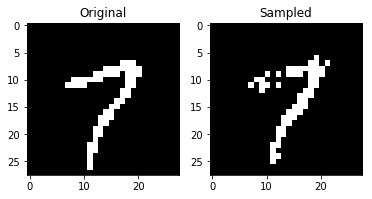

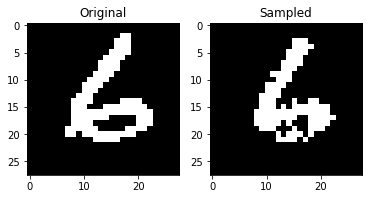

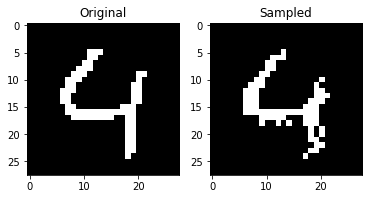

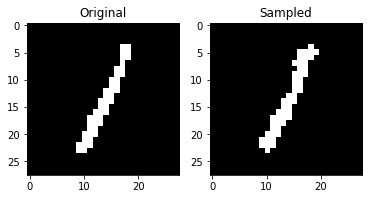

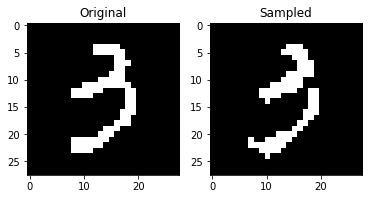

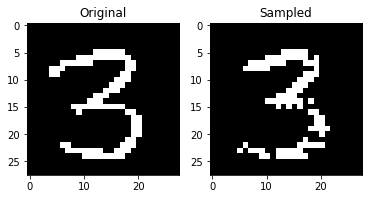

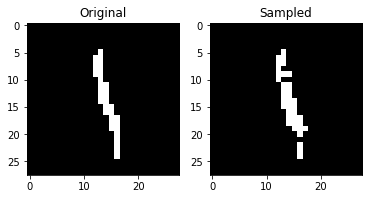

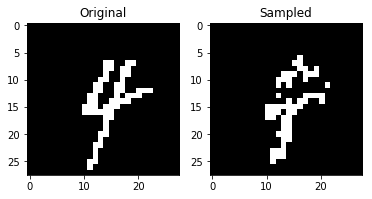

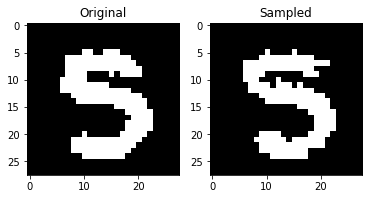

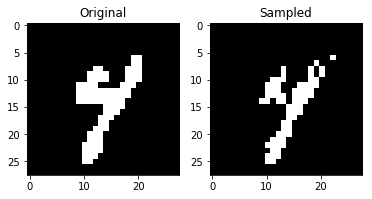

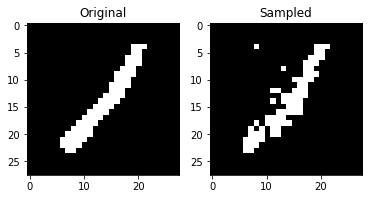

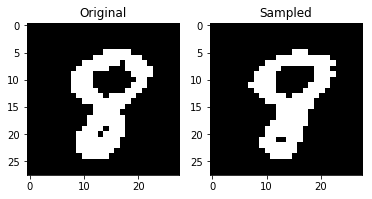

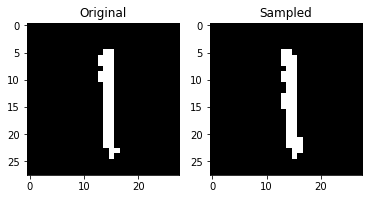

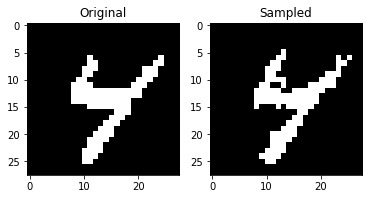

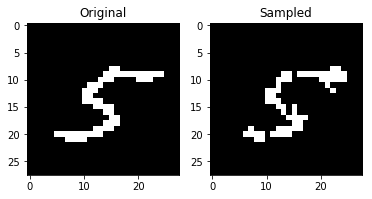

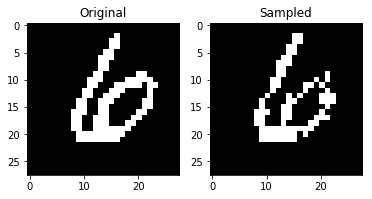

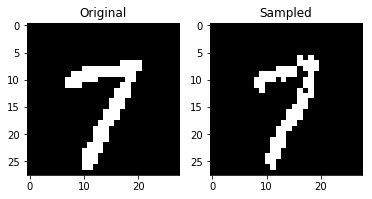

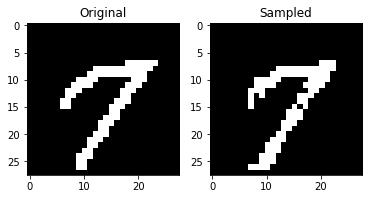

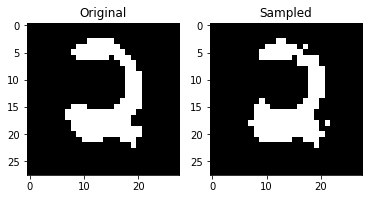

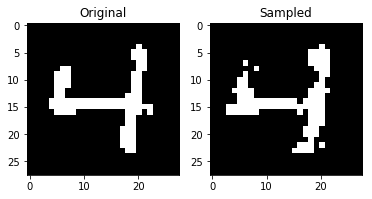

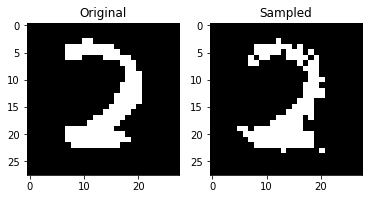

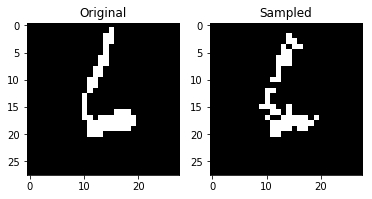

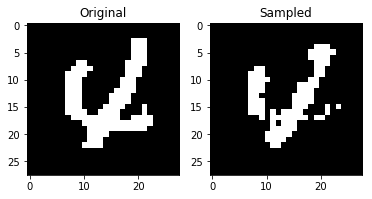

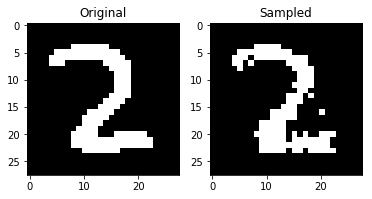

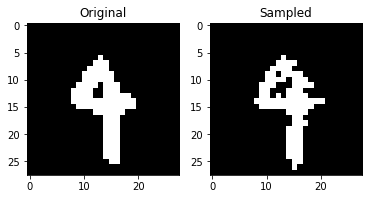

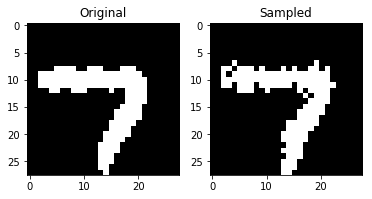

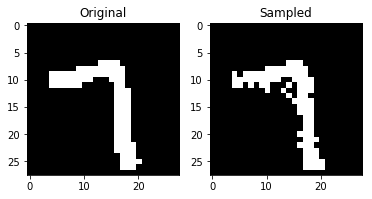

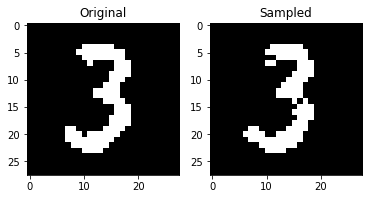

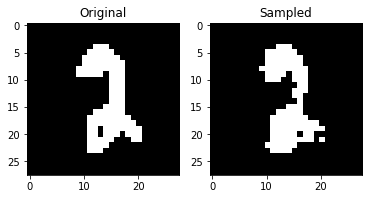

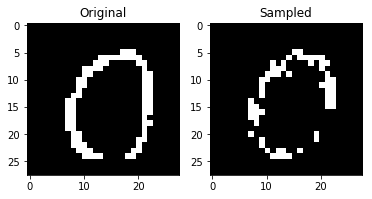

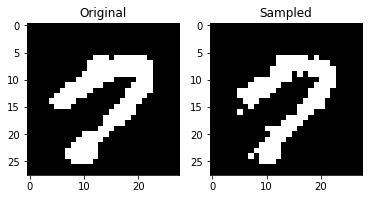

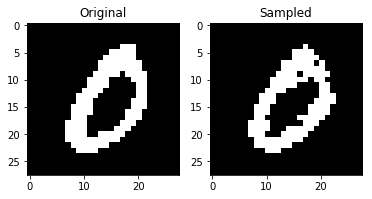

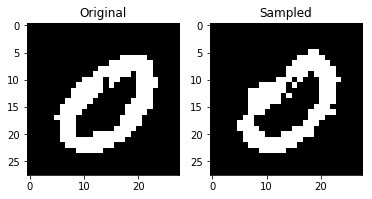

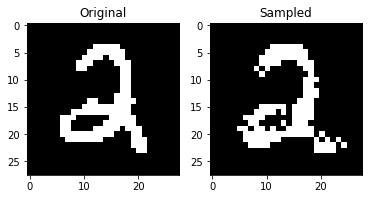

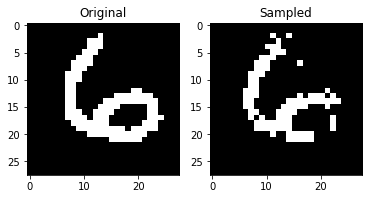

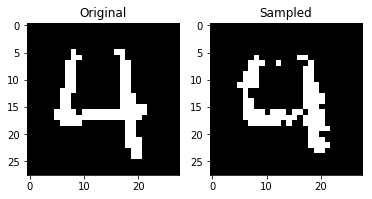

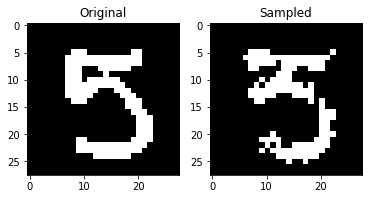

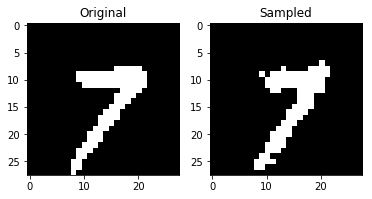

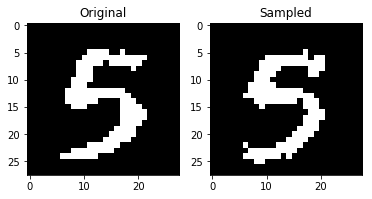

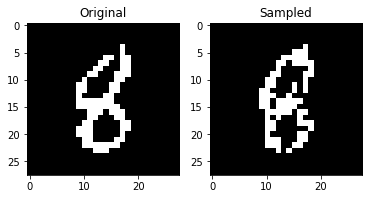

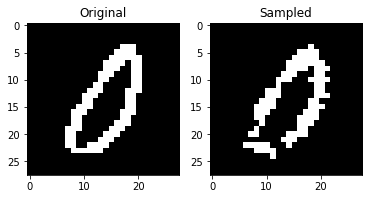

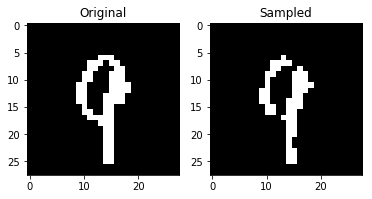

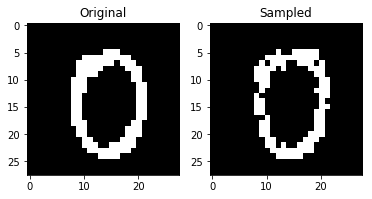

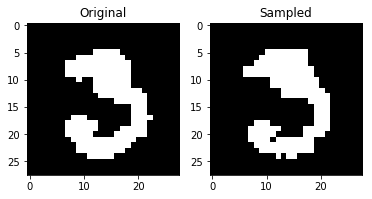

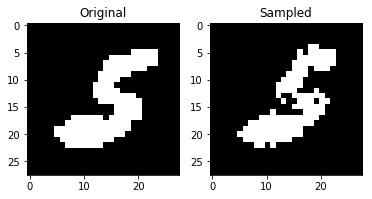

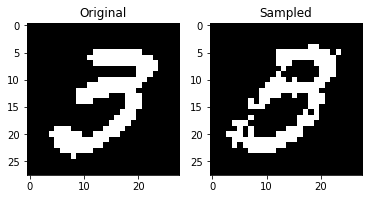

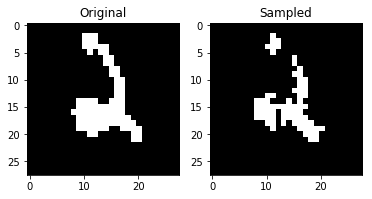

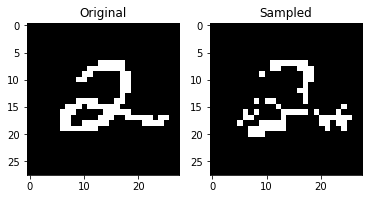

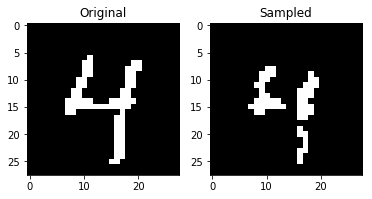

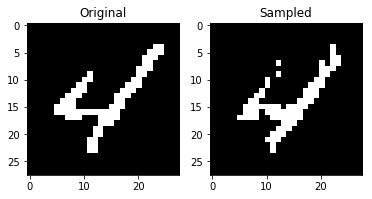

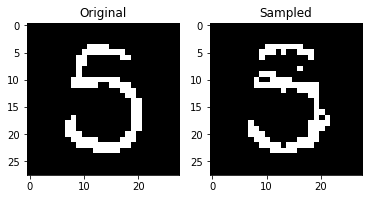

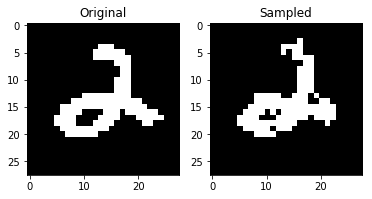

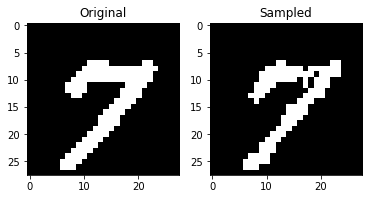

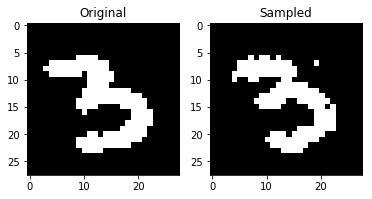

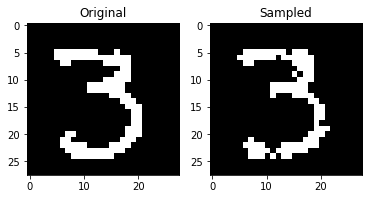

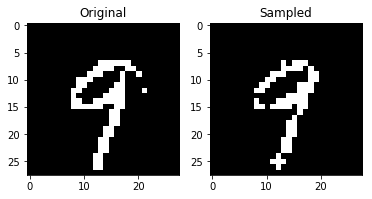

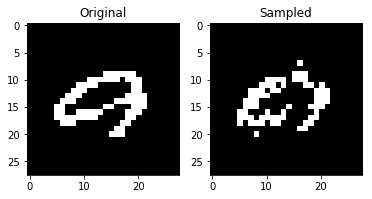

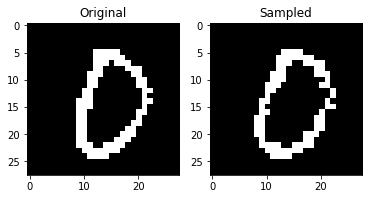

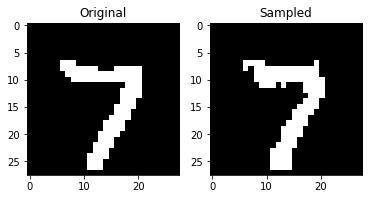

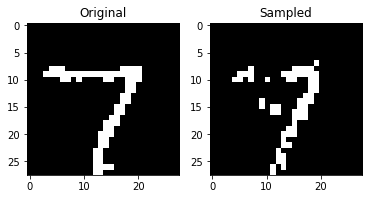

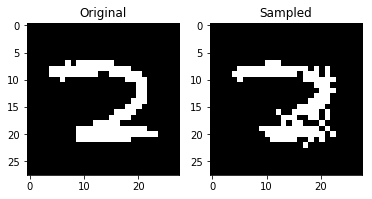

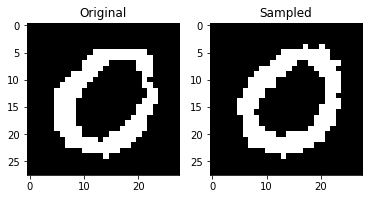

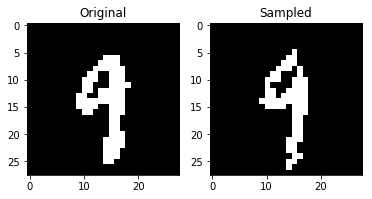

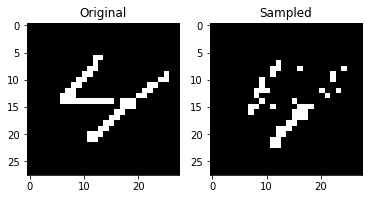

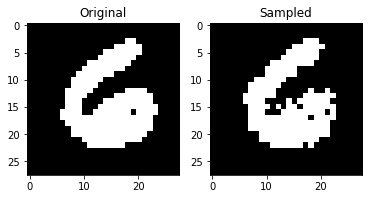

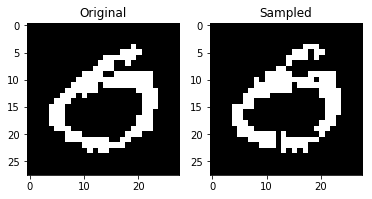

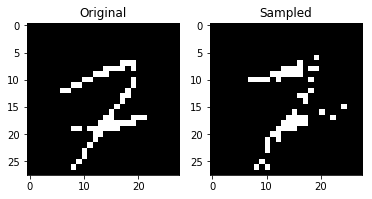

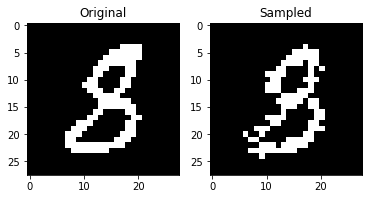

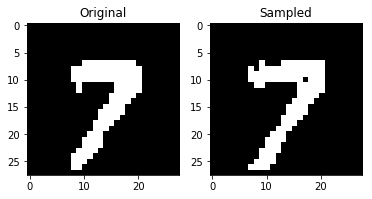

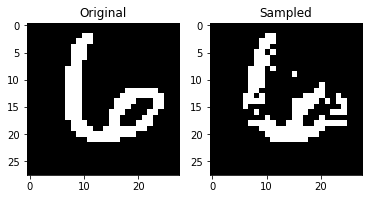

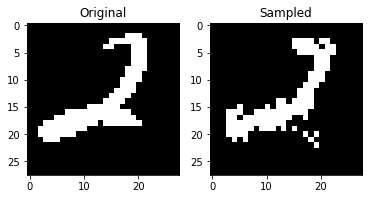

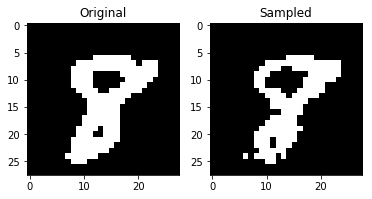

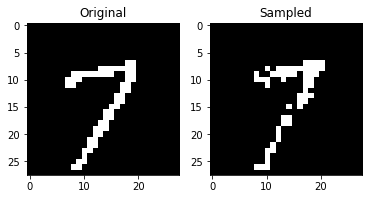

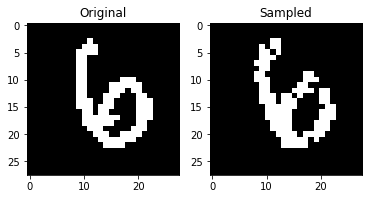

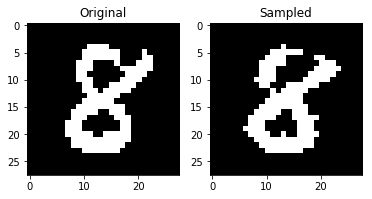

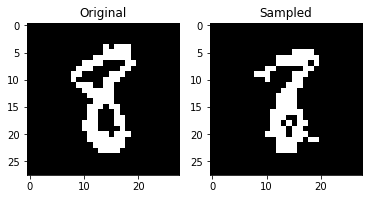

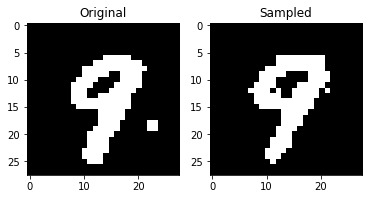

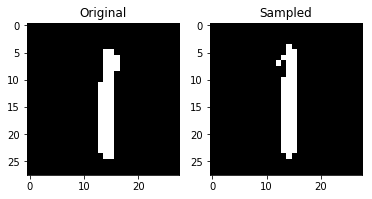

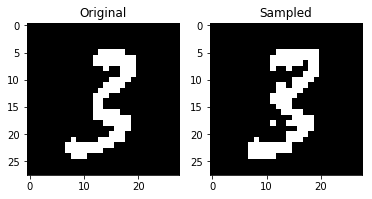

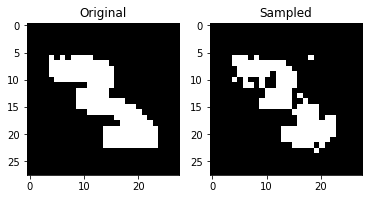

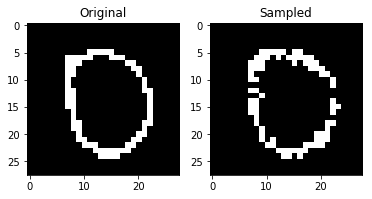

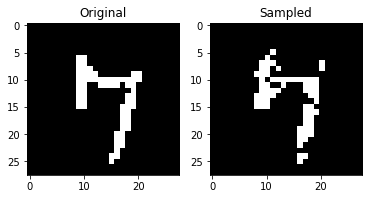

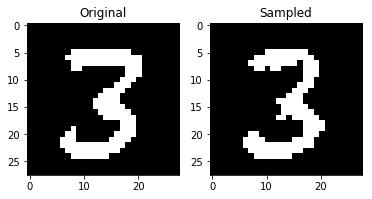

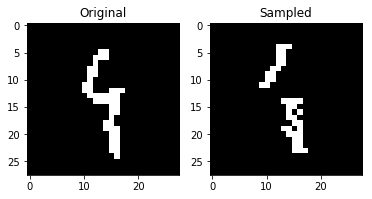

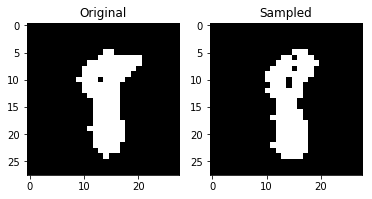

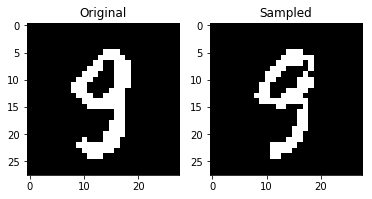

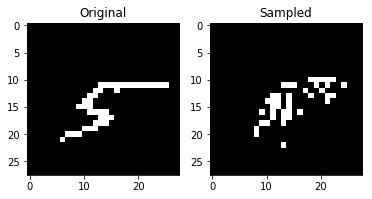

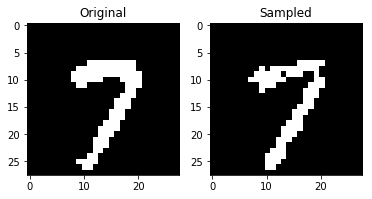

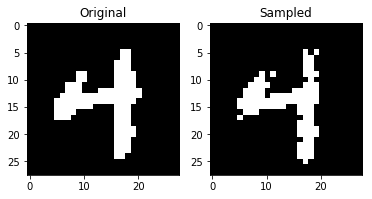

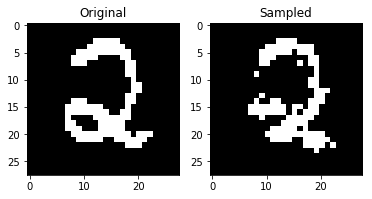

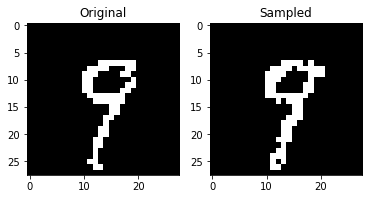

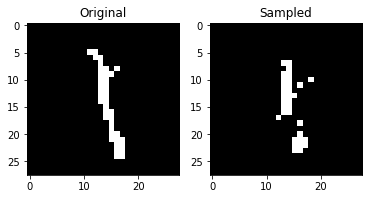

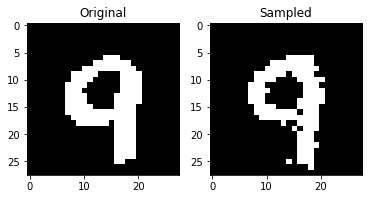

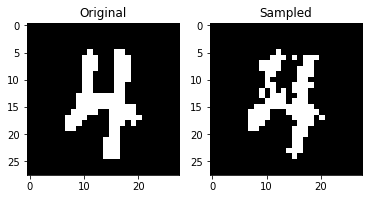

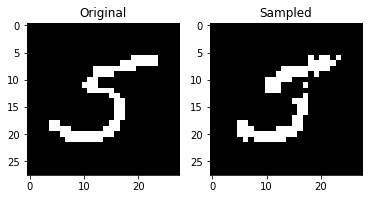

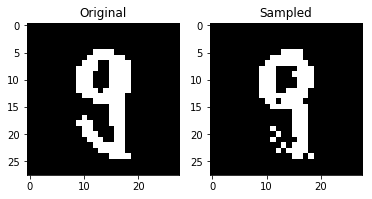

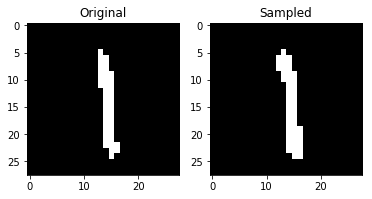

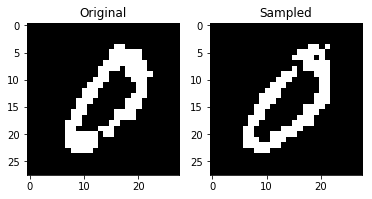

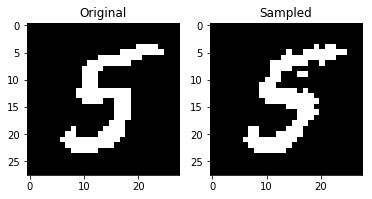

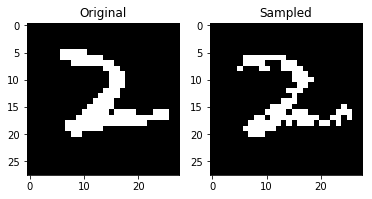

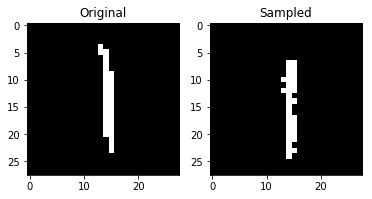

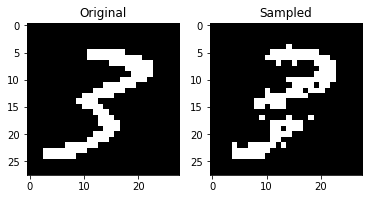

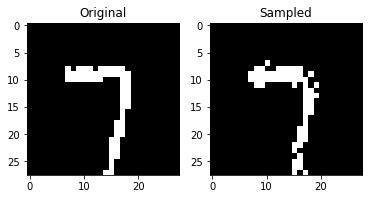

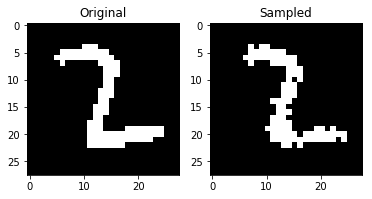

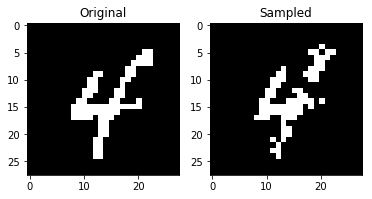

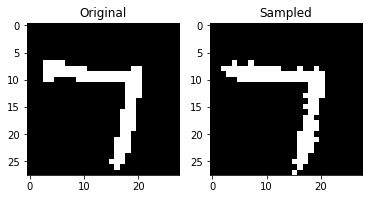

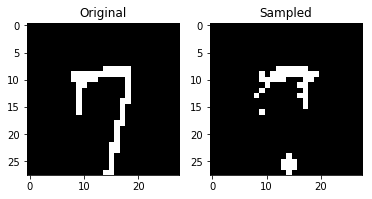

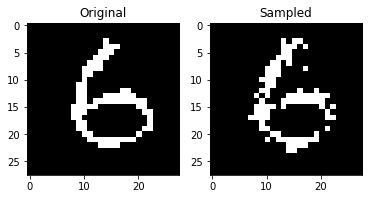

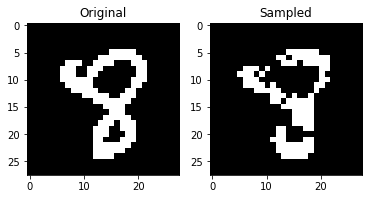

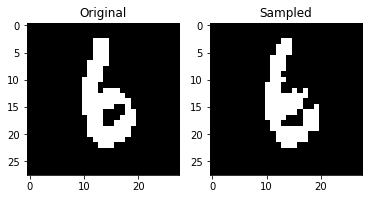

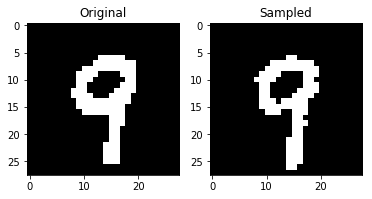

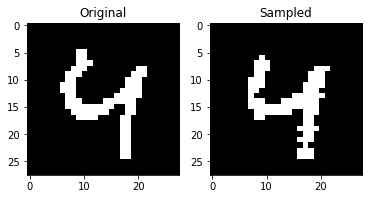

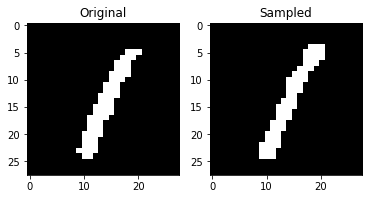

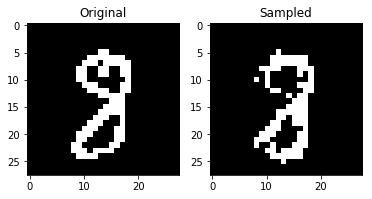

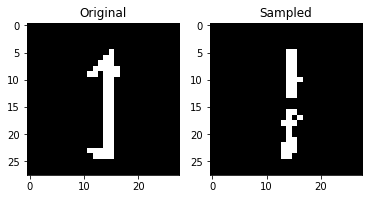

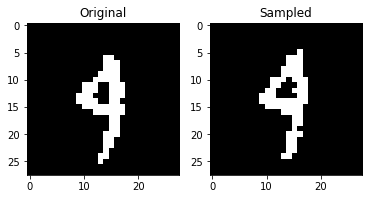

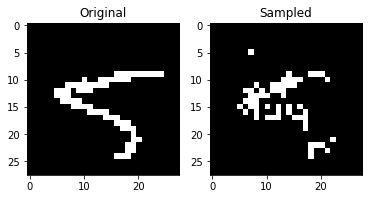

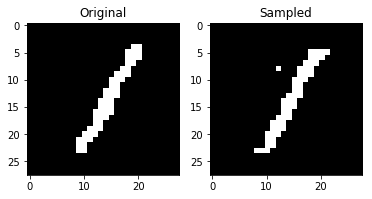

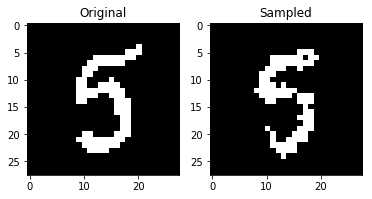

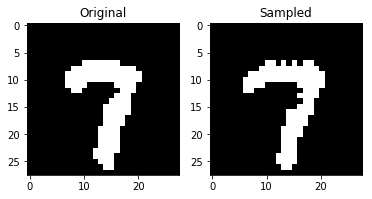

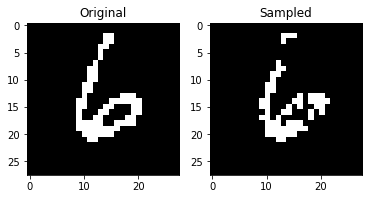

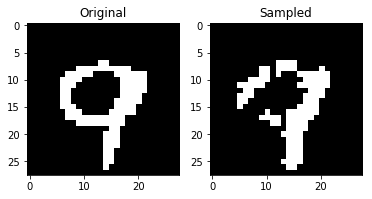

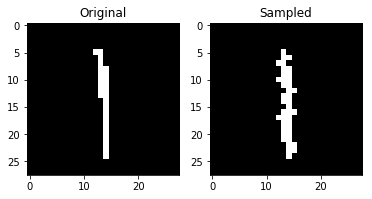

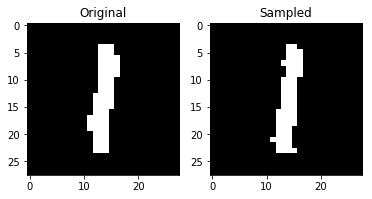

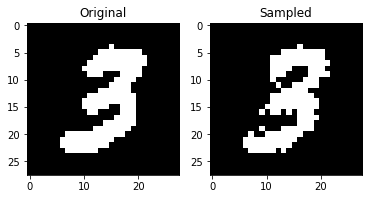

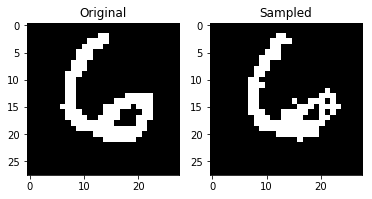

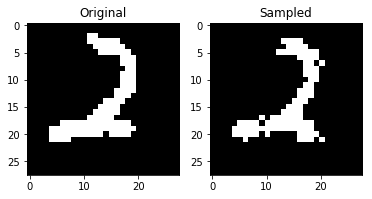

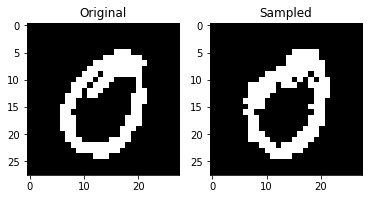

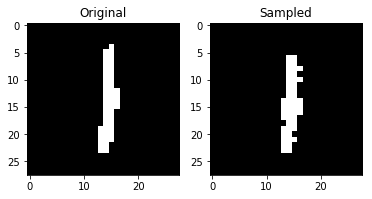

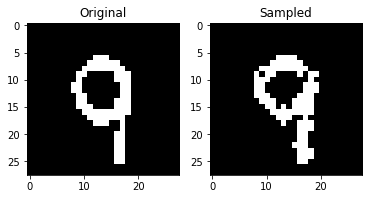

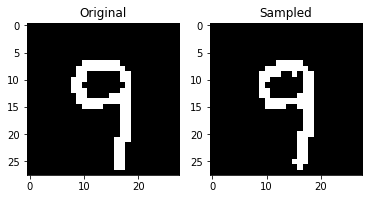

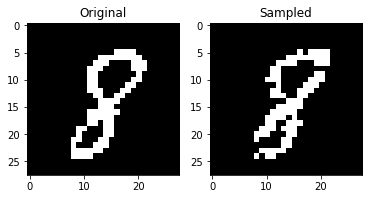

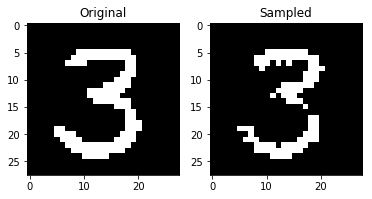

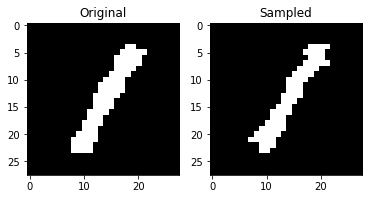

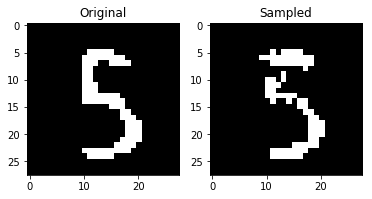

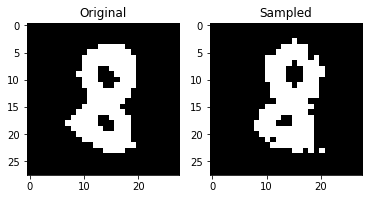

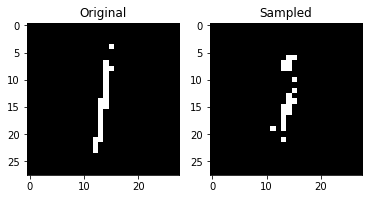

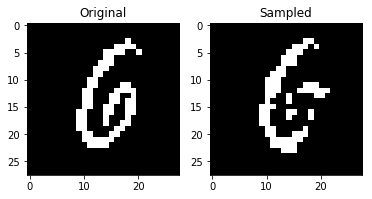

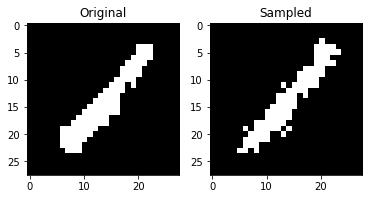

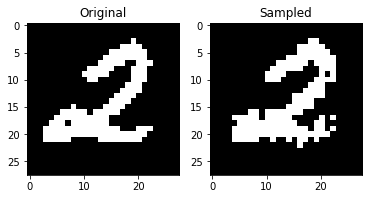

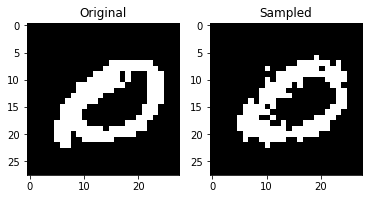

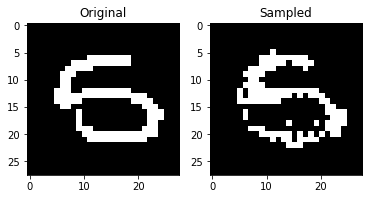

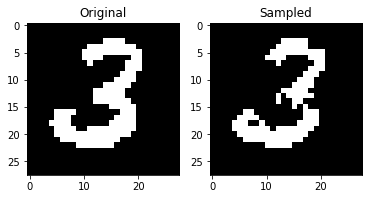

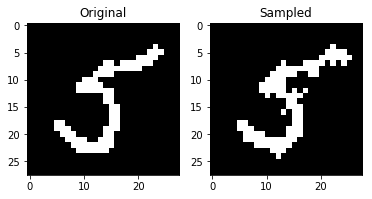

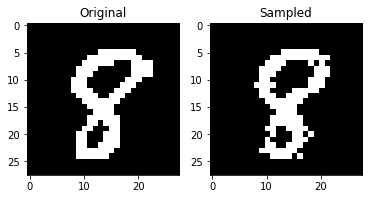

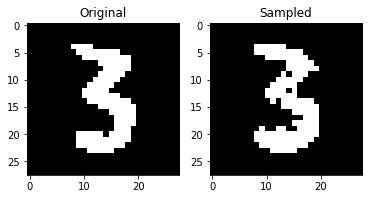

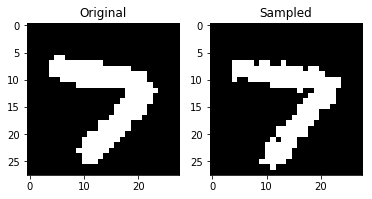

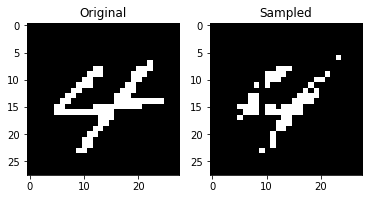

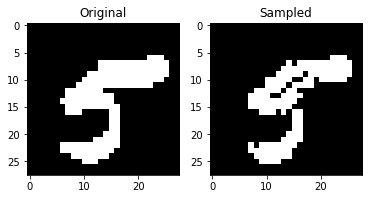

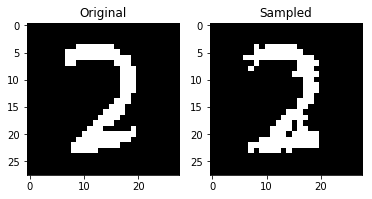

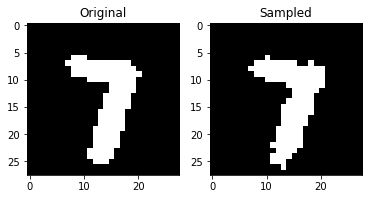

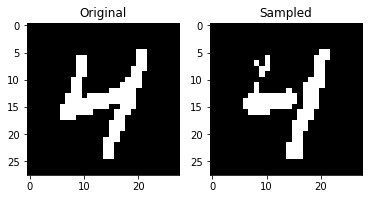

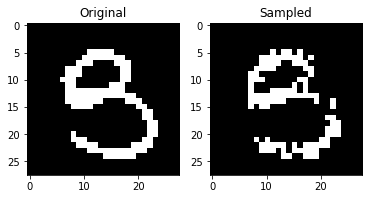

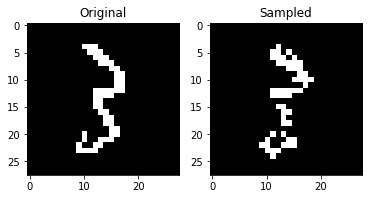

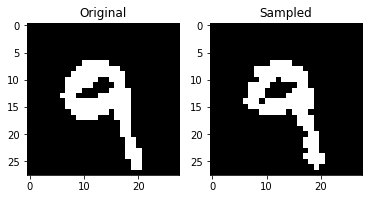

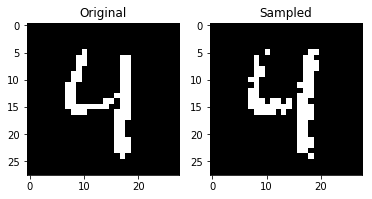

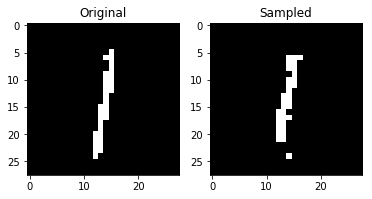

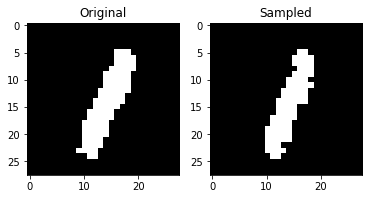

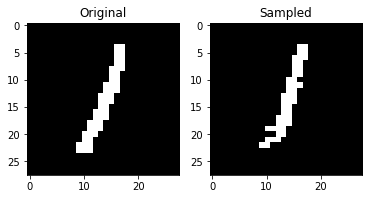

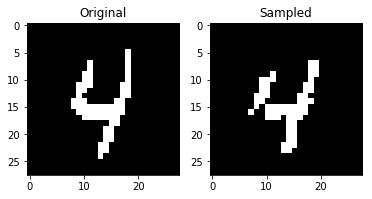

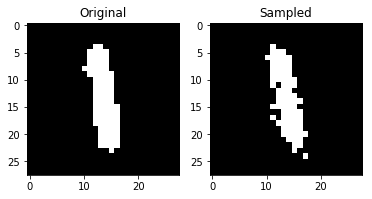

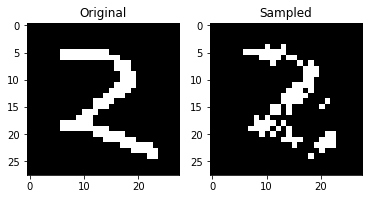

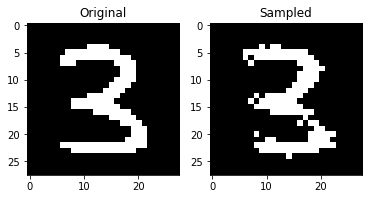

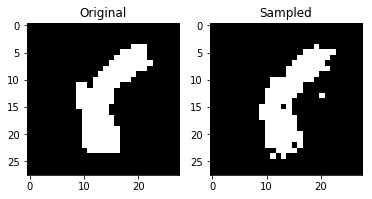

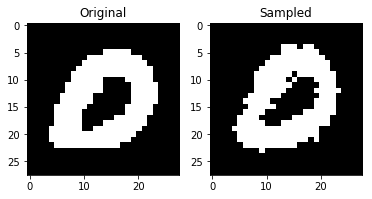

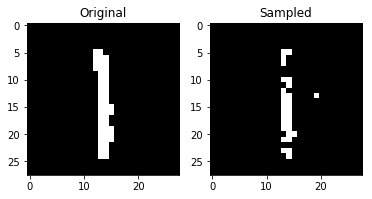

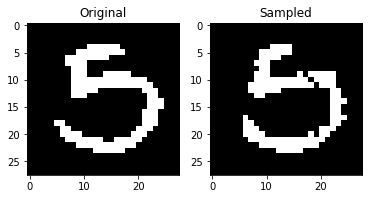

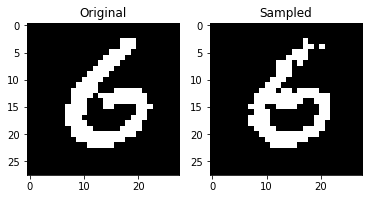

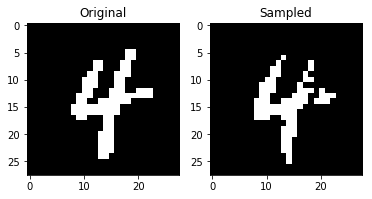

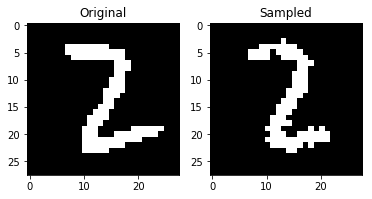

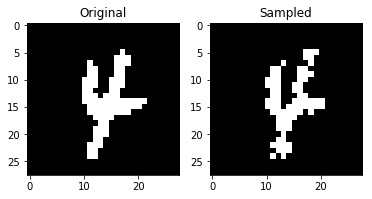

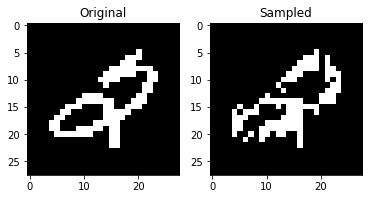

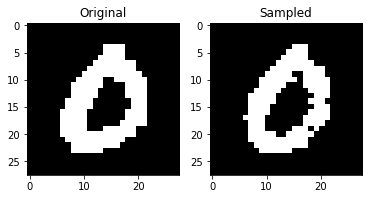

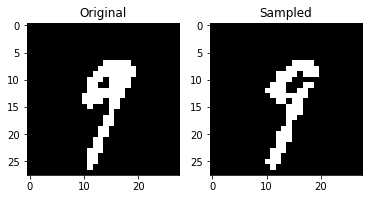

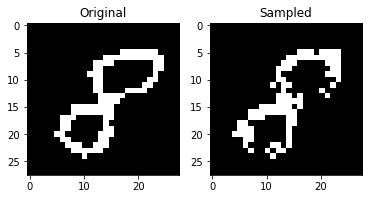

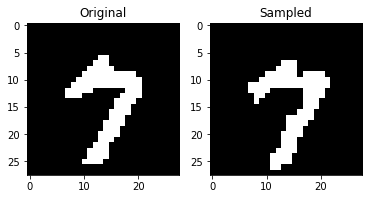

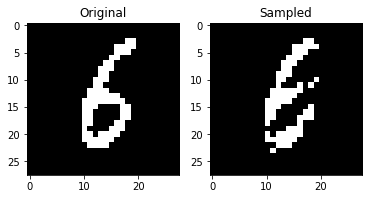

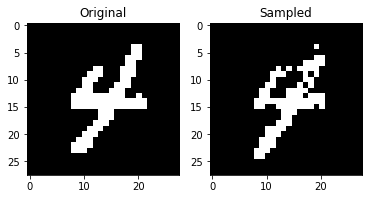

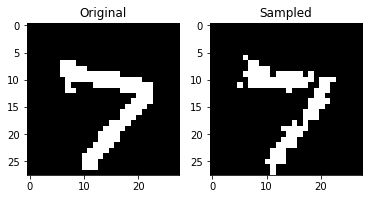

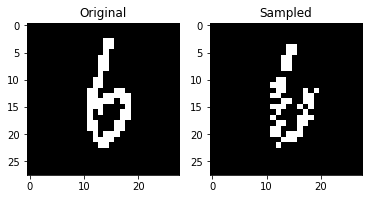

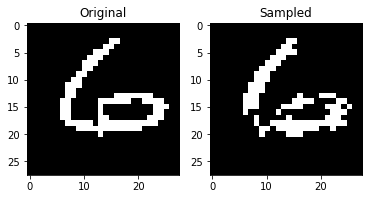

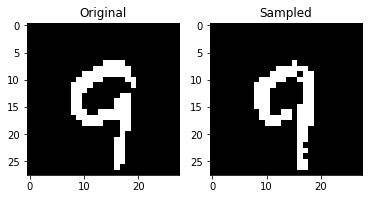

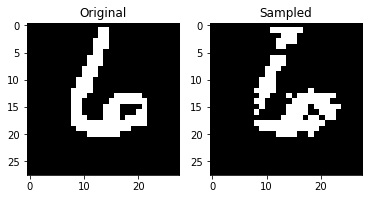

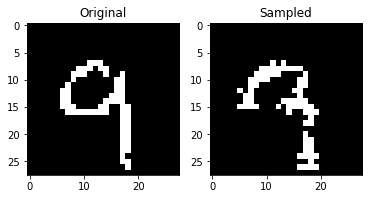

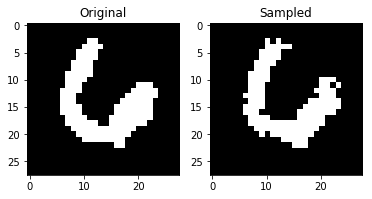

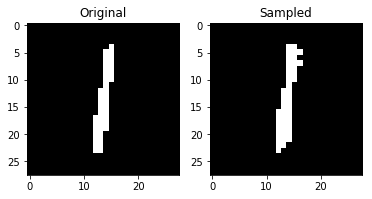

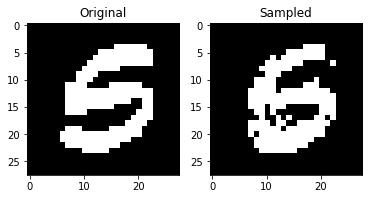

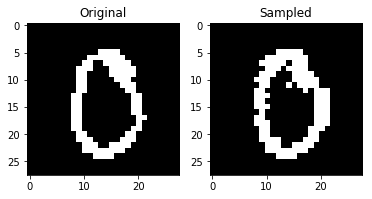

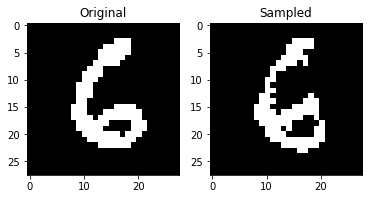

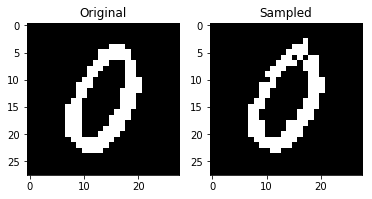

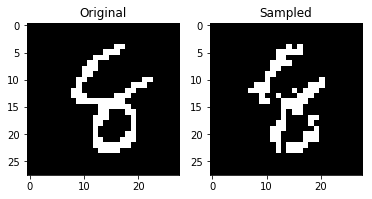

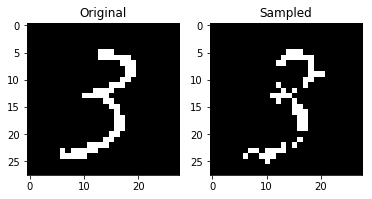

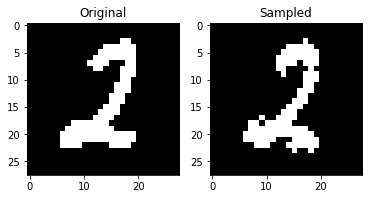

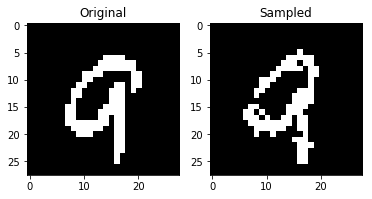

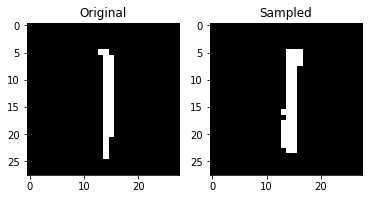

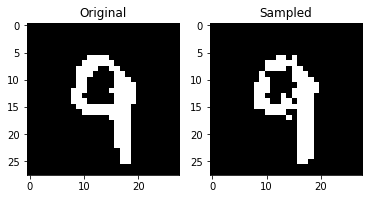

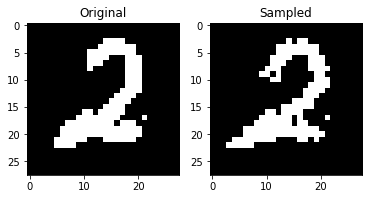

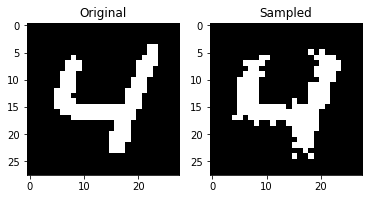

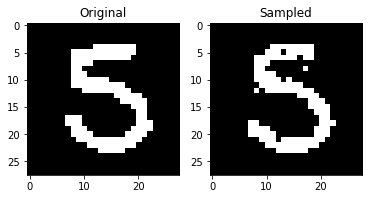

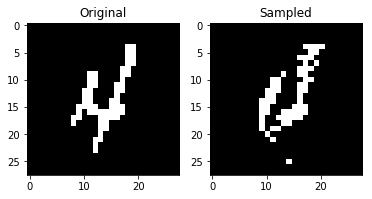

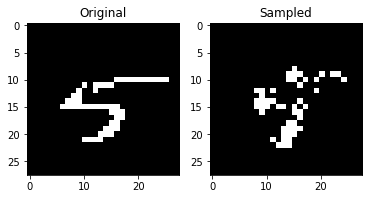

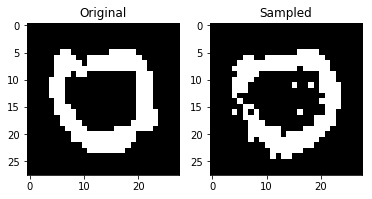

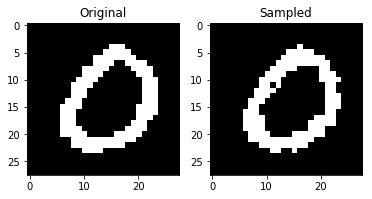

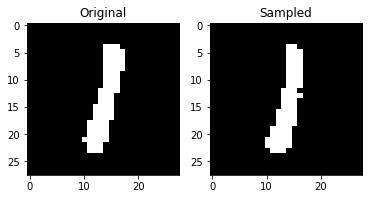

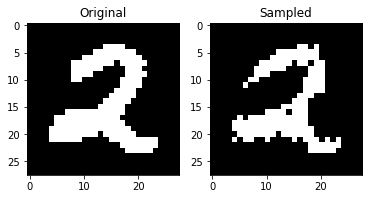

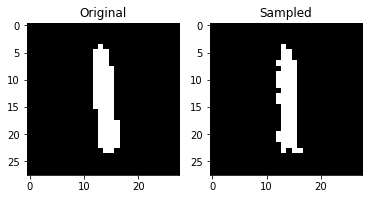

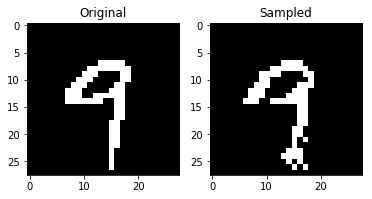

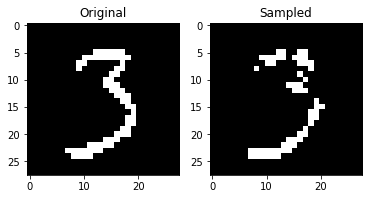

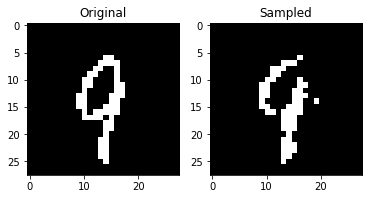

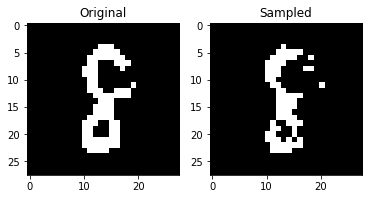

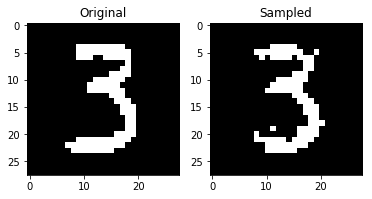

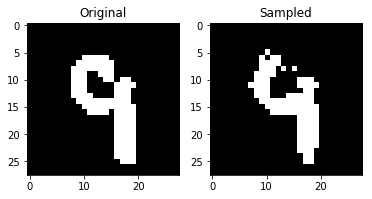

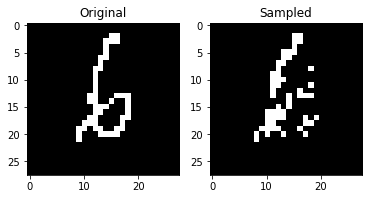

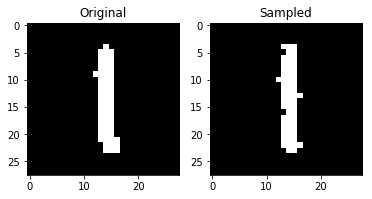

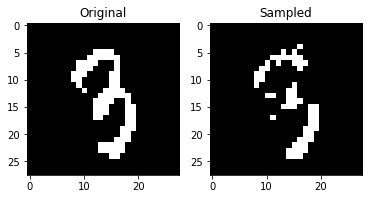

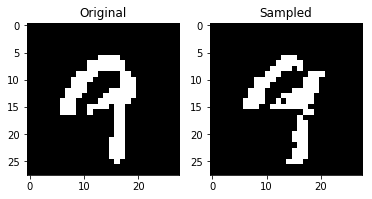

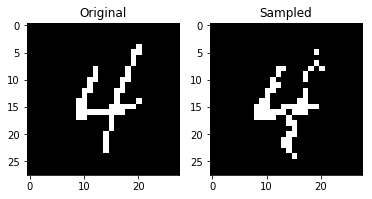

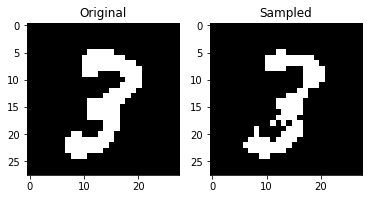

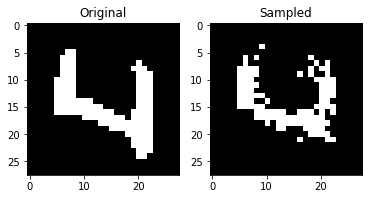

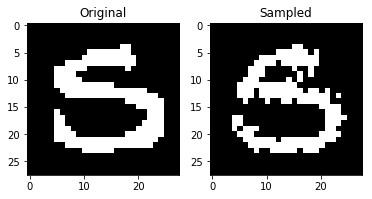

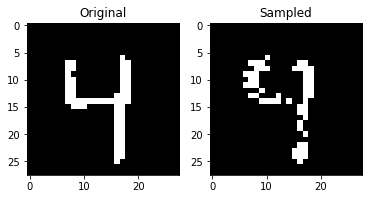

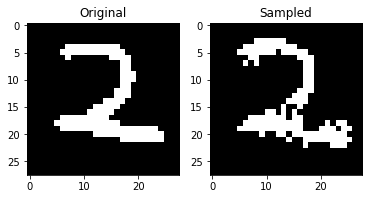

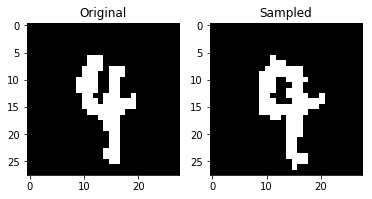

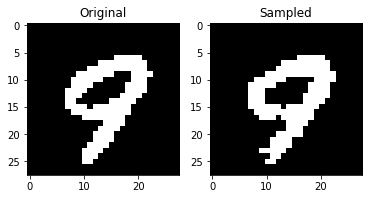

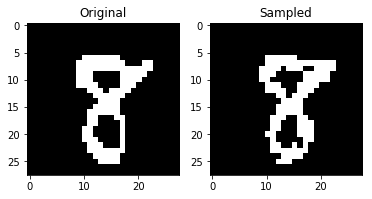

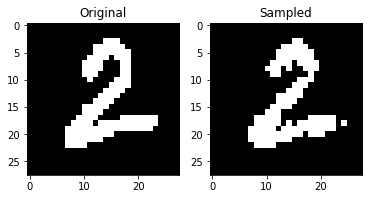

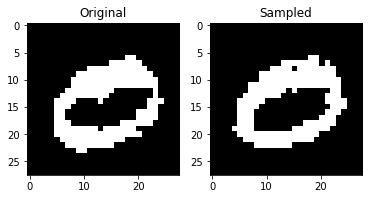

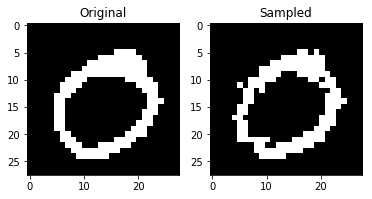

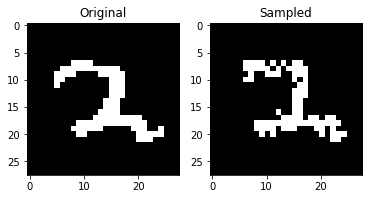

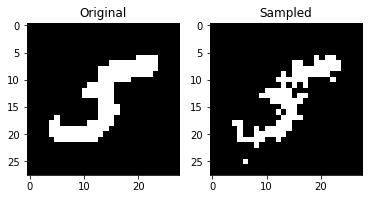

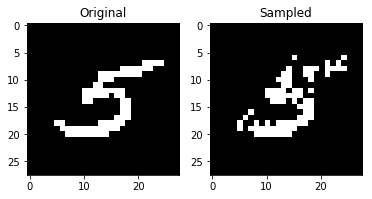

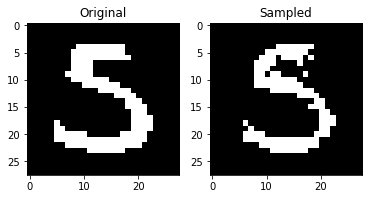

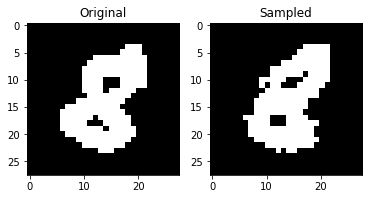

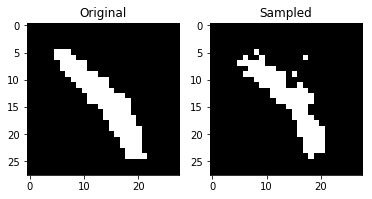

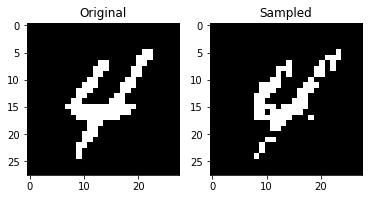

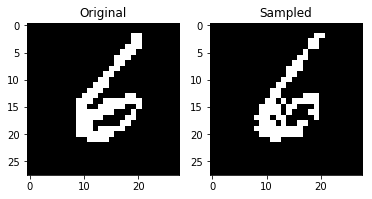

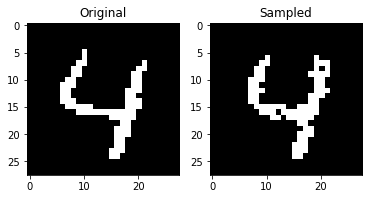

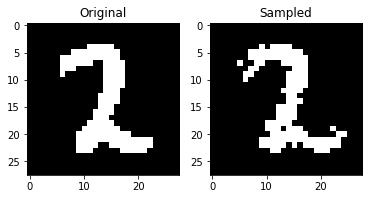

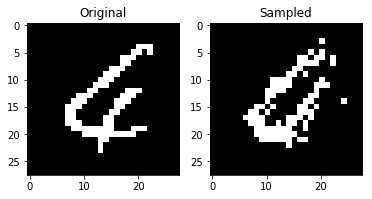

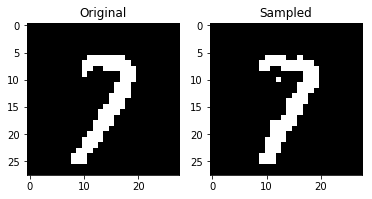

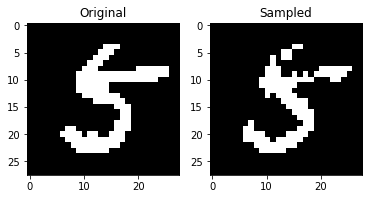

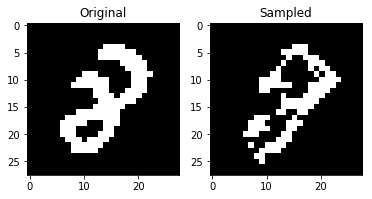

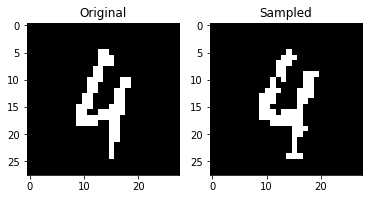

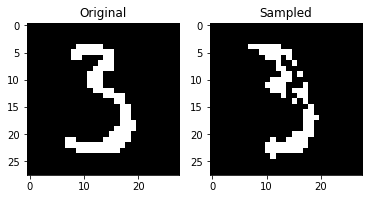

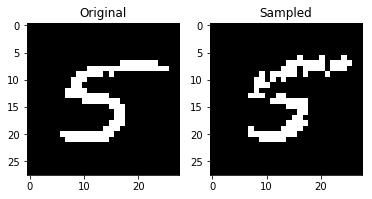

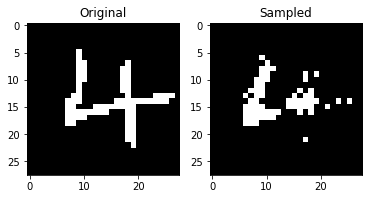

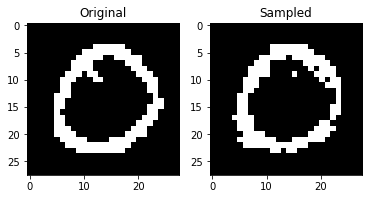

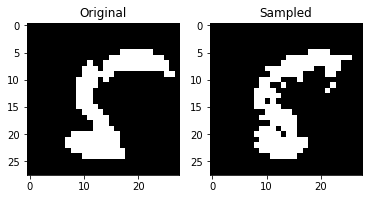

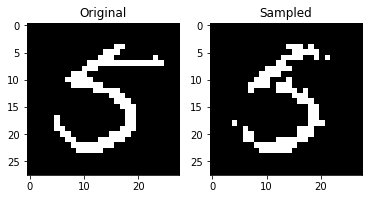

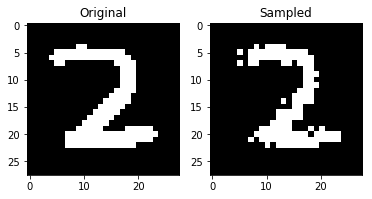

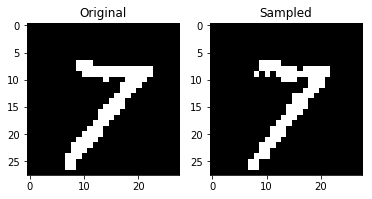

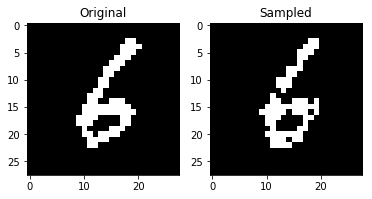

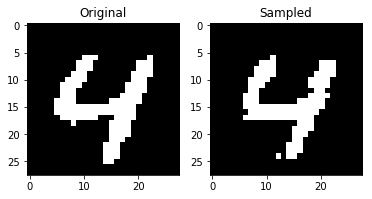

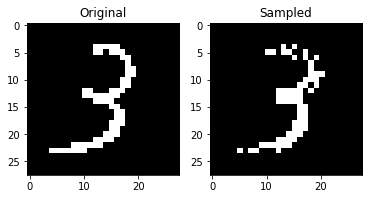

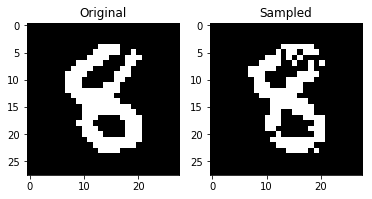

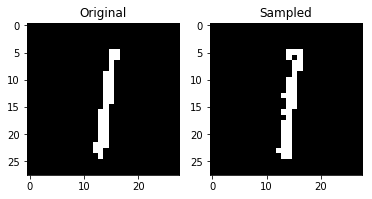

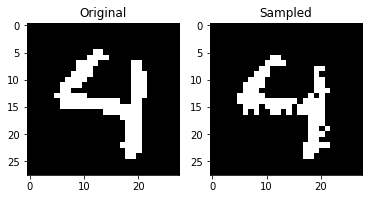

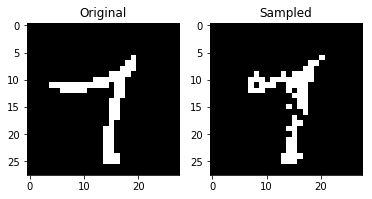

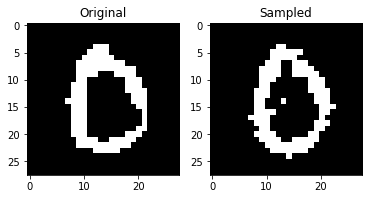

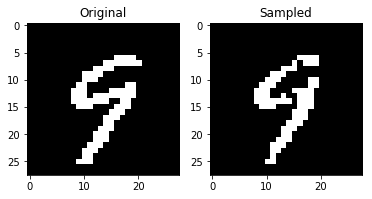

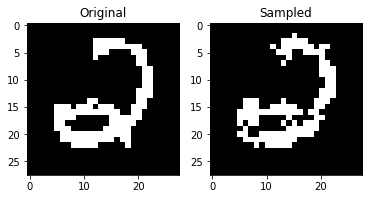

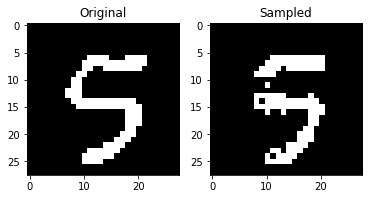

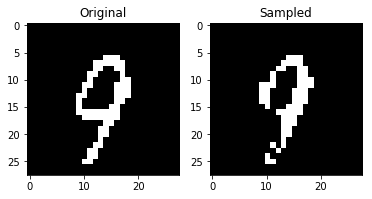

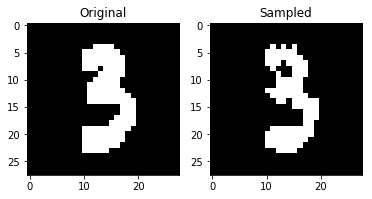

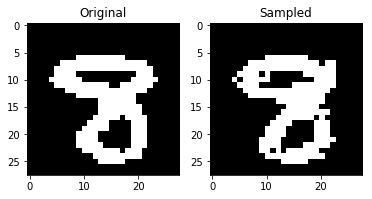

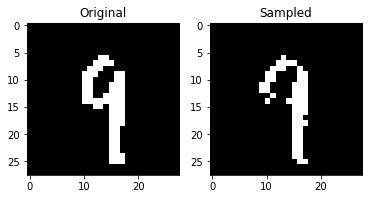

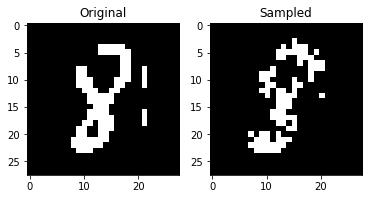

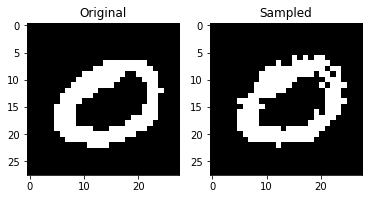

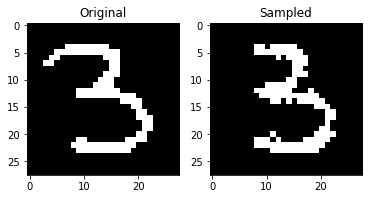

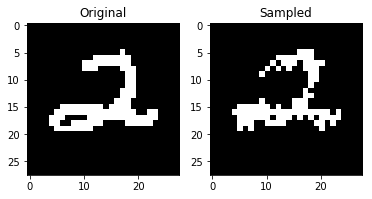

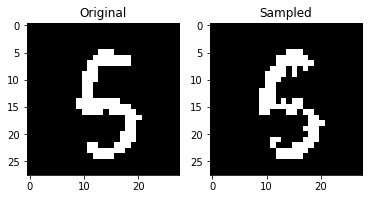

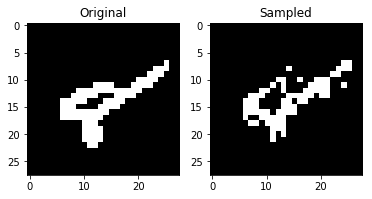

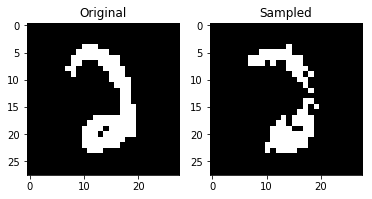

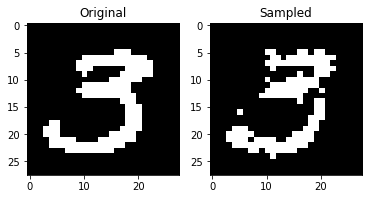

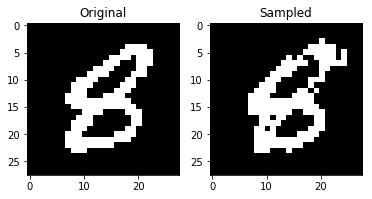

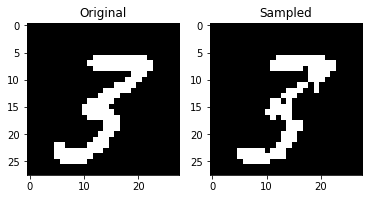

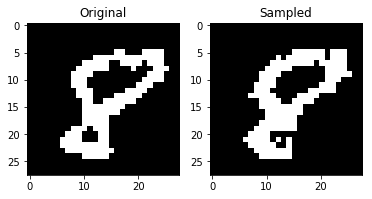

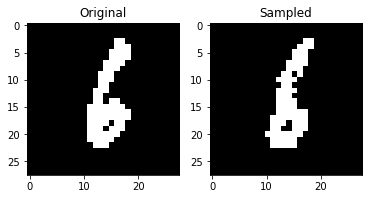

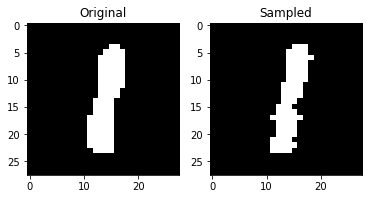

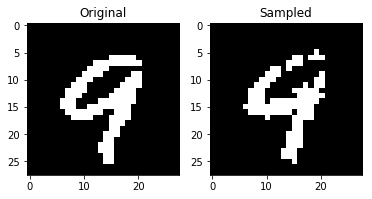

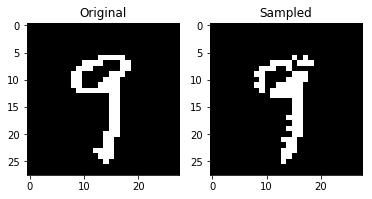

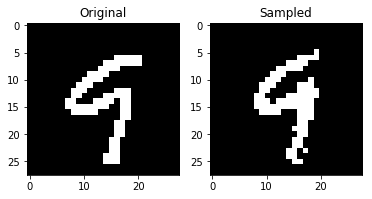

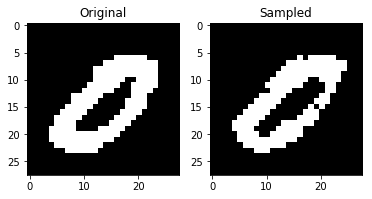

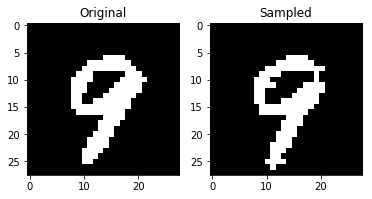

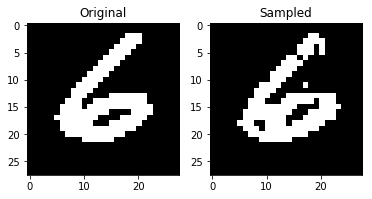

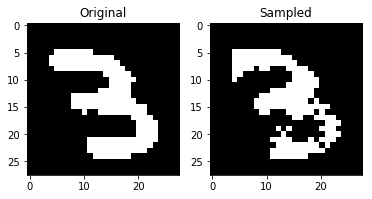

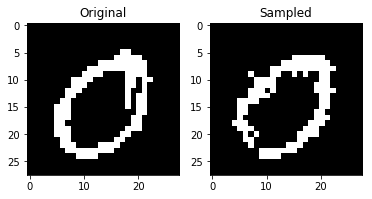

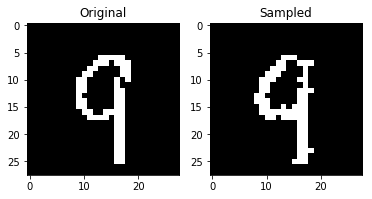

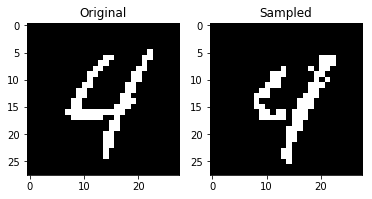

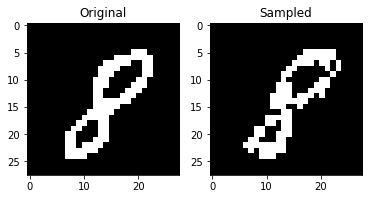

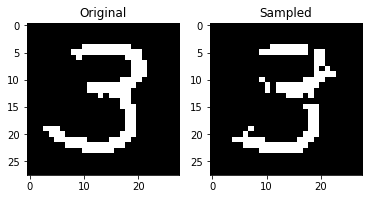

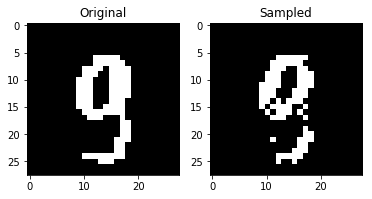

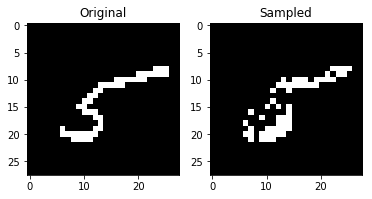

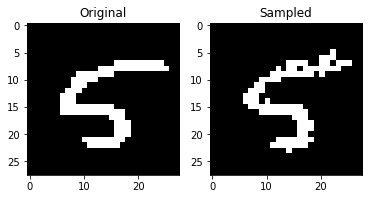

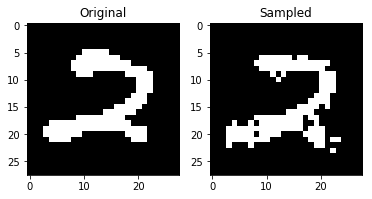

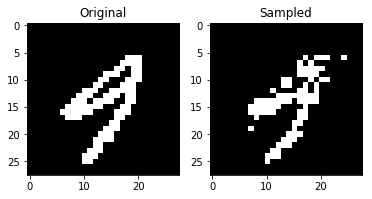

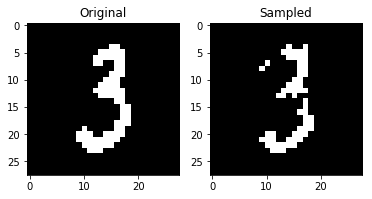

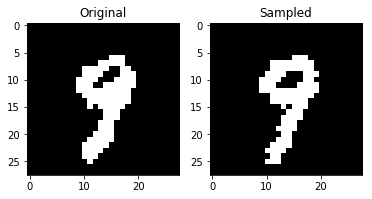

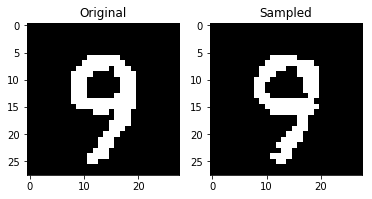

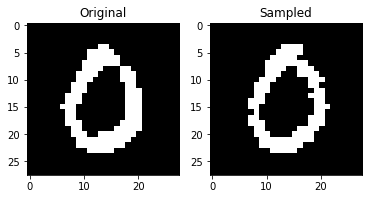

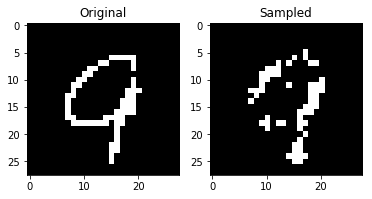

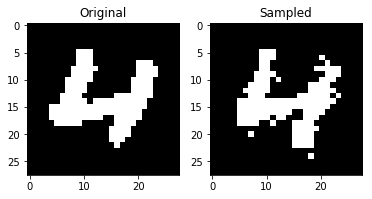

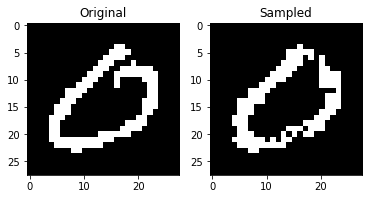

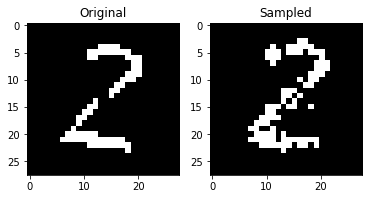

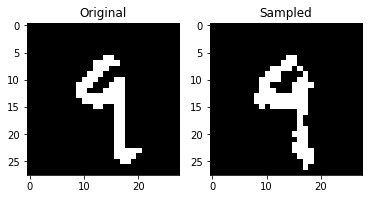

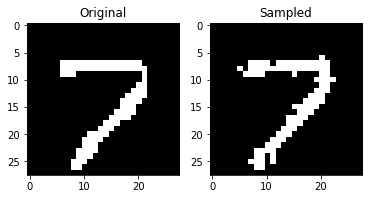

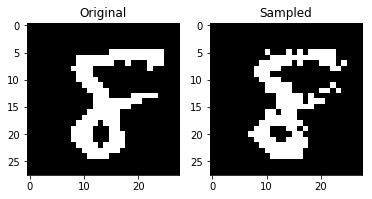

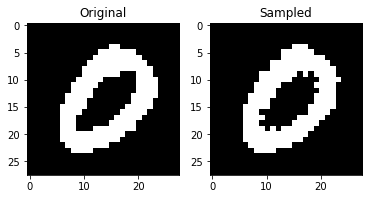

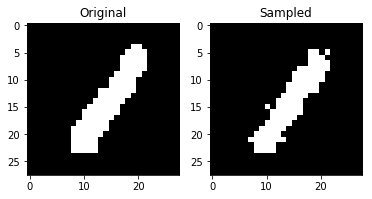

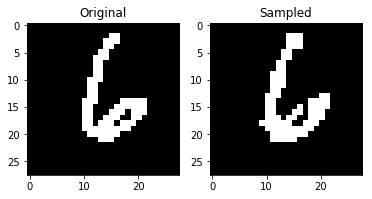

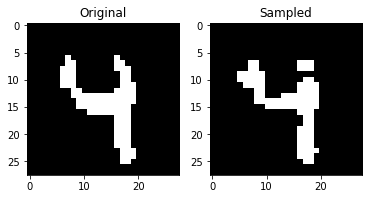

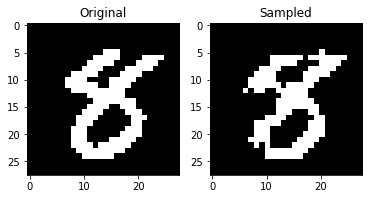

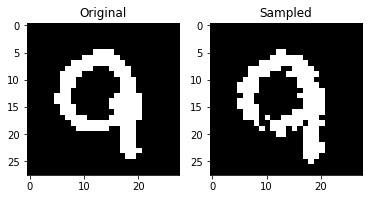

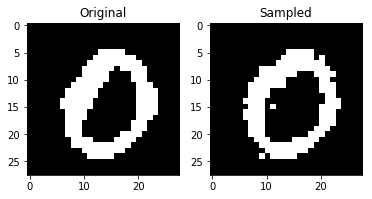

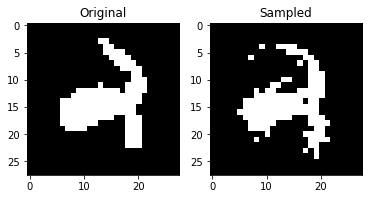

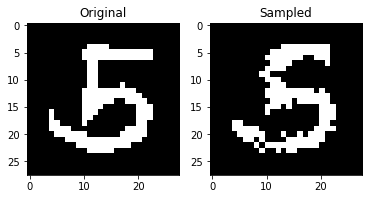

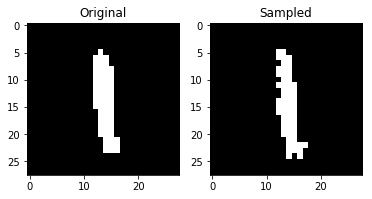

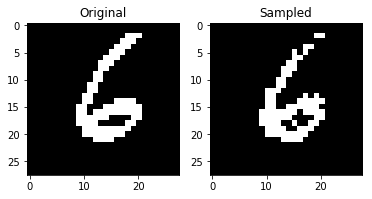

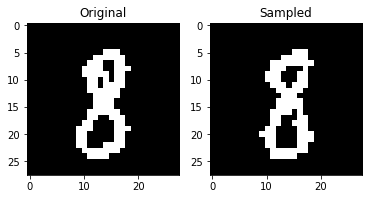

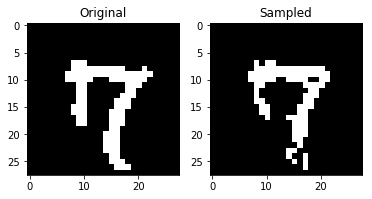

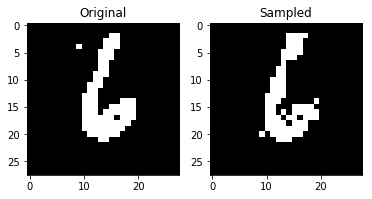

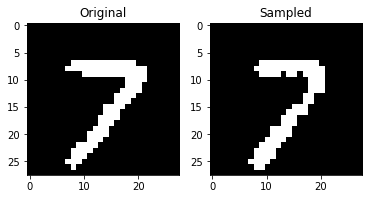

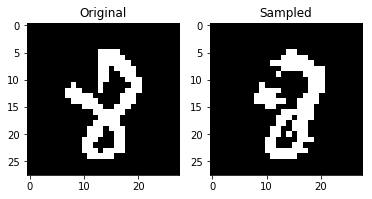

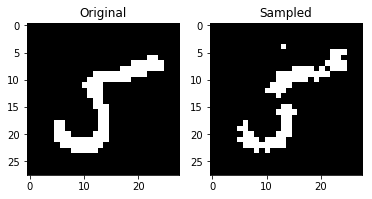

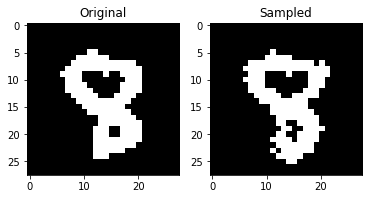

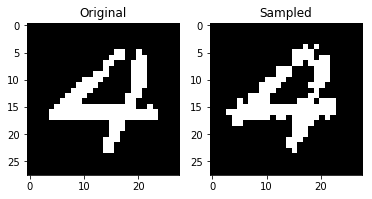

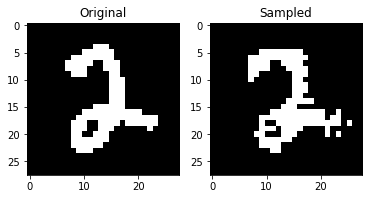

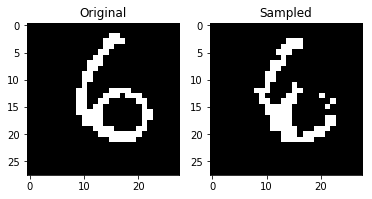

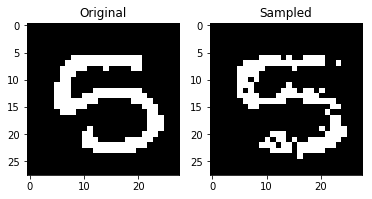

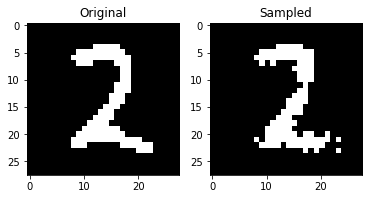

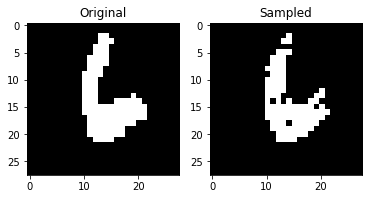

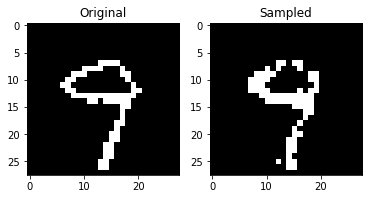

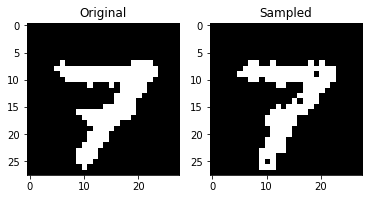

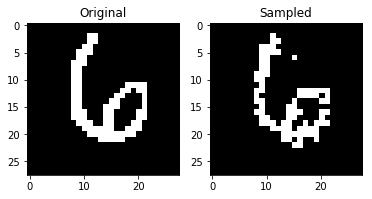

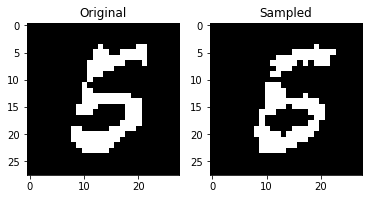

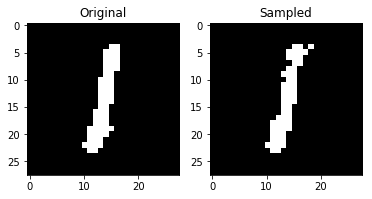

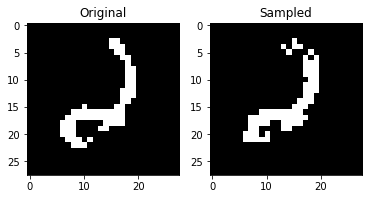

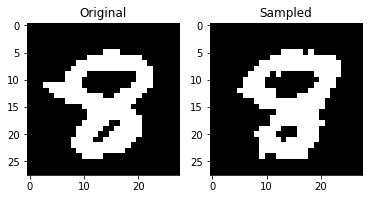

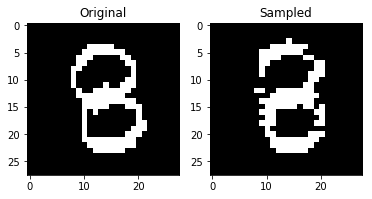

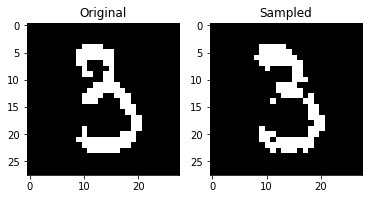

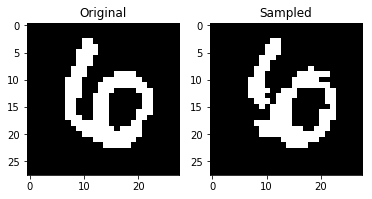

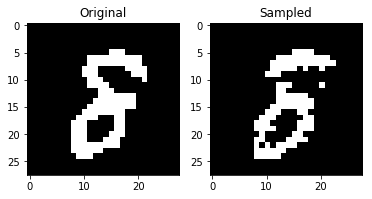

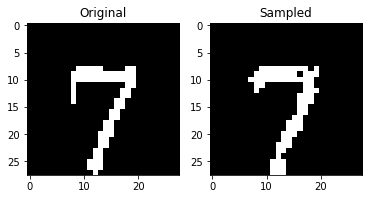

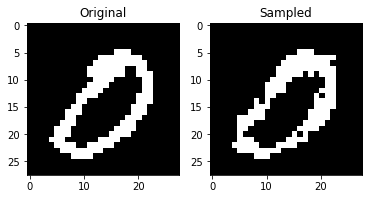

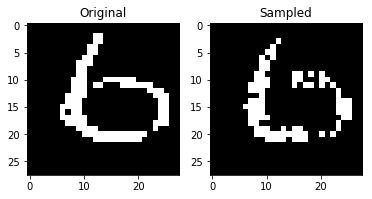

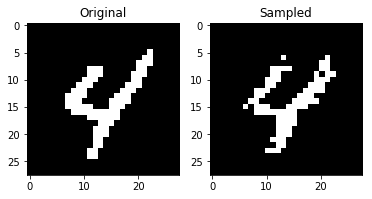

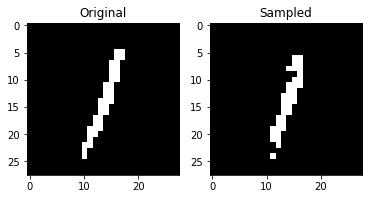

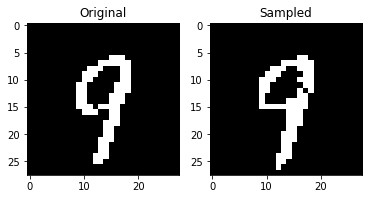

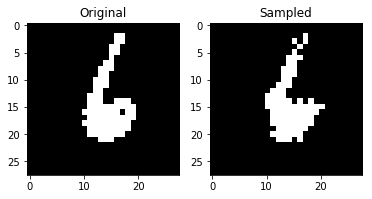

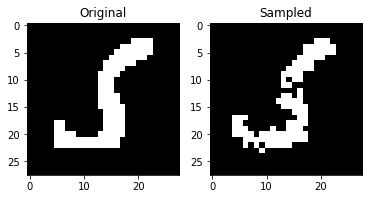

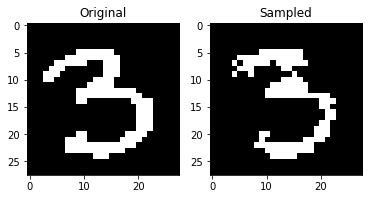

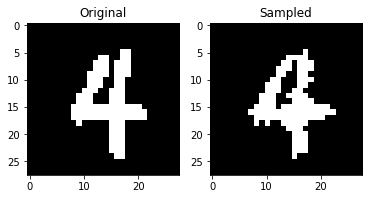

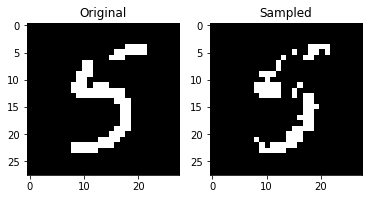

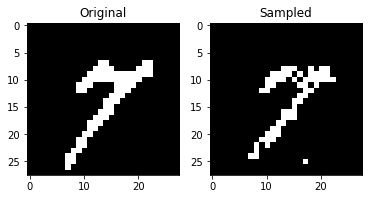

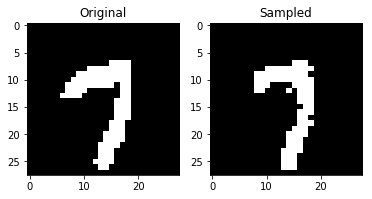

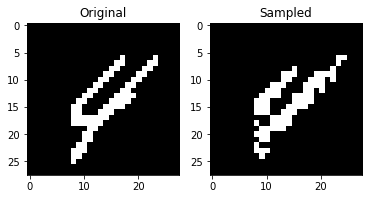

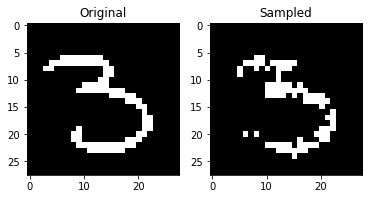

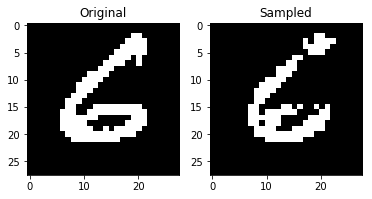

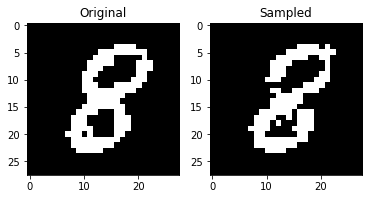

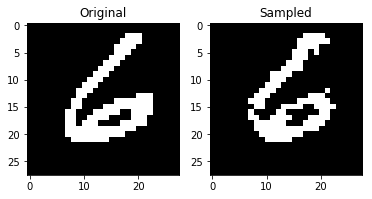

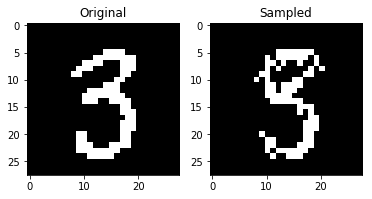

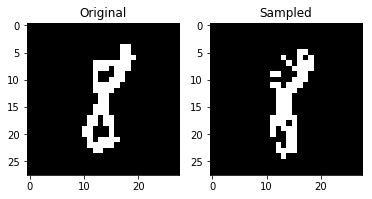

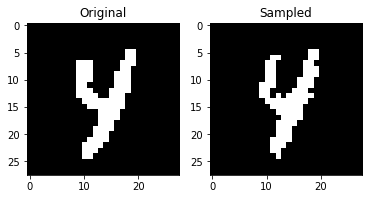

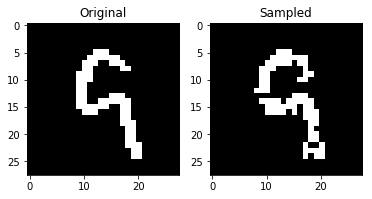

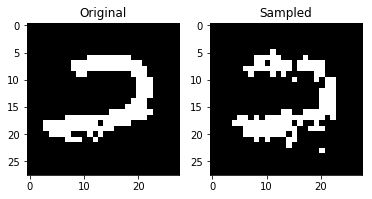

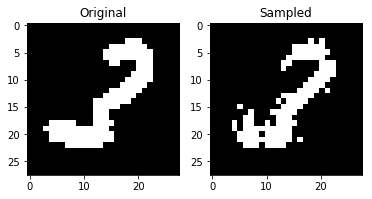

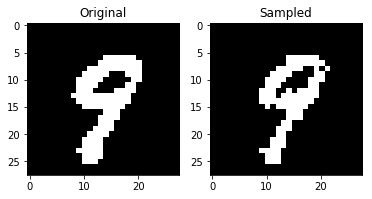

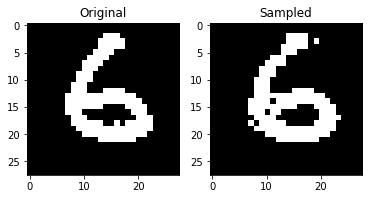

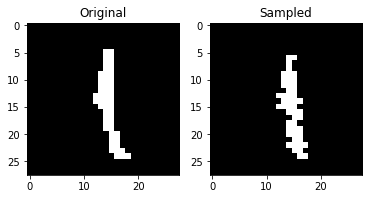

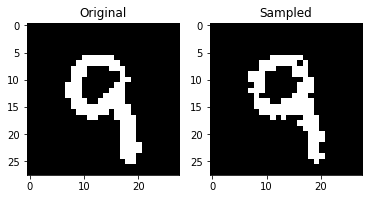

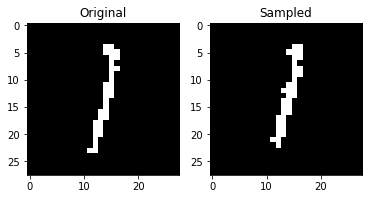

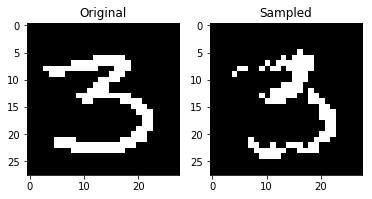

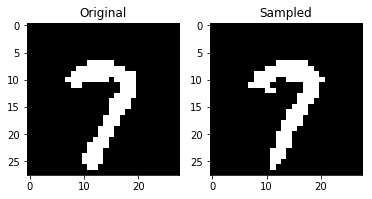

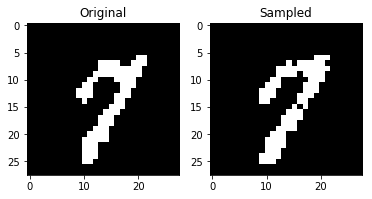

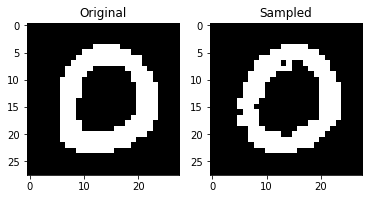

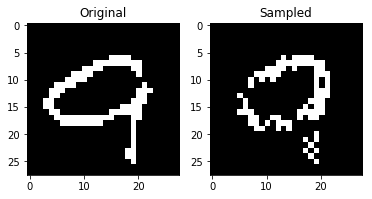

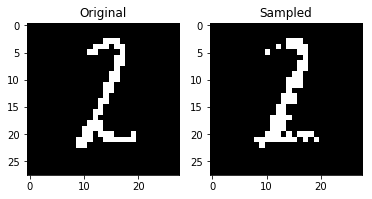

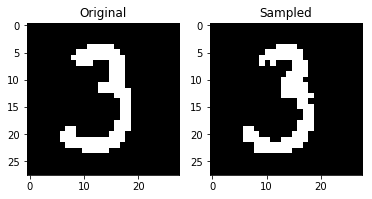

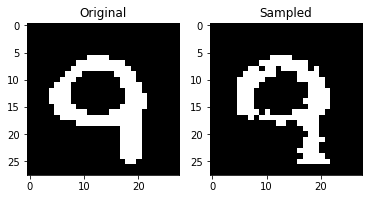

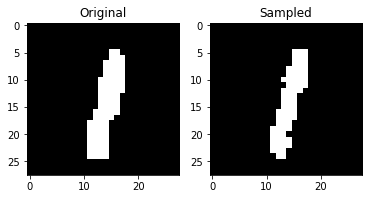

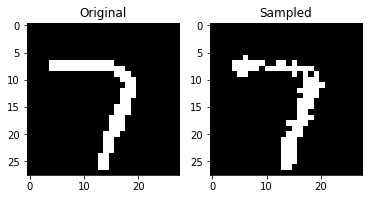

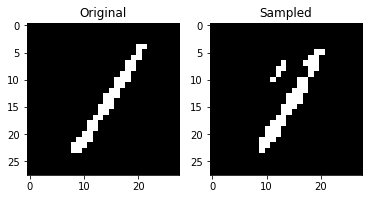

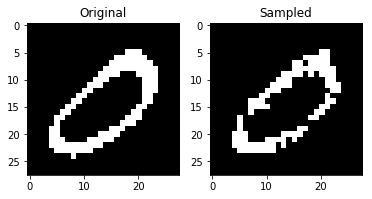

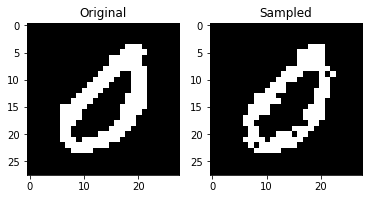

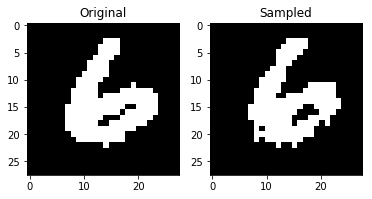

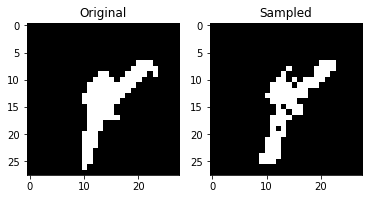

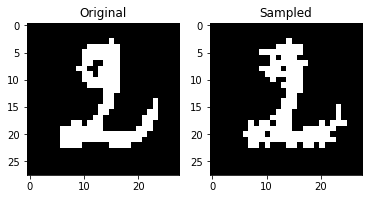

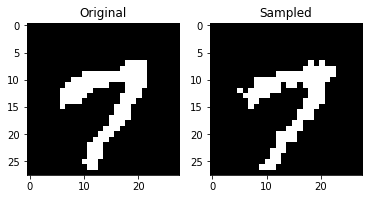

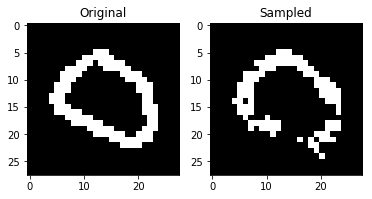

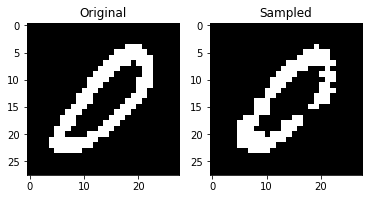

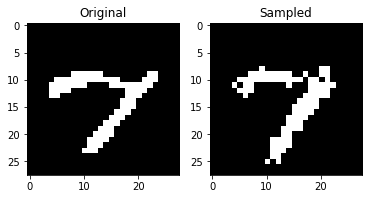

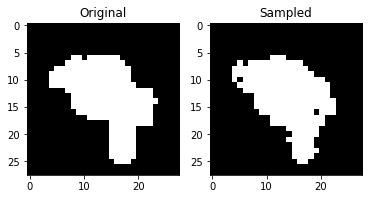

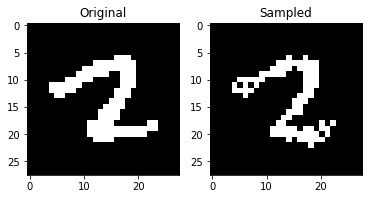

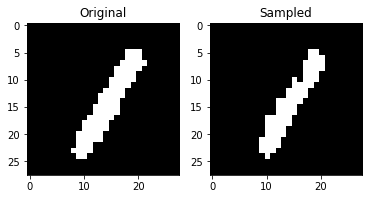

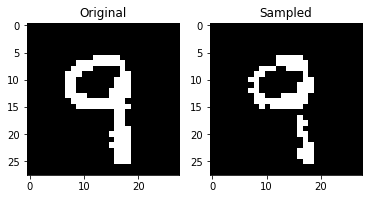

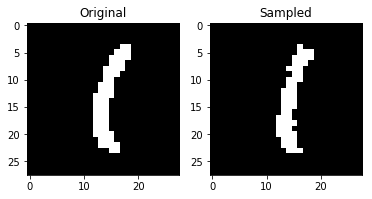

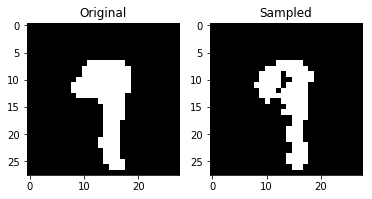

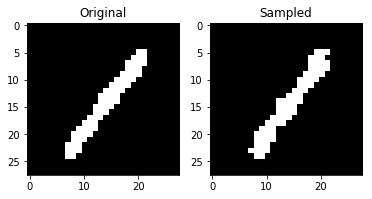

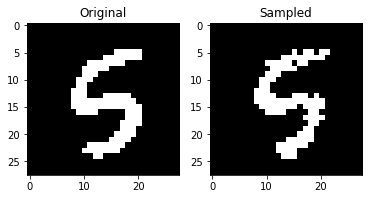

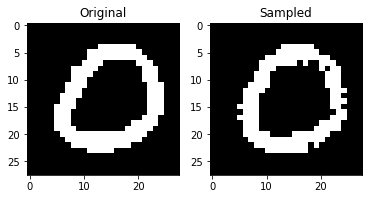

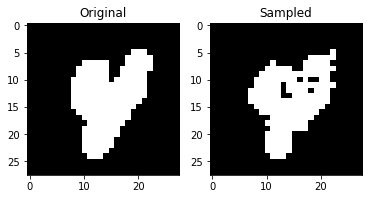

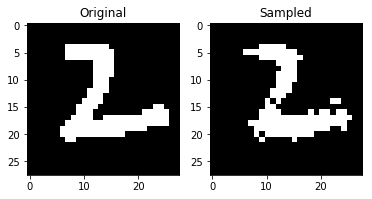

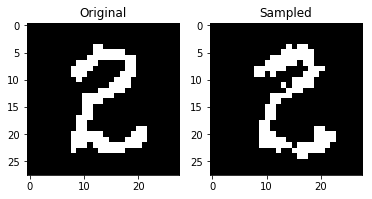

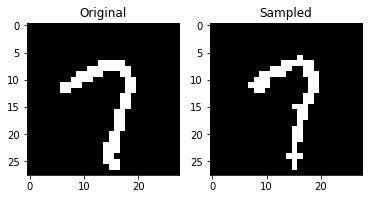

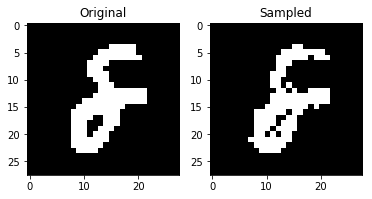

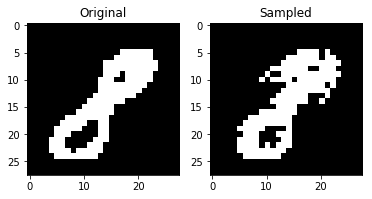

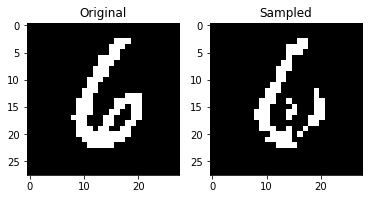

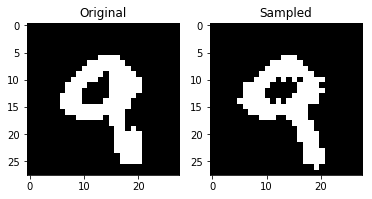

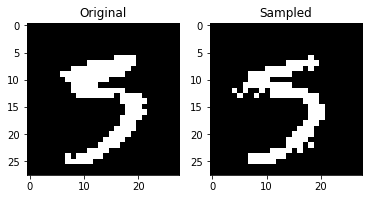

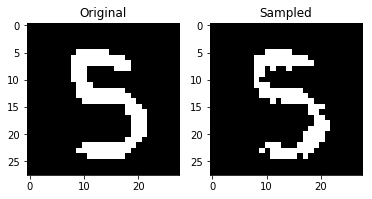

KeyboardInterrupt: 

In [6]:
if __name__ == '__main__':
  X, Y = get_mnist()
  # convert X to binary variable
  X = (X > 0.5).astype(np.float32)

  vae = VariationalAutoencoder(784, [200, 100])
  vae.fit(X)

  # plot reconstruction
  done = False
  while not done:
    i = np.random.choice(len(X))
    x = X[i]
    im = vae.posterior_predictive_sample([x]).reshape(28, 28)
    plt.subplot(1,2,1)
    plt.imshow(x.reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.subplot(1,2,2)
    plt.imshow(im, cmap='gray')
    plt.title("Sampled")
    plt.show()


  # plot output from random samples in latent space
  done = False
  while not done:
    im, probs = vae.prior_predictive_sample_with_probs()
    im = im.reshape(28, 28)
    probs = probs.reshape(28, 28)
    plt.subplot(1,2,1)
    plt.imshow(im, cmap='gray')
    plt.title("Prior predictive sample")
    plt.subplot(1,2,2)
    plt.imshow(probs, cmap='gray')
    plt.title("Prior predictive probs")
    plt.show()
